In [36]:
# Preamble
from __future__ import print_function, division

# dependencies
import numpy as np
import os
import re
import glob
import collections

from scipy.interpolate import interp1d
from scipy import optimize

import pandas as pd
from astropy.io import fits, ascii
import photoz_metrics

from astropy.table import Table, join

# options
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc

rc('figure', figsize = (12, 8))
rc('font',**{'size': 30, 'family':'serif', 'serif':['Palatino']})
rc('text', usetex=True)

STILTS = 'java -Xmx2048M -jar /Users/coupon/local/bin/stilts.jar'
DATADIR = os.environ['HOME']+'/data/euclid/varTrans'
CURRENTDIR = os.environ['HOME']+'/projects/euclid/varTrans'

# TODO

# DONE
# - rerun simulations with a single shift correction for shift and skewness DONE
# - rerun simulations with arbitrary variations and their correction DONE
# - write technical note and paper DONE
# - rerun with zp correction shifts (=scaling) DONE
# - change tilt value from degree to % at edge DONE
# - update NNPZ DONE
# - use NNPZ to compute redshift DONE
# - switch to nanometers? NO
# - run 100 simulations per change (do clusters) DONE
# - add DECam filters DONE
# - add new filter with edge slopes DONE
# - change skewness estimates with slope in degrees DONE
# - change 'ref' to 'trans' DONE
# - get SDSS and DES filter curves DONE
# - rerun simus with full sample and four filter varations DONE
# - rerun photo-zs with full sample and four filter varations DONE
# - add a redshift-dependent requirement DONE

# Abstract

We analyse the impact of variable transmissions on photometric redshifts, by simulating typical variations seen in realistic photometric transmissions, including the effects of current wide-field imagers and the Milky Way Galaxy dust. We confirm that the most problematic effect for a cosmological probe such as the cosmic shear of the ESA mission Euclid, is a systematic bias in mean redshift for an ensemble of galaxies caused by a wavelength shift or a tilt of the transmission. To correct for the effect, we propose a hybrid approach combining a template-fitting and a machine learning methods: 1) we first fit a set of representative reference spectral energy distributions in a high signal-to-noise ratio galaxy sample, 2) we then employ a k-nearest neighbours method to estimate the target redshift by finding the closest reference galaxies in an approximate flux space, 3) we re-compute the fluxes of the reference galaxies in the target's exact photometric transmissions and 4), we finally estimate a redshift probability distribution function from the nearest neighbours' redshifts weighted by their distance in flux space, accounting for the target flux errors. We show that in certain conditions, only the difference in mean wavelength between a reference transmission curve and that of the target source may be used to correct for the effect in the third step above (by shifting the target transmission of the same opposite difference). To meet the Euclid-survey requirement on the mean redshift uncertainty per tomographic bin, $\Delta z <0.002\times(1+z)$, the difference in mean wavelength must be known to a precision between than 2 to 12 \AA{} (depending on wavelength and redshift).

# Introduction


## scientific context

In extragalactic photometric surveys, an accurate knowledge of the filter transmissions is essential to compute the photometric properties of stars and galaxies, such as color and brightness. 

## definition and application of a transmission

These findings are most important for the science cases relying on a accurate mean redshift for an ensemble of galaxies and sensitive to spatial variations affecting two-point correlation statistics, such as cosmic shear.


## definition of variations and impact on measured quantities

Transmissions may vary as a function of 1) the position of the source on the instrument, 2) the location on the sky, and 3) the observing conditions. The variations of transmissions lead to two fundamental issues. First, if the variarions are unknown, what is the impact on the quantities we aim to measure, such as photometric redshifts? And second, if the varations are known, how to cope with them?

## case of Euclid and other missions

In each tomographic bin, the mean redshift of the ensemble of galaxies used for cosmic shear must be known to very high accuracy and is highly sensitive to systematics in color space. So the most problematic impact from transmissions with variable responses is expected to be a scale-dependent systematic error on the mean redshift, i.e. the *unknown* difference between the measured and true mean redshift per tomographic bin (the known difference, the "bias", being calibrated with spectroscopic redshifts and not expected to vary as a function of position in the sky). Variable transmissons will also affect the scatter (and to a lesser extent the number of catastrophic errors) but we assume that the mean redshift issue will largely dominate over the others and therefore we restrict ourselves to quantify the shift on the mean redshift only. 

## what has been done in the lit

Relevant papers:
```
\begin{itemize}
\item Bruzual \& Charlot (2003)
\item Lima et al. (2008)
\item Cunha et al. (2009)
\item Li et al. (2012)
\item Sheldon et al. (2012)
\item Tonry et al. (2012)
\item Tanaka et al. (2017)
\item Beck et al. (2016)
\item etc.
\end{itemize}
```

## how we address the problem (via simulation)

This study aims to address the impact of variable photometric transmissions on photometric redshifts (hereafter photo-$z$'s). 


Even if the actual transmissions are accurately known for a single source, dealing with multiple variable transmissions across the entire survey can be cumbersome, as in the case of template fitting algorithms, which are based on a flux library computed with a unique set of filter transmissions, or in the case of machine learning algorithms, which are based on training samples observed with transmissions that may not be representative to the rest of the survey.

The approach we take in this study is to model a range of typical variations, based on input from various people reporting the behaviour of different instruments, and to estimate the corresponding impact on photo-$z$ accuracy. Therefore, this document must serve as a reference for evaluating the impact *when the exact variations are known*, which will depend on the exact instrument and observing conditions of ground-based data used for Euclid. We stress that this document is *not* the actual prediction of systematics in mean redshift that will exist in the Euclid survey.

To quantify the effect, we use real galaxies from COSMOS with emulated fluxes. To measure the shift in mean redshift, we first emulate the fluxes and compute the photo-$z$'s assuming reference (fixed) transmissions in both steps. Then, we vary the transmissions to emulate new fluxes, and we compute again photo-$z$'s with the reference transmissions. 

The photo-$z$ requirements for Euclid fall into two broad categories: 1) photo-$z$ precision and 2) mean redshift accuracy. The former translates into the traditionally quoted scatter and catastrophic failure (or outlier rate) estimates. Those have been revised by the Euclid science ground segement to be expressed as probability distribution functions (PDF) but, on point estimates, would be equivalent to a scatter smaller than $0.05\times(1+z)$ and an outlier rate smaller than 10% for galaxies used in the cosmic shear probe. The main leverage to increase the precision is to improve the photometry signal-to-noise ratio (SNR) per source and photo-$z$ algorithms (we confirmed within OU-PHZ that a combination of template fitting and machine learning is the best tool to achieve the precision goals).

The specification on accuracy is that, per tomographic bin (there will be 10 bins between $0.2 <z < 2.0$), the mean redshift of the ensemble must be known with better accuracy than $\Delta z = 0.002\times(1+z)$. The current baseline of OU-PHZ is to use spectroscopic redshifts (hereafter spec-$z$'s), matched in color to the Euclid galaxies, to correct for the residual redshift bias. The validation of this procedure will be done with clustering redshifts (hereafter cluster-$z$).

Hence the Euclid galaxies must be observed with stable transmissions, identical to that of the galaxies with spec-$z$'s used for the mean redshift calibration. The problem we address here is when Euclid galaxies are observed in different transmissions compared to the spec-$z$ sample. What is the impact on the mean redshift and from what point do we fail to meet the accuracy requirement, given a type and strength of variation?

## how we fix the problem

We find that the most problematic effect is a systematic bias in mean redshift for an ensemble of galaxies caused by a wavelength shift (-100 to +100\AA{}) or a tilt (-20 to +20\% change at the edges of the transmission), when the galaxies' Balmer break is going through the transmission. A shift as small as 10 Angstroms (1 nm) creates a 0.2\% bias in redshift which is on the same order of magnitude as, e.g., the requirement for the Euclid survey. For an individual galaxy the effect is relatively small, so that the photometric redshift scatter and outlier rate will be weakly affected with respect to the requirements on those two quantities. 


We present a procedure to compute, with machine learning techniques, the photometric redshifts of galaxies observed in a photometric system that differs from that of the training sample. Differences in the photometric systems include different filter sets, variations of a given filter response as a function of time and position on the focal plane, atmospheric absorption, and Galactic extinction. The method requires (1) to build a training sample with known redshifts \emph{and} spectral energy distribution (SED), covering the entire wavelength interval over which galaxies with unknown redshifts are observed, and (2) a precise knowledge of the multiple photometric transmissions between the source and the image. From the known SEDs of the training sample we first compute fluxes in a single photometric system whose response functions are built from averaged filer transmissions and low Galactic extinction. Second, for each individual galaxy with measured fluxes and known response functions, we identify the N reference-sample nearest neighbours in color/flux space, similarly to the method presented by Cunha et al. (2009). Third, we re-compute the predicted fluxes of the reference system, in the photometric system in which the unknown galaxy has been observed. Finally, we compute a $\chi^2$ for each of the reference-unknown galaxy pair and estimate a probability distribution function (PDF) from the (inverse-$\chi^2$) weighted sum of reference redshift PDFs. We show that ... 

## paper overview

In section ...

# Variable transmissions

## Definition of a variable transmission

A "photometric transmission" is everything between the source and the detector. It includes (starting from the source itself) the inter-galatic medium (IGM), the Milky Way dust extinction, the atmosphere (for ground-based facilities), the instrument sensitivity, the photometric filter and the quantum efficiency of the detector. In most cases, the Milky Way extinction and the photometric filter will be the main source of variations. 

## Impact on photo-$z$'s

The photometric redshift method is a way to predict a galaxy redshift PDF from a set of colors and brightness (or simply fluxes - the difference between the two set of quantities being in the way to optimise the photometry measurement). In principle any photo-$z$ method makes use of all the color information but the most informative nformation is when the galaxy SED strongest features are moving through the filters.

The most prominent features are the Lyman ($\sim1000$ Angstroms) and Balmer ($\sim4000$ Angstroms) breaks. The Euclid-survey filter set is optimised to properly constrain the Balmer break in the range $0.2<z<2.0$ with a filter set going from $3000$ to $10000$ Angstroms ($ugrizYJH$ and $vis$ filters).

In the forthcoming sections, we will quantify the exact impact but, to first order, the expected most problematic impact on photo-$z$'s is when the Balmer break at a given redshift enters a filter whose transmission varies. As an example, a galaxy will have its Balmer break enter the $r$-band at $z\sim0.6$:

%%latex
\begin{equation}
z = \frac{\lambda_\mathrm{ mesured}}{\lambda_\mathrm{ emitted}} - 1 = \frac{6400}{4000}-1 = 0.6
\end{equation}

So, a transmission shift $\Delta A$ in the $r$-band translates into a redshift difference at $z\sim0.6$ of:

%%latex
\begin{equation}
\Delta z = \frac{\Delta \lambda (A)}{4000}
\end{equation}

\begin{equation}
\Delta z_\mathrm{req} < 0.002\times(1+z) = \frac{\Delta \lambda(A)}{4000}
\end{equation}

so
\begin{equation}
\Delta \lambda(A) < 0.002\times(1+z)\times4000
\end{equation}



Neglecting the contribution from the other bands, the requirement on the mean redshift accuracy, $0.002\times(1+z)$, would translate into a transmission shift of $0.002\times1.6\times4000=13$ Angstrom (1.3 nm). This means that any galaxy observed with a $r$-band affected by a shift larger than 12 Angstroms but calibrated with spec-$z$'s observed with the reference $r$-band filter must be corrected from the variation of the transmission to meet the mean redshift accuracy requirement.

## Measured variations on current filters

We summarise here the variations measured on current instruments, passed by various people involved in these projects and from the literature. It does not necessarily match what will be encountered in the Euclid survey but it gives an overview of the types and typical ranges of the filter transmission variations seen nowadays.

### Adopted metric

We quantify the variations through the first four moments of the transmission curve: the mean, the standard deviation, the skewness and the kurtosis. The first two moments describes the shift and widening (or shrinking) of the filter, whereas the skewness is a measurement of the asymetry (for example a tilt of the top slope) of the transmission and the kurtosis a measurement of the 'tailedness' of the transmission (typically when leaks or edge softening occur). We compare the four quantities to that of a reference filter (in the measurement of the real filter we take the values measured at the center, when available), in Angstroms ($\Delta A$). Some quantities are correlated with each other (like skewness and mean), so that if, for example, only the cut-off of a transmission (and not the cut-on) is varying, both the mean and standard deviations will vary simulatenously (in fact the higher impact of the asymetry will be a change in effective mean wavelength). Similarly, if the skewness is varying, the mean will vary as well. As the skewness and the kurtosis effects are relative to the scatter, we show their value multiplied by a factor 100.

In principle the higher-order moments will describe the filter variations in greater details, but we believe the above four moments will dominate over the others and are simple quantities to tie together real-life and simulated filters.

In [3]:
# these are the functions to characterize and 
# plot the filters

def mean_trans(lbd, trans):
    """ Return the mean
    wavelength of the transmission
    """
    
    norm = np.trapz(trans, lbd)
    result = np.trapz(trans*lbd, lbd)/norm
    
    return result

def std_trans(lbd, trans):
    """ Return the width
    in wavelength of 
    the filter
    """

    norm = np.trapz(trans, lbd)
    mean_lambda = mean_trans(lbd, trans)
    result = np.sqrt(
        np.trapz((
            mean_lambda-lbd)**2*trans, lbd)/norm)
    
    return result

def skewness_trans(lbd, trans):
    """ Return the skewness
    in wavelength of 
    the filter
    """
        
    norm = np.trapz(trans, lbd)
    mean_lambda = mean_trans(lbd, trans)
    sigma_lambda = std_trans(lbd, trans)

    result = np.trapz(
        ((mean_lambda-lbd)/sigma_lambda)**3*trans, lbd)/norm
    
    return result

def kurtosis_trans(lbd, trans):
    """ Return the kurtosis
    in wavelength of 
    the filter
    """

    norm = np.trapz(trans, lbd)
    mean_lambda = mean_trans(lbd, trans)
    sigma_lambda = std_trans(lbd, trans)

    result = np.trapz(
        ((mean_lambda-lbd)/sigma_lambda)**4*trans, lbd)/norm
    
    return result


def moments_trans(lbd, trans):
    """ Return the first four moments
    of the transmission
    """

    result = {}
    result['mean'] = mean_trans(lbd, trans)
    result['sigma'] = std_trans(lbd, trans)
    result['skewness'] = skewness_trans(lbd, trans)
    result['kurtosis'] = kurtosis_trans(lbd, trans)
    
    return result


def plot_trans(
        df, title, xlim, ylim=(0.0,1.0), ax=None):
    """ plot filters in 
    a data frame and return 
    the figure object 
    """
    
    ax = df.plot.line(
        x='lambda', stacked=False, legend=False,
        title=title, xlim=xlim,
        ylim=ylim, ax=ax)

    ax.set_xlabel(r'$\lambda$ [\AA{}]')
    ax.set_ylabel(r'Transmission')

    return ax

def plot_stats(
        df_center, dfoff_center, roff_center, lbd, 
        title, xlabel='r [mm]', 
        stats=['mean', 'sigma', 'skewness', 'kurtosis'], 
        ax=None, ylim=None, legend_size = 'small', 
        plot_legend = False, file_out = None):
    """ plot the filter stats compared to 
    the center
    """
    
    # profile in the center averaged over the 7 positions
    trans_center = df_center.mean(axis=1)
    
    # stats at the center
    mean_lambda_center = mean_trans(lbd, trans_center)
    sigma_lambda_center = std_trans(lbd, trans_center)
    skewness_lambda_center = skewness_trans(lbd, trans_center)
    kurtosis_lambda_center = kurtosis_trans(lbd, trans_center)
    
    mean_lambda = []
    sigma_lambda = []
    skewness_lambda = []
    kurtosis_lambda = []

    for o in dfoff_center.keys():
        trans = dfoff_center[o]
        mean_lambda.append(mean_trans(lbd, trans))
        sigma_lambda.append(std_trans(lbd, trans))
        skewness_lambda.append(skewness_trans(lbd, trans))
        kurtosis_lambda.append(kurtosis_trans(lbd, trans))
    
    if ax is None:
        fig, ax = plt.subplots()
        
    if 'mean' in stats:
        ax.scatter(
            roff_center, mean_lambda-mean_lambda_center, s=100, 
           label='Mean', marker='o')
    if 'sigma' in stats:
        ax.scatter(
            roff_center, sigma_lambda-sigma_lambda_center, s=100, 
            label='Sigma', marker='s')
    if 'skewness' in stats:
        ax.scatter(
            roff_center, 100.0*(
                skewness_lambda-skewness_lambda_center), s=100, 
            label=r'Skewness$\times100$', marker = '^')

    if 'kurtosis' in stats:
        ax.scatter(
            roff_center, 100.0*(
                kurtosis_lambda-kurtosis_lambda_center), s=100, 
            label=r'Kurtosis$\times100$', marker = '^')
        
    if file_out is not None:
        stats_dict = collections.OrderedDict({})
        stats_dict['mean'] = mean_lambda-mean_lambda_center
        stats_dict['sigma'] = sigma_lambda-sigma_lambda_center
        stats_dict['skewness'] = skewness_lambda-skewness_lambda_center
        stats_dict['kurtosis'] = kurtosis_lambda-kurtosis_lambda_center
        df = pd.DataFrame(stats_dict)
        df.to_csv(file_out, index=False)
        

    ax.set_ylim(ylim)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(r'$\Delta\lambda$ [\AA{}]')
    
    if plot_legend:
        ax.legend(loc='upper left', prop={'size': legend_size})   

    ax.plot(ax.get_xlim(), [0.0, 0.0], color='black', linestyle=':')

    # ax.legend(bbox_to_anchor=(1.1, 1.1))
    
    return ax

### OmegaCam at VST

These are measured transmissions as a function of position on the focal plane of the $ugriz$ OmegaCam filters received from Konrad Kuijken. They include both the manufacturing variations as a function of position and the incidence angle. We take the $r$-band filter as an example.

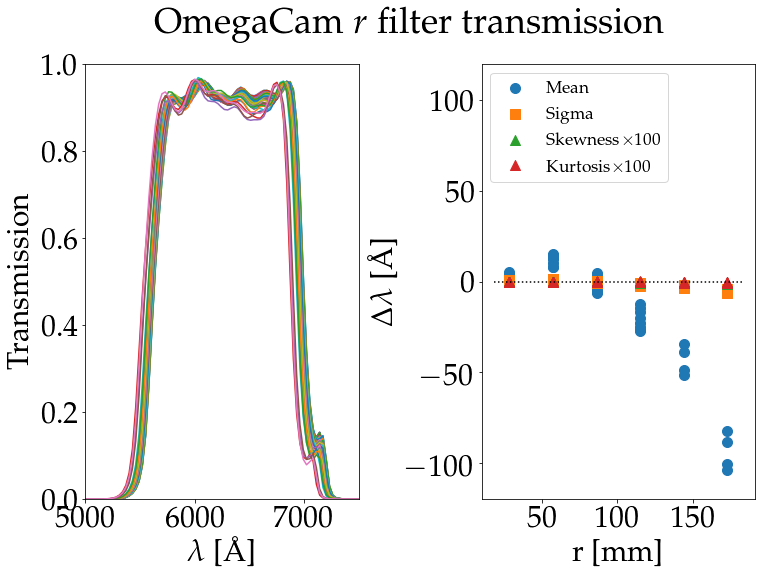

In [37]:
# read data
filter_name = 'r'
filter_var_df = pd.read_csv(
    CURRENTDIR+'/doc/OmegaCam/'+filter_name+'_orig_transmission_data', 
    header=None, sep='\s+', comment='#', 
    names=['lambda']+[str(i) for i in range(2,51)])

# read positions (except the last two positions)
with open(
    CURRENTDIR+'/doc/OmegaCam/r_orig_transmission_data', 'r') as f:
    lines = f.readlines()
    filter_pos = pd.DataFrame({
        'x' : np.array(lines[4].split()[2:-2], dtype=np.float),
        'y' : np.array(lines[5].split()[2:-2], dtype=np.float),
        'r' : np.array(lines[8].split()[2:-2], dtype=np.float)})
    
# convert lambda to Angstroms
filter_var_df['lambda'] *= 10.0

# remove last two curves (not used)
filter_var_df.drop('49', axis=1, inplace=True)
filter_var_df.drop('50', axis=1, inplace=True)

# plot transmission
f, (ax1, ax2) = plt.subplots(1,2)
t = 'OmegaCam ${}$ filter transmission'.format(filter_name)

ax_trans = plot_trans(
    filter_var_df, '', (5000, 7500), ax=ax1)

center = (filter_pos['r'] < 7).values
off_center = (filter_pos['r'] > 7).values
col_center = [str(i) for i in np.array(range(2,49))[center]]
col_off_center = [str(i) for i in np.array(range(2,49))[off_center]]

select = (5000 < filter_var_df['lambda']) & (filter_var_df['lambda'] < 7500)

ax_stats = plot_stats(
    filter_var_df[col_center][select], 
    filter_var_df[col_off_center][select],
    filter_pos['r'][off_center],
    filter_var_df['lambda'][select], '', 
    ylim=(-120.,+120.), plot_legend=True,
    legend_size = 'xx-small',
    file_out='../results/OmegaCam.csv', ax=ax2)

f.subplots_adjust(wspace=0.45)

f.suptitle(t)
# f.set_tight_layout(True)
f.savefig('../plots/OmegaCam.pdf')

### JAST at Javalembre

The Javalambre Auxiliary Survey Telescope (JAST/T80) is the companion telescope of the Javalambre Survey Telescope. The filter transmissions for the $g$-band filter as a function of position on the focal plane were given by Jesus Varela. They only include the manufacturing variations and not the incidence angle (to check).

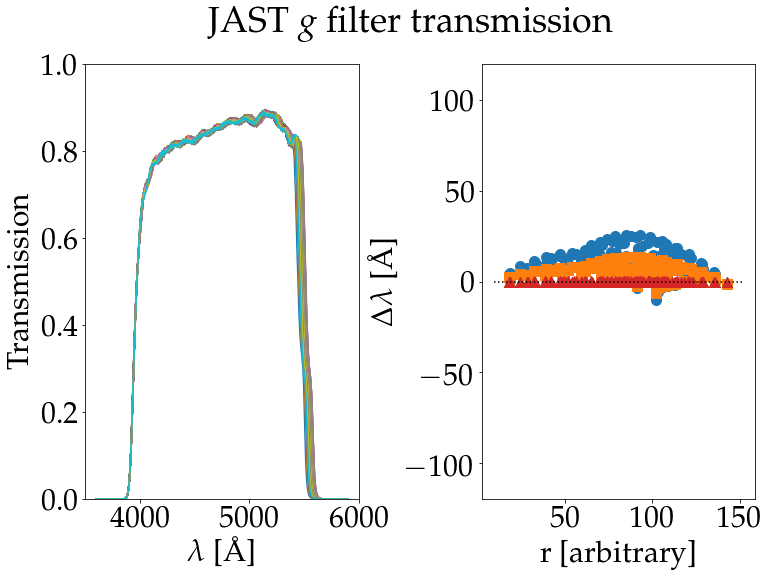

In [38]:
## read data
filter_name = 'g'
filter_var_df = pd.read_csv(
    CURRENTDIR+'/doc/JAST/'+filter_name+'SDSS_2D_JAST_OAJ.txt', 
    header=None, sep='\s+', comment='#', 
    names=['lambda', 'ref1']
    +[str(i) for i in range(3,103)]+['ref2'])

# convert lambda to Angstroms
filter_var_df['lambda'] *= 10.0

# convert transmission from 100 to 1
for i in range(3,103):
    filter_var_df[str(i)] /= 100.0

# remove last two curves not used in science
filter_var_df.drop('ref1', axis=1, inplace=True)
filter_var_df.drop('ref2', axis=1, inplace=True)

filter_pos = pd.read_csv(
    CURRENTDIR+'/doc/JAST/'+filter_name+'SDSS_2D_Positions.tab', 
    header=None, sep='\s+', comment='#', 
    names=['id', 'x', 'y'])

# add radius
filter_pos['r'] = pd.Series(
    np.sqrt(filter_pos['x']**2+filter_pos['y']**2))

# plot transmission
f, (ax1, ax2) = plt.subplots(1,2)
t = 'JAST ${}$ filter transmission'.format(filter_name)

ax_trans = plot_trans(
    filter_var_df,
    '', (3500, 6000), ax=ax1)

center = (filter_pos['r'] < 10).values
off_center = (filter_pos['r'] > 10).values
col_center = [str(i) for i in np.array(range(3,103))[center]]
col_off_center = [str(i) for i in np.array(range(3,103))[off_center]]

ax_stats = plot_stats(
    filter_var_df[col_center], 
    filter_var_df[col_off_center],
    filter_pos['r'][off_center],
    filter_var_df['lambda'], '',
    xlabel='r [arbitrary]', ylim=(-120.,+120.), 
    file_out='../results/JAST.csv', ax=ax2)

f.subplots_adjust(wspace=0.45)

f.suptitle(t)
# f.set_tight_layout(True)
f.savefig('../plots/JAST.pdf')

### MegaCam at CFHT

Measurements based on standard stars exist for the old MegaCam filters from Betoule et al. (2013). We show below the $r$-band measurements at several radii from the filter center. These varations include everything as they are measured on standard stars in real conditions.

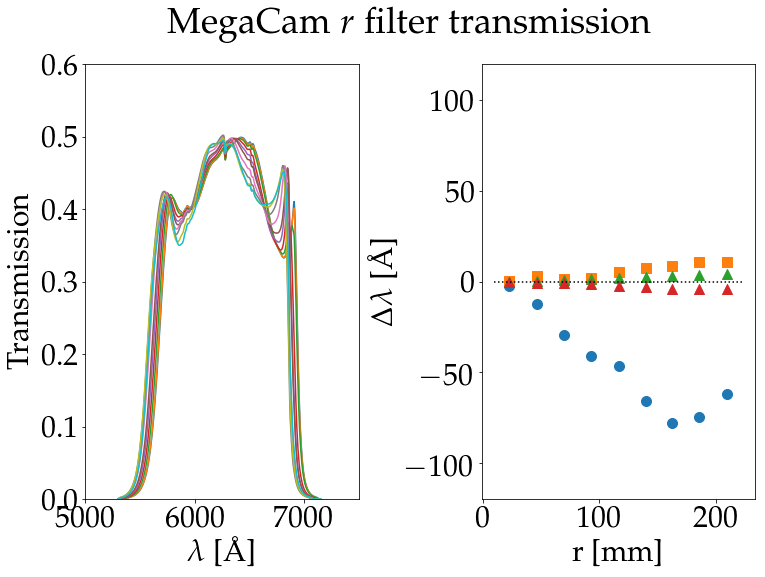

In [39]:
# read data
filter_name = 'r'
filter_var_df = pd.read_csv(
    CURRENTDIR+'/doc/MegaCam/Betoule2013_'+filter_name+'.txt', 
    header=None, sep='|', comment='#', 
    names=['lambda']
    +[str(i) for i in range(1,11)] )

filter_pos = pd.DataFrame({
        'r': np.array([0.0, 23.0, 47.0, 
        70.0, 93.0, 117.0, 140.0, 163.0, 
        186.0, 210.0])})

center = (filter_pos['r'] < 10.).values
off_center = (filter_pos['r'] > 10.0).values
col_center = [str(i) for i in np.array(range(1,11))[center]]
col_off_center = [str(i) for i in np.array(range(1,11))[off_center]]

# plot transmission
f, (ax1, ax2) = plt.subplots(1,2)
t = 'MegaCam ${}$ filter transmission'.format(filter_name)

ax_trans = plot_trans(
    filter_var_df,
    '', 
    (5000, 7500), ylim=(0.0,0.6), ax=ax1)

ax_stats = plot_stats(
    filter_var_df[col_center], 
    filter_var_df[col_off_center],
    filter_pos['r'][off_center],
    filter_var_df['lambda'], '',
    ylim=(-120.,+120.), file_out='../results/MegaCam.csv', ax=ax2)


f.subplots_adjust(wspace=0.45)

f.suptitle(t)
# f.set_tight_layout(True)
f.savefig('../plots/megacam.pdf')

After the decommissioning of the old MegaCam filters, they have been brought to a laboratory in Lyon to be tested with a spectrograph on a measurement bench. The results point out some differences compared to the Betoule et al. study (J.-C. Cuillandre, private communication), but confirm the general trends and orders of magnitude (i.e. typically 80 Angstrom shift from center to border).

Since then, better filters have been obtained and installed on MegaCam. The shift that orignates from manufacturing has been reported to be reduced to 10 Angstroms and the incidence angle shift is a smaller effect than typical variations (figure from Jean-Charles Cuillandre):

![Blue shift in modern filters (from J.-C. Cuillandre)](/Users/coupon/projects/euclid/varTrans/doc/MegaCam/FiltersTransmissionVariabilitySources.XGA.jpg)

**[Jean] I am confused by the impact of the incidence angle on the filter. If it's really constant, it's less problematic for photo-z's as the calibration fields will be observed with the same filter. If it varies across the focal plane, it is an effect we need to study. However, since the effect is equivalent to a shift caused by manufacturing, our tests will capture anyway the effect of a shift (due to either effect), which is fine for this study.**

### The Sloan camera

From Doi et al. (2010).

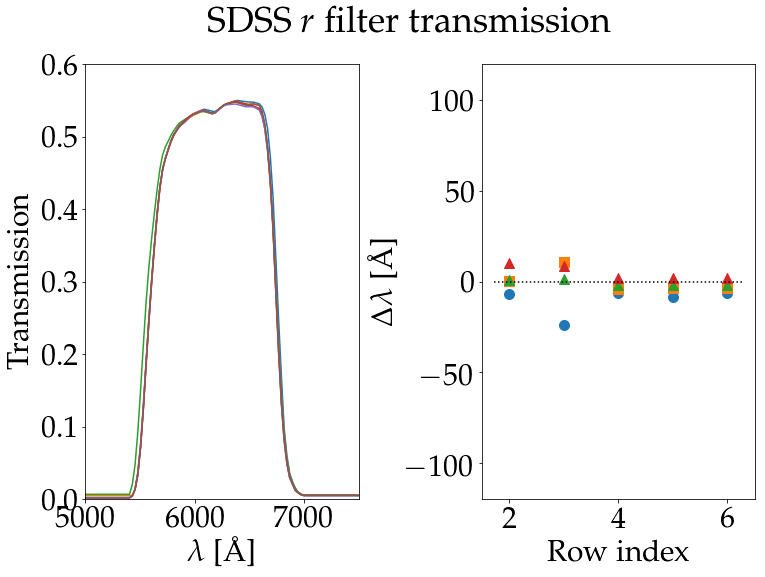

In [40]:
## read data
filter_name = 'r'
df = { 'lambda': np.linspace(5000.0, 7500., 100) }

for i in range(1,7):
    t = ascii.read(CURRENTDIR+'/doc/SDSS/'+filter_name+str(i)+'.dat')
    df['trans'+str(i)] = np.interp(df['lambda'], t['col1'], t['col2'])

filter_var_df = pd.DataFrame(df)

col_center = ['trans1']
col_off_center = ['trans'+str(i) for i in np.array(range(2,7))]

# plot transmission
f, (ax1, ax2) = plt.subplots(1,2)
t = 'SDSS ${}$ filter transmission'.format(filter_name)

ax_trans = plot_trans(
    filter_var_df,
    '', 
    (df['lambda'][0], df['lambda'][-1]), ylim=(0.0,0.6), ax=ax1)

ax_stats = plot_stats(
    filter_var_df[col_center], 
    filter_var_df[col_off_center],
    [float(i) for i in range(2,7)],
    filter_var_df['lambda'], '',
    ylim=(-120.,+120.),
    xlabel='Row index', file_out='../results/SDSS.csv', ax=ax2)


f.subplots_adjust(wspace=0.45)

f.suptitle(t)
# f.set_tight_layout(True)
f.savefig('../plots/sdss.pdf')

### DECam at the Blanco telescope

Burke et al. (2017)
Li et al. (2016)

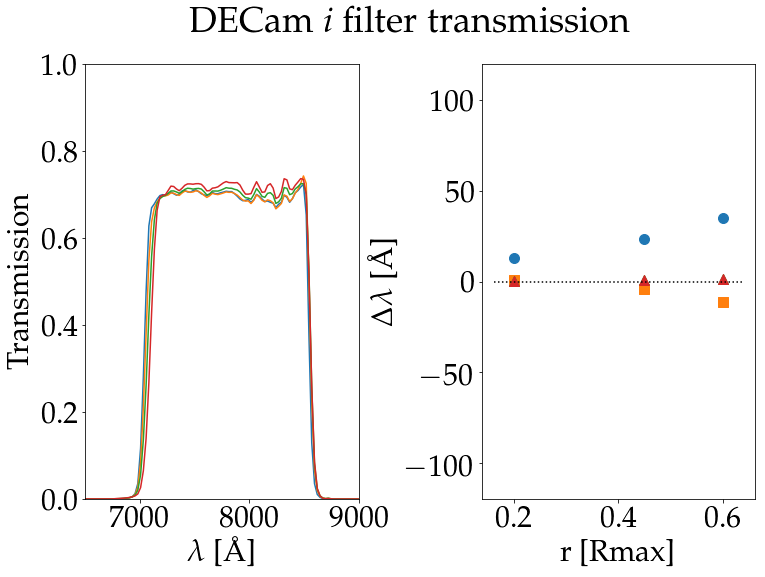

In [41]:
# read data
# In all files, the columns are wavelength (nm),  
# average (entire focal plane),  region1,  region2,  
# region3,  region4 (as defined in the paper).  
# Please ignore the last column. 

# lbda_min = 5000.0
# lbda_max = 9000.0
# filter_name = 'r'

lbda_min = 6500.0
lbda_max = 9000.0
filter_name = 'i'

df = { 'lambda': np.linspace(lbda_min, lbda_max, 100) }

for i in range(1,5):
    t = ascii.read(CURRENTDIR+'/doc/DECam/Li2016/'+filter_name+'.dat')
    df['trans'+str(i)] = np.interp(df['lambda'], t['col1']*10.0, t['col'+str(i+2)]/np.mean(t['col'+str(i+2)])/2.0)
    
filter_pos = pd.DataFrame({
        'r': np.array( [0.0, 0.2, 0.45, 0.6])})
    
filter_var_df = pd.DataFrame(df)

center = (filter_pos['r'] < 0.1).values
off_center = (filter_pos['r'] > 0.1).values
col_center = ['trans1']
col_off_center = ['trans'+str(i) for i in np.array(range(2,5))]

# plot transmission
f, (ax1, ax2) = plt.subplots(1,2)
t = 'DECam ${}$ filter transmission'.format(filter_name)

ax_trans = plot_trans(
    filter_var_df,
    '', 
    (lbda_min, lbda_max), ylim=(0.0,1.0), ax=ax1)

ax_stats = plot_stats(
    filter_var_df[col_center], 
    filter_var_df[col_off_center],
    filter_pos['r'][off_center],
    filter_var_df['lambda'], '',
    ylim=(-120.,+120.), xlabel='r [Rmax]', 
    file_out='../results/DECam.csv', ax=ax2)


f.subplots_adjust(wspace=0.45)

f.suptitle(t)
# f.set_tight_layout(True)
f.savefig('../plots/decam.pdf')

### Hyper Suprime Cam at Subaru

The first $i$-band and $r$-band filters of the Hyper Suprime Cam suffered from an important wavelength shift on the cut-on and cut-off wavelengths in the form of a concentric ring located about half way between the center and the edge. Miyazaki et al. (2017) report a shift of up to 7 nm (70 Angstroms). Since 2016, both filters have been replaced with more uniform transmissions.

## Modeling the variations

We model in this section the typical transmission variations and a range of amplitudes. Our approach is to be as close to the reality as possible but with no actual prediction for the typical variations that the Euclid survey will encounter. The goal is to establish a set of possible variations and test the impact on photo-$z$'s. It must be used as a ruler to predict the true impact on Euclid (and the actions to be taken to address the problem) when the actual variations are known.

Therefore, we will test each effect independently and adopt a range of amplitudes to mimic what's observed in different cases.

Based on the discussions with people involved in several surveys and the results presented above, we propose four separate kinds of variations:

- a shift in wavelength
- a widening or shortening (stretch) of the transmission width
- a change in slope (tilt) as a function of wavelength
- and a softening of the edges (to mimic the combination of several transmissions)

The change in overall sensitivity will also induce a shift in color if the calibration does not correct for it, so we also test the scaling, although this is not directly linked to a proper transmission variation (but can occur if the calibration is done against sources with very different colours than the Euclid galaxies).

### The reference transmission

As the reference transmission, we model a $r$-band filter whose response is a top-hat function between 5600 and 7000 Angstroms centered on $<\lambda>=6300$ Angstroms. The maximum transmission is 0.5.

### Shift

We model the shift by simply shifting the transmission towards the blue and the red from -100 Angstrom to +100 Angstrom, respectively. The only impact on the stats compared to the reference filter is a difference in mean wavelength.

### Stretch

We model the impact of a change in filter width between -2.0\% and +2.0\% (equivalent to -15 and +15\AA). The main impact on the moments is a increased standard deviation.

### Tilt

We model the impact of the transmission symetry by tilting the top slope. We vary the slope so that the red and blue edges transmission values vary between -10\% to +10\%, which seems to reproduce well the observed skewness values seen above. The tilt creates both a change in mean and skewness compared to the reference transmission.

### Softening

We model a fourth kind of variation by softening the blue and red edges of the transmission. In addition to increasing the width of the transmission, this will result in a softening of the transmission edges, spreading the tails of the transmission and increasing the value of the kurtosis. We model it by convolving the transmission with a triangle whose base is expressed in units of the transmission width. We increase the size of the base until we reach the largest kurtosis value seen above multiplied by two. The factor two is a conservative estimate to reproduce the arbitrary combination of transmissions with different shapes which will typically soften the transmission edges (this can for example occur when several exposures are stacked together). We vary the size of the base between 0 and 0.8 times the standard deviation (0.4 the transmission width).

### Scaling

We model the scaling issue by multiplying the flux by a constant between 0.98 and 1.02 to mimic typical calibration errors between 0 and 2%.

In [42]:
# these are the functions to create and 
# change the transmission shape

def create_r_top_hat_trans(name, top=0.5):
    """ Create a top-hat transmission 
    simlar to a r-band """
    N = 10000
    
    result = {}
    if name is 'r' :
        result['lambda'] = np.linspace(5000.0, 8000.0, N)
        result['trans'] = np.zeros(N)
        result['trans'][(5600.0 < result['lambda']) \
                        & (result['lambda'] < 7000.0)] = top
    return result

def shift_trans(lbd, trans, shift):
    """ Shift the filter
    transmission in wavelength.
    A positive shift goes towards
    higher wavelengths (red) 
    
    INPUT
    - lbd: wavelength
    - trans: transmission values
    - shift: in wavelength

    OUTPUT
    - modified filter
    """
    
    return np.interp(lbd-shift, lbd, trans)

def stretch_trans(lbd, trans, stretch):
    """ Modify the transmission by 
    stretching the transmission 
    around the mean.
    
    The strecth value is the fractional 
    increase of the transmission,
    between -1 and 1.
    
    INPUT
    - lbd: wavelength
    - trans: transmission values
    - stretch (between -1 and 1)

    OUTPUT
    - modified filter
    """
    
    result = np.zeros(len(trans))
    
    # record where the transmission is non zero
    pos = np.argwhere(trans > 0.1).flatten()
    
    # mean lambda
    mean = mean_trans(lbd, trans)
    
    lbd_stretched = (lbd-mean)*(1.0+stretch)+mean
    
    result = np.interp(lbd, lbd_stretched, trans)
    
    return result

def tilt_trans(lbd, trans, tilt):
    """ Modify the transmission by 
    tilting the top around the mean.
    
    The tilt value is the fractional 
    increase of the transmission at
    the red edge, between -0.5 and 0.5.
    
    A positive tilt will skew 
    the filter to the red.
    
    INPUT
    - lbd: wavelength
    - trans: transmission values
    - tilt (between -0.5 and 0.5)

    OUTPUT
    - modified filter
    """
    
    result = np.zeros(len(trans))
    
    # record where the transmission is non zero
    pos = np.argwhere(trans > 0.1).flatten()
    
    # mean lambda
    mean = mean_trans(lbd, trans)
    
    # sigma lambda
    sigma = std_trans(lbd, trans)

    # fractional increase
    frac_increase = 1.0+tilt/sigma \
        * (lbd[pos]-mean)

    # compute transmission
    result[pos] = trans[pos]*frac_increase

    return result

def softening_trans(lbd, trans, softening):
    """ Modify the transmission by 
    softening the edges through 
    a convolution with a trapezoid
    
    The softening value is the width of the 
    trapezoid relative to the sigma of 
    the distribution
    
    INPUT
    - lbd: wavelength
    - trans: transmission values
    - softening (between 0 and 1)

    OUTPUT
    - modified filter
    """
    
    # result = np.zeros(len(trans))

    if softening == 0.0:
        return trans
    
    # mean lambda
    mean = mean_trans(lbd, trans)

    # sigma lambda
    sigma = std_trans(lbd, trans)
    
    # kernel = trapezoid
    # x = np.array([-1.0, -0.1, +0.1,  +1.0])*sigma*softening
    # y = np.array([0.0, 1.0, 1.0, 0.0])
    x = np.array([-1.0, 0.0,  +1.0])*sigma*softening
    y = np.array([0.0, 1.0, 0.0])


    kernel_x = np.arange(x[0], x[-1], lbd[1]-lbd[0])
    kernel_y = np.interp(kernel_x, x, y)
    
    result = np.convolve(trans, kernel_y, 'same')
    
    return result/np.max(result)*np.max(trans)

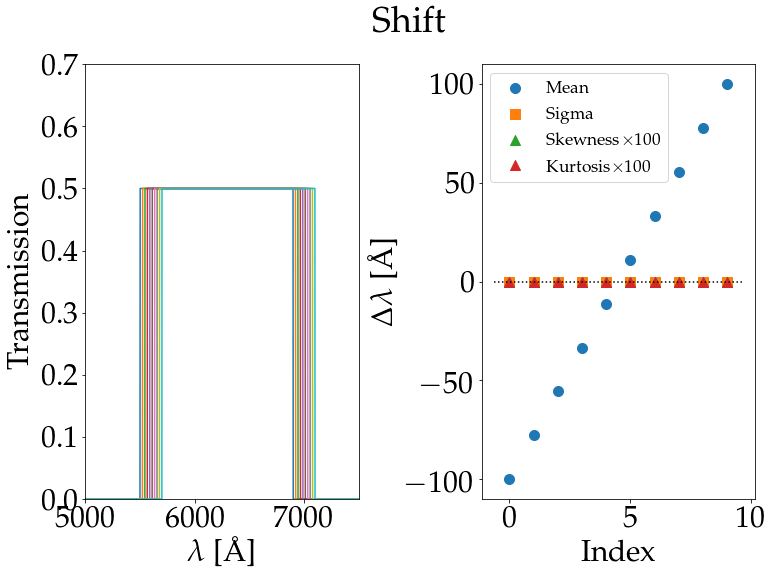

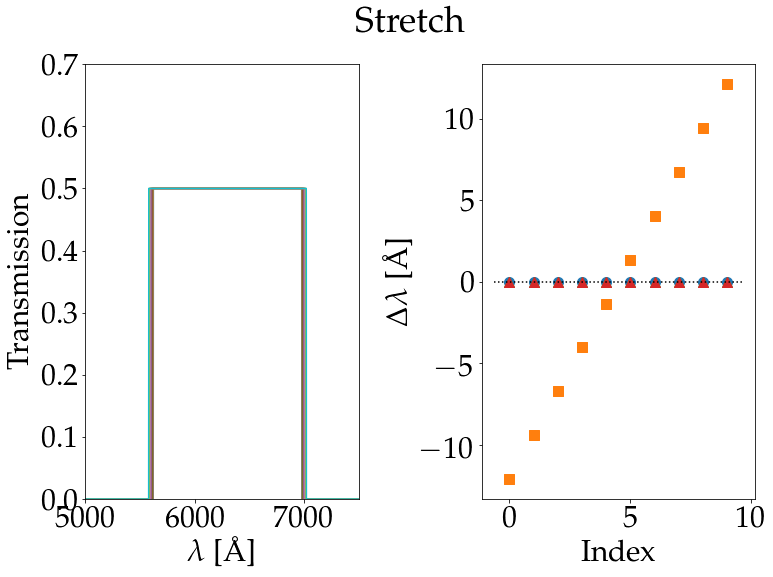

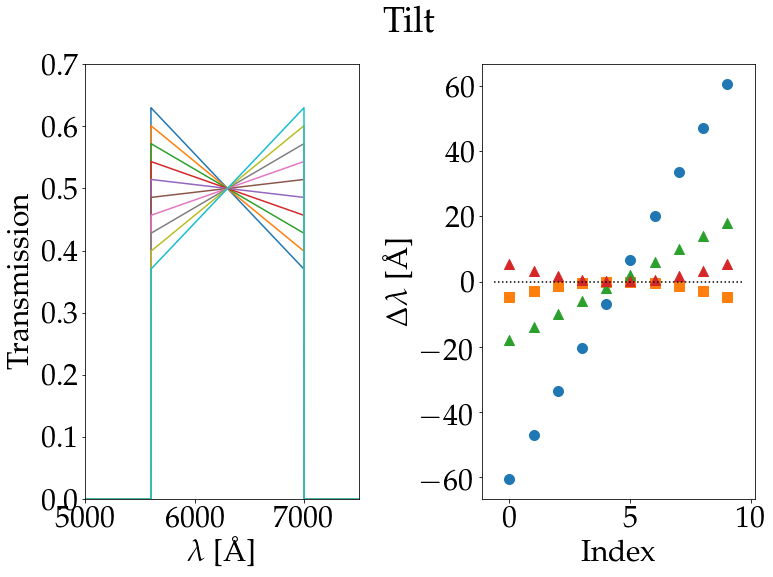

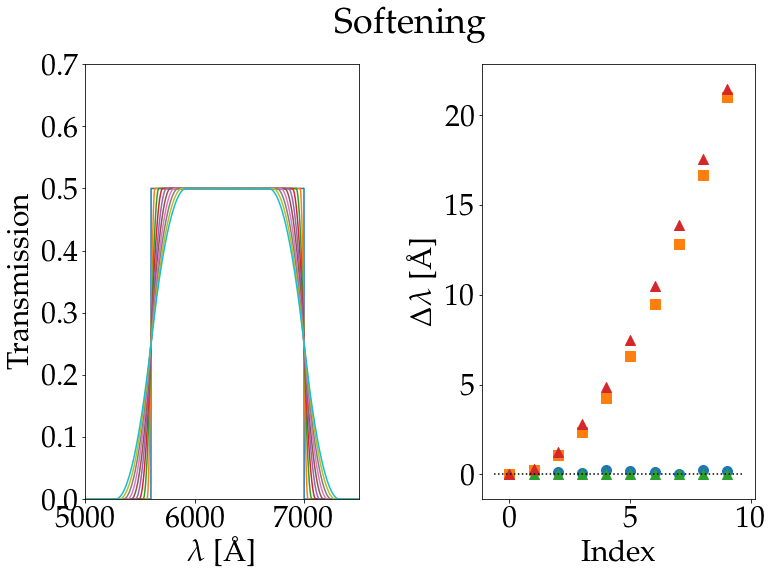

In [43]:
# defintion of a r-band top-hat filter
filter_var_df = pd.DataFrame(create_r_top_hat_trans('r'))

# number of different variations
VAR_N = 10

# define range of variations
VAR_VALUES = collections.OrderedDict()
VAR_VALUES['shift'] = np.linspace(-100.0, +100.0, VAR_N)
VAR_VALUES['stretch'] = np.linspace(-3.0e-2, +3.0e-2, VAR_N)
VAR_VALUES['tilt'] = np.linspace(-0.15, +0.15, VAR_N)
VAR_VALUES['softening'] = np.linspace(0.0, 0.8, VAR_N)
VAR_VALUES['scaling'] = np.linspace(-0.05, +0.05, VAR_N)

VAR_UNITS = collections.OrderedDict()
VAR_UNITS['shift'] =  '\AA{{}}'
VAR_UNITS['stretch'] = '\%'
VAR_UNITS['tilt'] = '\%'
VAR_UNITS['softening'] = '\sigma'
VAR_UNITS['scaling'] = '\%'

for i in range(VAR_N):
    for t in VAR_VALUES:
        if t == 'scaling':
            continue
        filter_var_df[t+str(i)] = \
            pd.Series(locals()[t+'_trans'](
                filter_var_df['lambda'], 
                filter_var_df['trans'], 
                VAR_VALUES[t][i]))

# plot transmission and stats
for t in VAR_VALUES:
    
    plot_legend = False
    if t == 'shift':
        plot_legend = True

    
    # treat scaling differently as 
    # the shape is SED independent
    if t == 'scaling':
        
        stats_dict = collections.OrderedDict({})
        stats_dict['mean'] = [0.0]*VAR_N
        stats_dict['sigma'] = [0.0]*VAR_N
        stats_dict['skewness'] = [0.0]*VAR_N
        stats_dict['kurtosis'] = [0.0]*VAR_N
        df = pd.DataFrame(stats_dict)
        df.to_csv(
            '../results/trans_stats_{}.csv'.format(t), 
            index=False)
    else:
        f, (ax1, ax2) = plt.subplots(1,2)
        ax_trans = plot_trans(
            filter_var_df.filter(regex='lambda|'+t+'*'),
            '', (5000, 7500), ylim=(0.0,0.7), ax=ax1)

        col_center = ['trans']
        col_off_center = [t+str(i) for i in range(10)]

        ax_stats = plot_stats(
            filter_var_df[col_center],
            filter_var_df[col_off_center],
            range(10),
            filter_var_df['lambda'], '',
            xlabel='Index', ax=ax2, 
            ylim=None, 
            legend_size = 'xx-small',
            file_out='../results/trans_stats_{}.csv'.format(t), 
            plot_legend=plot_legend)
        f.subplots_adjust(wspace=0.45)

        f.suptitle(t.title())
        # f.set_tight_layout(True)
        f.savefig('../plots/r_'+t+'.pdf')
        

In [44]:
# write transmissions
filter_var_names = []
for t in VAR_VALUES:

    output_dir = CURRENTDIR+'/filters/'+t
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    for i in range(VAR_N):
        filter_var_names.append('r_'+t+str(i))

        # do not write filter for scaling
        if t == 'scaling':
            continue

        filter_var_df.filter(regex='lambda|'+t+str(i)).to_csv(
            output_dir+'/r_'+t+str(i)+'.ascii', 
            columns=['lambda', t+str(i)], 
            sep=' ', index=False, header=False)

# Simulations

In this section we perfom the simulations to test the impact of filter varations on photo-$z$'s. The basic principle is to simulate the fluxes with varying transmissions but compute the photo-$z$'s with a reference filter set.

## The reference filter set

The reference filter set is composed of the Euclid-survey filters, i.e. the PLM vis and near-IR filters and the ground-based filters. For the latter we assume MegaCam-type filters, except for the $r$-band filter for which we assume a transmission whose response is a top-hat function between 5600 and 7000 Angstroms centered on <λ>=6300 Angstroms, as we adopted in the previous section, with the slight difference that the maximum transmission is 0.5 to mimic the attenuation from the atmosphere and the mirror.

u 3679 -0.08 7.36
g 4842 0.21 9.68
r 6439 0.61 12.88
i 7821 0.96 15.64
z 9172 1.29 18.34
vis 7156 0.79 14.31
Y 10862 1.72 21.72
J 13685 2.42 27.37
H 17727 3.43 35.45


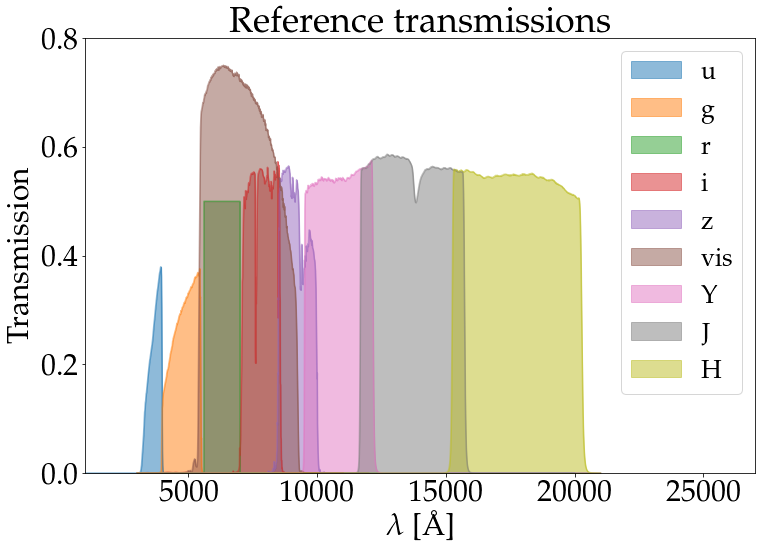

In [45]:
# location of Euclid filters
filter_dir = os.environ['HOME']+'/data/euclid/WP_testing/DC3/filters/final'

# read filter and put in data frames (df)
filter_ref_names = ['u', 'g', 'r', 'i', 'z', 'vis', 'Y', 'J', 'H']
filter_dfs = {}
for f in filter_ref_names:
    filter_dfs[f] = pd.read_csv(
        filter_dir+'/'+f+'.ascii',
        header=0, sep='\s+', 
        names=['lambda', f])

    norm = np.trapz(filter_dfs[f][f], filter_dfs[f]['lambda'])
    mean = np.trapz(
        filter_dfs[f]['lambda']*filter_dfs[f][f], filter_dfs[f]['lambda'])/norm
    z_Blamer = mean/4000.0-1
    print('{} {:.0f} {:.2f} {:.2f}'.format(f, mean, z_Blamer, 0.002*(1+z_Blamer)*4000.))


# replace r filter with top hat
filter_dfs['r'] = pd.DataFrame(create_r_top_hat_trans('r', top = 0.50))
filter_dfs['r'].rename(columns={'trans': 'r'}, inplace=True)

# plot filters
fig, ax = plt.subplots()
for f in filter_ref_names:
    filter_dfs[f].plot.area(
        x='lambda', stacked=False, 
        title='Reference transmissions', 
        ax=ax,)
    ax.set_xlabel(r'$\lambda$ [\AA{}]')
    ax.set_ylabel('Transmission')

# adjust plot
ax.set_ylim([0.0,0.8])
ax.set_xlim([1000,27000])
plt.legend(loc='upper right', fontsize='small') #, bbox_to_anchor=(1.0, 1.0))

fig.savefig('../plots/reference_filters.pdf')

# write reference filter transmissions
output_dir = CURRENTDIR+'/filters/ref'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for f in filter_ref_names:
    filter_dfs[f].to_csv(output_dir+'/'+f+'.ascii', columns=['lambda', f], 
                 sep=' ', index=False, header=False)   

## The variable filter set

We limit ourselves to the variations of the $r$-band filter and focus on the photo-$z$ mean redshift in the interval where the Balmer break goes through the filter wavelength range, i.e between $0.3<z<0.8$. We expect that similar trends will occur at different redshifts when other filters are affected by variable transmissions, but we have no reason to think that the effect will be any weaker for the $r$-band than for the other bands, even when accounting for the stretch of the SED with redshift (that could potentielly increase the effect in redder bands), as the performances are always divided by a factor 1+$z$.

The variations we adopt are identical to those described above and are composed of 10 shifts between -100 and +100 Angstroms, 10 stretches between -20 and +20 Angstroms, 10 values for the tilt, and 10 softening values.

## The simulated sample

We start from real galaxies from the COSMOS field ("COSMOS2015", Laigle et al. 2016) for which a spectral energy distribution (SED) has been fitted to each of them (using the available 30 photometric bands and the best photo-$z$ estimate, Ilbert et al.) and we emulate the galaxies' fluxes in the fixed set of transmissions, as well as the additional 30 variable $r$-band transmission's fluxes.

The main sample is split into two equal samples along a constant RA line to ensure their independence: a deeper calibration sample ("calib") and a target sample ("valid") at the Euclid-Wide depth.

In [46]:
with open(CURRENTDIR+'/filters/filterListAll.ascii', 'w') as file_out: 
    for f in filter_ref_names:
        file_out.write(CURRENTDIR+'/filters/ref/'+f+'.ascii\n')
        
    for f in filter_var_names:
        if 'scaling' in f:
            continue
        dir_name = re.sub(r"[0-9]", '', f).replace('r_', '')
        file_out.write(
            CURRENTDIR+'/filters/'+dir_name+'/'+f+'.ascii\n')

In [47]:
# directory with the reference galaxies' SEDs
ref_dir = os.environ['HOME']+'/data/NNPZ/COSMOS/v2.0/referenceSample'
file_filters = CURRENTDIR+'/filters/filterListAll.ascii'

# output files with all fluxes
file_out = DATADIR+'/fluxes.fits'

# emulate photometry
if False:
    # run shell command to compute photometry
    ! NnpzBuildPhotometry --sample-dir {ref_dir} --filter {file_filters} \
        --out-file {file_out} --out-type F_nu_uJy

    # add scaling
    with fits.open(file_out, hdu=1) as thdu_in:
        cols = []
        for i,v in enumerate(VAR_VALUES['scaling']):
            cols.append(
                fits.Column(
                    name='r_scaling'+str(i),
                    format=thdu_in[1].columns['r'].format, 
                    array=thdu_in[1].data['r']*(1.0+v)))

        thdu_list_out = []
        thdu_list_out.append(thdu_in[0])
        thdu_list_out.append(
            fits.BinTableHDU.from_columns(
                thdu_in[1].columns+fits.ColDefs(cols)))
        for h in thdu_in[2:]:
            thdu_list_out.append(h)

        thdu_out = fits.HDUList(thdu_list_out)
        thdu_out.writeto(file_out.replace(
            '.fits', '_scaling.fits'), overwrite=True)

        thdu_out.close()

The errors are computed assuming the depth requirements from the Euclid COG group (J.-C. Cuillandre, private communication). Those were also adopted for the photo-$z$ data chalenge 3 (DC3, see documentation). The flux error includes both the Poisson noise from the object brightness and the sky background. The 10-sigmas depths (background-dominated) in optimal apertures ($1.7*{{\rm FWHM}_{\rm PSF}}^{0.5}$) are given below:

| Filter        | Depths (10 sigmas)|
| ------------- |:-------------:|
| $u$ | 23.6 |
| $g$ | 24.5 |
| $r$ | 23.9 | 
| $i$ | 23.6 |
| $z$ | 23.4 |
| vis | 24.6 |
| $Y$ | 23.0 |
| $J$ | 23.0 |
| $H$ | 23.0 |

The calibration sample has depths 5 times that of the target catalogue (= 25 times the observing time).

Full details are given in the data challenge 3 documentation.

In [48]:
# pixel scale in arcsec in COSMOS15 catalogue
PIXEL_SCALE = 0.15

# typical size of Euclid galaxies in arcsec
SIZE_TYPICAL_EUCLID = 0.600770354271

# SIZE_TYPICAL_EUCLID_PIX = SIZE_TYPICAL_EUCLID/PIXEL_SCALE

def match_COSMOS2015(file_in, file_out):
    """ Match file_in with the 'COSMOS15'
    catalogue (Laigle et al. 2016) to get 
    coordinates, size and redshift.
    
    Get and unzip the COSMOS15 catalogue (1.5GB) at
    ftp://ftp.iap.fr/pub/from_users/hjmcc/COSMOS2015/COSMOS2015_Laigle+_v1.1.fits.gz
    
    """

    # read file in
    table_in = Table.read(file_in, hdu=1)

    table_COSMOS15 = Table.read(
        DATADIR+'/COSMOS2015_Laigle+_v1.1.fits', hdu=1)
    #table_COSMOS15 = Table.read(
    #    '/Users/coupon/data/COSMOS/COSMOS2015/COSMOS2015_Laigle+_v1.1_PDF_small.fits', hdu=1)

    # change column name for matching
    table_COSMOS15.rename_column('NUMBER', 'ID')
    
    # change name of redshift as we do simulations
    table_COSMOS15.rename_column('PHOTOZ', 'z_true')

    # convert radius from pixels to arcsec
    table_COSMOS15['radius'] = table_COSMOS15['FLUX_RADIUS']*PIXEL_SCALE
    
    # replace small or unrealistic value with typical Euclid size
    small = table_COSMOS15['radius'] < SIZE_TYPICAL_EUCLID
    table_COSMOS15['radius'][small] = SIZE_TYPICAL_EUCLID
    
    # only keep relevant columns
    table_COSMOS15 = table_COSMOS15[
        'ID', 'ALPHA_J2000', 'DELTA_J2000', 'radius', 'z_true']
    
    # run the matching, keeping all 
    # galaxies in file_in
    table_out = join(
        table_in, table_COSMOS15, 
        join_type='left', keys='ID')
    
    print(table_out)
    
    table_out.write(file_out, overwrite=True)
    
    return

# match_COSMOS2015(DATADIR+'/fluxes_scaling.fits', DATADIR+'/fluxes_COSMOS15.fits')

In [16]:
# INPUT = DATADIR+'/fluxes_COSMOS15.fits'

# depths and sky brightnesses
skies_AB_euclid = {'u': 22.70, 'g': 22.00, 'r': 20.80, 'i': 20.30,
         'z': 19.40, 'vis': 22.33, 'Y': 22.10,
         'J': 22.11, 'H': 22.28}

# 10-sigma depths from J.-C. Cuillandre's report
depths_AB_euclid_wide = {'u': 23.6, 'g': 24.5, 'r': 23.9, 'i': 23.6,
        'z': 23.4, 'vis': 24.6, 'Y': 23.0, 'J': 23.0,
        'H': 23.0}

depths_AB_euclid_deep = {}
for d in depths_AB_euclid_wide:
    depths_AB_euclid_deep[d] = \
        depths_AB_euclid_wide[d]+2.5*np.log10(np.sqrt(40.0))

depths_AB_euclid_calibration = {}
for d in depths_AB_euclid_wide:
    depths_AB_euclid_calibration[d] = \
        depths_AB_euclid_wide[d]+2.5*np.log10(np.sqrt(25.0))

In [17]:
def print_depths(
        filter_ref_names, wide, deep, calibration):
    """ Print depth in table format """

    print('Euclid-survey depths (10 sigmas)\n')
    print('| Filter        | Wide | Calibration | Deep |')
    print('| ------------- |:-------------:|:-------------:|:-------------:|')
    for d in filter_ref_names:
        print('| ${}$ | {:.1f} | {:.1f} | {:.1f} |'.format(
            d, wide[d], calibration[d], deep[d]))

    return

print_depths(
    filter_ref_names,
    depths_AB_euclid_wide,
    depths_AB_euclid_deep,
    depths_AB_euclid_calibration)

Euclid-survey depths (10 sigmas)

| Filter        | Wide | Calibration | Deep |
| ------------- |:-------------:|:-------------:|:-------------:|
| $u$ | 23.6 | 25.3 | 25.6 |
| $g$ | 24.5 | 26.2 | 26.5 |
| $r$ | 23.9 | 25.6 | 25.9 |
| $i$ | 23.6 | 25.3 | 25.6 |
| $z$ | 23.4 | 25.1 | 25.4 |
| $vis$ | 24.6 | 26.3 | 26.6 |
| $Y$ | 23.0 | 24.7 | 25.0 |
| $J$ | 23.0 | 24.7 | 25.0 |
| $H$ | 23.0 | 24.7 | 25.0 |


Euclid-survey depths (10 sigmas)

| Filter        | Wide | Calibration | Deep |
| ------------- |:-------------:|:-------------:|:-------------:|
| $u$ | 23.6 | 25.3 | 25.6 |
| $g$ | 24.5 | 26.2 | 26.5 |
| $r$ | 23.9 | 25.6 | 25.9 |
| $i$ | 23.6 | 25.3 | 25.6 |
| $z$ | 23.4 | 25.1 | 25.4 |
| $vis$ | 24.6 | 26.3 | 26.6 |
| $Y$ | 23.0 | 24.7 | 25.0 |
| $J$ | 23.0 | 24.7 | 25.0 |
| $H$ | 23.0 | 24.7 | 25.0 |



In [18]:
def get_filter_options(
    depths_AB, skies_AB, filter_names):

    # filter_names = filter_ref_names+filter_var_names
    
    filter_depths_AB=[]
    filter_skies_AB=[]
    for name in filter_names:
        name = name.split('_')[0]
        filter_depths_AB.append(str(depths_AB[name]))
        filter_skies_AB.append(str(skies_AB[name]))

    result = {}
    result['filter_names'] = ','.join(filter_names)
    result['filter_depths_AB'] = ','.join(filter_depths_AB)
    result['filter_skies_AB'] = ','.join(filter_skies_AB)
    result['filter_depths_train_AB'] = ','.join(
        ['{0:.1f}'.format(float(f)+2.5*np.log10(5.0)) for f in filter_depths_AB])
    
    return result

filter_names = filter_ref_names+filter_var_names

filter_options = get_filter_options(
    depths_AB_euclid_wide, skies_AB_euclid, filter_names)

print(filter_options)

{'filter_depths_AB': '23.6,24.5,23.9,23.6,23.4,24.6,23.0,23.0,23.0,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9,23.9', 'filter_skies_AB': '22.7,22.0,20.8,20.3,19.4,22.33,22.1,22.11,22.28,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8,20.8', 'filter_names': 'u,g,r,i,z,vis,Y,J,H,r_shift0,r_shift1,r_shift2,r_shift3,r_shift4,r_shift5,r_shift6,r_shift7,r_shift8,r_shift9,r_stretch0,r_stretch1,r_stretch2,r_stretch3,r_stretch4,r_stretch5,r_stretch6,r_stretch7,r_stretch8,r_stretch9,r_tilt0,r_tilt1,r_tilt2,r_tilt3,r_tilt4,r_tilt5,r_tilt6,r_tilt7,r_tilt8,r_tilt9,r_softening0,r_softening1,r_softening2,r_sof

In [19]:
EXECDIR = 'tmp'
EXECMACHINE = 'isdc'
EXECHOME = '/home/isdc/coupon/'

# EXECMACHINE = 'localhost'
# EXECHOME = '/Users/coupon/'

def configure_cluster(execdir, execmachine):
    """ upload the file and configure the cluster """

    ! ssh {execmachine} "mkdir -p $EXECDIR"
    ! scp ../config/nnpz_base.conf {execmachine}:{execdir}

    return

def replace_in_file(file_name, str_in, str_out):
    """ Replace string inplace in
    file_name.
    """
    
    # read in the file
    with open(file_name, 'r') as file:
        data = file.read()

    # replace the target string
    data = data.replace(str_in, str_out)

    # write the file out again
    with open(file_name, 'w') as file:
        file.write(data)

    return

def submit_job(cmd, job_options=''):
    """ Write a job file and 
    submit it to the cluster """

    file_name = 'submit_job.sh'

    with open(file_name, 'w') as file_out: 
        file_out.write('\
#!/bin/bash \n\
#$ -N compute_pz \n\
#$ -V \n\
#$ -q test \n\
#$ -cwd \n\
#$ -o /home/isdc/coupon/data/tmp/SGE_logs \n\
#$ -e /home/isdc/coupon/data/tmp/SGE_logs \n\
#$ -l h_rt=48:00:00 \n\
#$ -l h_vmem=12G \n\
#$ -l h=!isdc-cn16.astro.unige.ch\n\n\n\
echo $HOSTNAME\n\
date\n\n\n{}\n'.format(cmd))
         
    replace_in_file(file_name, '/Users/coupon/', EXECHOME)

    ! scp {file_name} {EXECMACHINE}:{EXECDIR}
               
    if EXECMACHINE == 'isdc':
        ! ssh {EXECMACHINE} "cd {EXECDIR}; qsub {job_options} {file_name}; exit"

    if EXECMACHINE == 'localhost':
        ! ssh {EXECMACHINE} "cd {EXECDIR}; bash submit_job.sh; exit"

    return

In [20]:
def cmd_simulate(
        file_in, file_out, 
        filter_options, seed=2009182,
        sample = 'all',
        vis_name = 'vis'):
    """ Returns a bash command to 
    simulate a test catalogue """
    
    cmd = ''
    
    if isinstance(seed, str):
        cmd += '{}\n'.format(seed)
    else:
        cmd += 'seed={}\n'.format(seed)

    cmd += 'mkdir -p $( dirname {} ) \n'.format(
        file_out)

    cmd += 'simulate.py -i {} -o {}.tmp -seed $seed \
        -filter_names {} \
        -filter_depths_AB {} \
        -filter_skies_AB {} \
        -r_ref {}\n'.format(
            file_in, file_out,
            filter_options['filter_names'], 
            filter_options['filter_depths_AB'],
            filter_options['filter_skies_AB'],
            SIZE_TYPICAL_EUCLID)
    
    if sample == 'test':
        ra_cut = '(ALPHA_J2000<150.1) && '
    elif sample == 'training':
        ra_cut = '(ALPHA_J2000>=150.1) && '
    elif sample == 'all':
        ra_cut = ''
    else:
        raise Exception('{} sample is not recognised'.format(sample))
       
    cmd += '{0} tpipe {1}.tmp out={1}\
        cmd=\'select \"{2} ({3}_obs_mag < 24.5) \
        && ({3}_obs_mag_err > 0.0)\"\' \n'.format(
            STILTS, file_out, ra_cut, vis_name)
    
    cmd += 'rm -f {}.tmp'.format(file_out)
    
    return cmd

In [21]:
# default filter names
TRAINING_FILTERS =  "[\
(\'u_obs\', \'u_obs_err\'),\
(\'g_obs\', \'g_obs_err\'),\
(\'r_obs\', \'r_obs_err\'),\
(\'i_obs\', \'i_obs_err\'),\
(\'z_obs\', \'z_obs_err\'),\
(\'vis_obs\', \'vis_obs_err\'),\
(\'Y_obs\', \'Y_obs_err\'),\
(\'J_obs\', \'J_obs_err\'),\
(\'H_obs\', \'H_obs_err\')\
]"

TEST_FILTERS =  "[\
(\'u_obs\', \'u_obs_err\'),\
(\'g_obs\', \'g_obs_err\'),\
(\'r_obs\', \'r_obs_err\'),\
(\'i_obs\', \'i_obs_err\'),\
(\'z_obs\', \'z_obs_err\'),\
(\'vis_obs\', \'vis_obs_err\'),\
(\'Y_obs\', \'Y_obs_err\'),\
(\'J_obs\', \'J_obs_err\'),\
(\'H_obs\', \'H_obs_err\')\
]"

def cmd_compute_pz(
        file_test, 
        file_training,
        test_filters=TEST_FILTERS,
        training_filters=TRAINING_FILTERS,
        file_out=None,
    ):
    """compute the photo-z PDFs given a 
    reference (file_training) and a 
    target sample (file_test)
    """

    if file_out is None:
        file_out = file_test.replace('.fits', '_pz.fits')
            
    cmd = 'nnpz nnpz_base.conf \
        --reference_catalog {} \
        --reference_catalog_filters \"{}\" \
        --target_catalog {} \
        --target_catalog_filters \"{}\" \
        --output_file {}\n'.format(
            file_training, 
            training_filters,
            file_test,
            test_filters,
            file_out)
    
    return cmd

In [22]:
def cmd_compute_stats(file_in):
    """compute the photo-z statistics
    """
    
    # to do remove outliers
    
    cmd = 'photoz_metrics.py scatter -i {} -o {}\n'.format(
        file_in, file_in.replace('.fits', '_scatter.pdf'))

    cmd = 'photoz_metrics.py scatter -i {} -o {} \
        -density \n'.format(
        file_in, file_in.replace('.fits', '_density.pdf'))

    cmd += 'photoz_metrics.py PDF -i {} -o {} \
        -stats_output {}\n'.format(
        file_in, file_in.replace('.fits', '_PDF_tomo.pdf'),  
        file_in.replace('.fits', '_PDF_tomo.csv'))

    cmd += 'photoz_metrics.py PDF -i {} -o {} \
        -z_bins 0.55,0.70 -stats_output {}\n'.format(
        file_in, file_in.replace('.fits', '_PDF_z0.63.pdf'),  
        file_in.replace('.fits', '_PDF_z0.63.csv'))

    cmd += 'ls {}; ls {}\n'.format(
        file_in.replace('.fits', '_PDF_tomo.csv'),
        file_in.replace('.fits', '_PDF_z0.63.csv'),
    )
    
    return cmd

In [23]:
# define files
file_input = '{}/fluxes_COSMOS15.fits'.format(DATADIR)
file_training = '{}/fluxes_COSMOS15_East_training_vis24.5.fits'.format(DATADIR)
file_test = '{}/fluxes_COSMOS15_West_test_vis24.5.fits'.format(DATADIR)

# make training catalogue
if False:
    filter_options_training = get_filter_options(
        depths_AB_euclid_calibration, skies_AB_euclid,
        filter_names)
    ! {cmd_simulate( \
        file_input, file_training, \
        filter_options_training, \
        sample='training', seed=20091983)}

# make test catalogue
if False:
    filter_options_test = get_filter_options(
        depths_AB_euclid_wide, skies_AB_euclid,
        filter_names)
    ! {cmd_simulate( \
        file_input, file_test, \
        filter_options_test, \
        sample='test', seed=20091982)}

In [24]:
# run photo-z's locally
if False:
    ! {cmd_compute_pz(file_test, file_training, \
        file_out=file_test.replace('.fits', '_pz_r.fits'))}
    ! {cmd_compute_pz(\
        file_test, file_training, \
        test_filters=TEST_FILTERS.replace('r_', 'r_shift0_'), \
        file_out=file_test.replace('.fits', '_pz_r_shift0.fits'))}
if False:
    !{ cmd_compute_stats(file_test.replace('.fits', '_pz.fits')) }
    !{ cmd_compute_stats(file_test.replace('.fits', '_pz_r_shift0.fits'))}

In [25]:
# run photo-z's on cluster
configure_cluster(EXECDIR, EXECMACHINE)

N_SAMPLES = 20
job_options='-t 1-{}'.format(N_SAMPLES)
seed = 20091982

# transfer files to cluster
if False:
    ! scp {file_input} {file_training} {file_test} isdc:data/euclid/varTrans/
        
# simulate test catalogues
if False:
    filter_options_test = get_filter_options(
        depths_AB_euclid_wide, skies_AB_euclid,
        filter_names)

    print(filter_options_test)
    
    cmd = cmd_simulate( \
        file_input, \
        file_test.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits'), \
        filter_options_test, \
        sample='test', \
        seed='seed=$( expr {} + $SGE_TASK_ID )'.format(seed))
    
    submit_job(cmd, job_options=job_options)
    
# print(filter_to_correct_names)
# compute photo-z's
if False:    
    file_test_batch = file_test.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits')
    for filter_name in filter_var_names+['r']:
        cmd = ''
        cmd += cmd_compute_pz(
                file_test_batch, file_training,
                test_filters=TEST_FILTERS.replace('r_', filter_name+'_'),
                file_out=file_test_batch.replace('.fits', '_pz_'+filter_name+'.fits'))
        cmd += cmd_compute_stats(file_test_batch.replace('.fits', '_pz_'+filter_name+'.fits'))

        submit_job(cmd, job_options=job_options)

# get result back
if False:
    resultdir = file_test.replace('.fits', '')
    ! mkdir -p {resultdir}
    ! scp isdc:{resultdir.replace('/Users', '/home/isdc')}/\*.csv {resultdir}/    
    # ! rsync -avzcup --progress  --include=*.csv isdc:{resultdir}/  ~/{resultdir}/

nnpz_base.conf                                100% 7169     7.0KB/s   00:00    


## The photo-$z$ measurements

### Adopted metric

The photo-$z$ pipeline, developed by the OU-PHZ and the SDC-CH, will proceed in two main steps to compute the photo-$z$ PDFs. The first step consists in producing a PDF for each individual galaxy with the adaquate algorithm to meet the precision requirement (i.e. on photo-$z$ scatter and outlier fraction). 

The second step consists in correcting for the mean redshift bias to meet the accuracy requirement, but done for an ensemble of galaxies or directly per redshift bin. In fact several strategies are explored, including a correction per color bin (instead of the full redshift bin), but the result should always be that the mean redshift bias *per bin* must be zero after correction. The operation will most probably be performed using a set of reference spectroscopic redshifts properly weighted to represent the full population, followed by a validation phase involving cluster-$z$'s.

The redshift bins are built using a redshift point estimate extracted from the PDF or (but a simple color selection is also possible), and the mean redshift per bin is computed as the mean of the stacked PDFs.

Our metric to measure the impact of variable filters on photo-$z$'s is the systematic shift $\Delta z_\mathrm{var}$ affecting the PDF in a given redshift bin, compared to the mean redshift measured when the transmissions are fixed (i.e. when both the calibration and target samples share the exact same filter set):

%%latex
\begin{equation}
\Delta \langle z \rangle _\mathrm{var} = \langle z \rangle_\mathrm{var}- \langle z \rangle_\mathrm{fix}
\end{equation}

### The photo-$z$ algorithm

We use the NNPZ algorithm to compute the photo-$z$ PDFs (see details in Tanaka et al. 2017, PASJ, psx077, with the exception that here we do not make use of any flux, only colors in the form of magnitude differences), which is the current baseline for the OU-PHZ pipeline. This algorithm has given one of the best performances during the PHZ data challenge 2 and is best mastered by the author of this note, but any other algorithm meeting the requirements on precision could be used without affecting the conclusions of this report.

We extract the median of each PDF as the corresponding point estimate, used for defining the redshift bins and deriving the basic photo-$z$ statistics (scatter and outlier fraction).

<!--- We measure all quantities on a subset of galaxies that possess a spectroscopic redshift in the real data, to match the real procedure. All quantities are weighted according the spectroscopic weight to represent the full sample. --->

### Procedure

We first compute the photo-$z$'s using the exact same set of fixed transmissions for both the calibration and target samples. This step serves as a reference for the various photo-$z$ performance statistics.

Secondly, we change the transmission and emulate new fluxes for the target sample. However, we estimate again the photo-$z$ using the identical calibration sample as before, whose fluxes were computed with the fixed set of transmission (i.e. only the fluxes have changed, not the way we compute the photo-$z$'s). This methodology is equivalent to ignoring the variability of the transmissions when computing the photometric redshifts. For SED fitting method, this would be equivalent to always using the fixed transmissions when computing the flux grid, but applied to galaxies whose fluxes are computed with variable transmissions.

Lastly, we measure the mean redshift per redshift bin, both in the case of fixed transmissions and in the case of variable transmissions. We record the difference between the two and we repeat the procedure for all the different type of variations described above.

# Results
## Photo-$z$ performances for the fixed transmissions

We first show the photo-$z$ performances in the fixed transmission case (when both calibration and target sample fluxes are computed in the fixed filter set). 

### Scatter plot

Below is the photo-$z$ ($z_\mathrm{median}$ estimates) versus the true redshift.

/Users/coupon/data/euclid/varTrans/fluxes_COSMOS15_West_test_vis24.5_pz_r.fits
Reading /Users/coupon/data/euclid/varTrans/fluxes_COSMOS15_West_test_vis24.5_pz_r.fits...Done
Applying selection: (data['vis_obs_mag'] < 24.5) & (data['vis_obs_mag_err'] > 0.0)


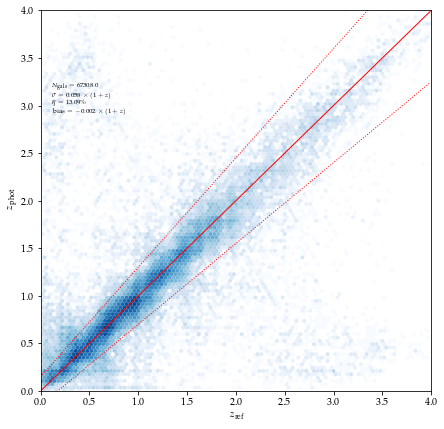

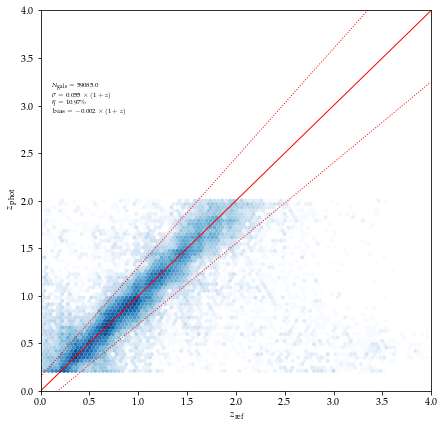

In [26]:
reload(photoz_metrics)

SELECT="(vis_obs_mag < 24.5) & (vis_obs_mag_err > 0.0)"
# SELECT="(vis_obs_mag < 22.5) & (vis_obs_mag_err > 0.0)"


# file_input = '{}/{}/pz_r.fits'.format(DATADIR, RESULTDIR)
file_input = '{}/fluxes_COSMOS15_West_test_vis24.5_pz_r.fits'.format(DATADIR)

print(file_input)

data_fix = photoz_metrics.read_data(
    file_input, select=SELECT, 
    input_type = 'ECLD_PHZ', 
    check_norm=False, 
    normalise=False,
    reject_outliers=False,
    )



# side-by-side version
if False:
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
    photoz_metrics.plot_scatter(
        data_fix['z_ref'], data_fix['z'], 
        0.0, 4.0, ax=ax1, density=False)
    photoz_metrics.plot_scatter(
        data_fix['z_ref'], data_fix['z'], 
        0.0, 4.0, ax=ax2, density=True)

    f, (ax1, ax2) = plt.subplots(1,2, figsize=(15,7))
    s = (0.2 < data_fix['z']) & (data_fix['z'] < 2.0)
    photoz_metrics.plot_scatter(
        data_fix['z_ref'][s], data_fix['z'][s], 
        0.0, 4.0, ax=ax1, density=False)
    photoz_metrics.plot_scatter(
        data_fix['z_ref'][s], data_fix['z'][s], 
        0.0, 4.0, ax=ax2, density=True)

# only density
f, (ax2) = plt.subplots(1,1, figsize=(7,7))
#photoz_metrics.plot_scatter(
#    data_fix['z_ref'], data_fix['z'], 
#    0.0, 4.0, ax=ax1, density=False)
photoz_metrics.plot_scatter(
    data_fix['z_ref'], data_fix['z'], 
    0.0, 4.0, ax=ax2, density=True)

f.savefig('../plots/zp_zref_fixed_all.pdf')

f, (ax2) = plt.subplots(1,1, figsize=(7,7))
s = (0.2 < data_fix['z']) & (data_fix['z'] < 2.0)
#photoz_metrics.plot_scatter(
#    data_fix['z_ref'][s], data_fix['z'][s], 
#    0.0, 4.0, ax=ax1, density=False)
photoz_metrics.plot_scatter(
    data_fix['z_ref'][s], data_fix['z'][s], 
    0.0, 4.0, ax=ax2, density=True)

f.savefig('../plots/zp_zref_fixed_0_2_2_0.pdf')


Reading /Users/coupon/data/euclid/varTrans/fluxes_COSMOS15_West_test_vis24.5_pz_r.fits...Done
Applying selection: (data['vis_obs_mag'] < 24.5) & (data['vis_obs_mag_err'] > 0.0)
Renormalising PDFs...Done
Rejecting potential outliers...Done (rejected 8654/67396 PDFs (12.8405246602%).


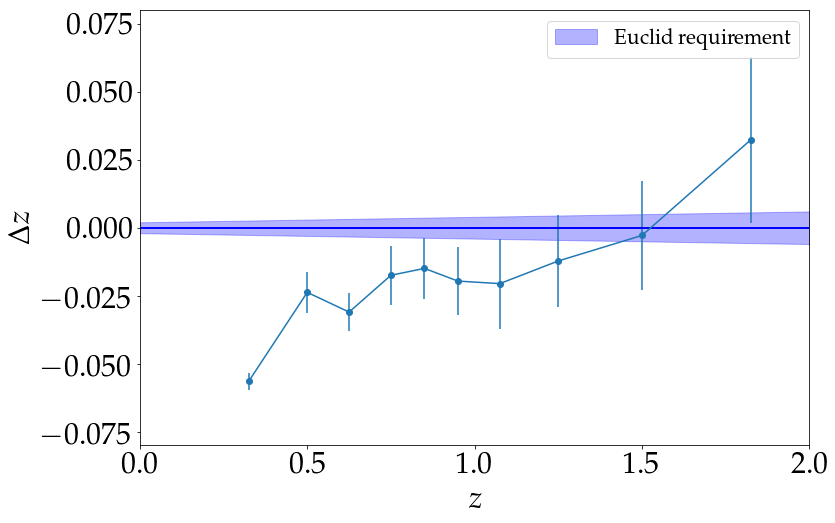

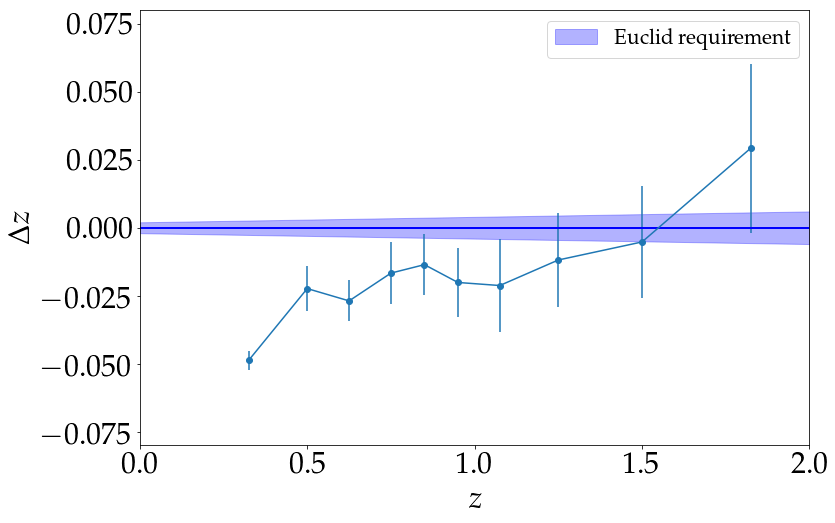

In [394]:
# bias
f, (ax2) = plt.subplots(1,1)
photoz_metrics.plot_bias(
    data_fix['z_ref'], 
    data_fix['z'], 
    data_fix['PDF'], 
    data_fix['PDF_bins'], ax=ax2)

f.savefig('../plots/mean_z_fixed_all.pdf')

data_fix_no_outliers = photoz_metrics.read_data(
    file_input, select=SELECT, 
    input_type = 'ECLD_PHZ', 
    check_norm=False, 
    normalise=True,
    reject_outliers=True,
    )


f, (ax2) = plt.subplots(1,1)
photoz_metrics.plot_bias(
    data_fix_no_outliers['z_ref'], 
    data_fix_no_outliers['z'], 
    data_fix_no_outliers['PDF'], 
    data_fix_no_outliers['PDF_bins'], ax=ax2)

f.savefig('../plots/mean_z_fixed_all_no_outliers.pdf')

The top figure shows the comparison for the full galaxy sample (i.e. all redshifts) cut at vis$<24.5$. The bottom figure shows the comparison with a additional cut in redshift $0.2<z<2.0$ corresponding to the limits of the shear sample.

The statistics shown in the figures are computed on the "spec-$z$" sample (the subset matching the real galaxies having a spec-$z$) using the weights calculated to represent the full population and given a cut at $\mathrm{vis}<24.5$, SNR$>10$ and $0.2<z<2.0$ to match the shear sample. They are expressed for the point estimates (the median redshift of the PDFs) and slightly differ from the metric defined by OU-PHZ which are based on the stacked PDFs. Nevertheless, these statistics suggest the photo-$z$'s meet the requirements ($\sigma < 0.05\times(1+z)$ and $\eta < 10\%$) and are therefore well suited for our tests.

### Mean redshift

In the example below we show the stacked PDFs in the redshift interval $0.5<z<0.6$. 

Starting from now and for the rest of the note, galaxies are no longer weighted. This is to avoid the dispersion caused by the weighting scheme when splitting per redshift bins. This point will be addressed later, by running the simulations on the full sample.

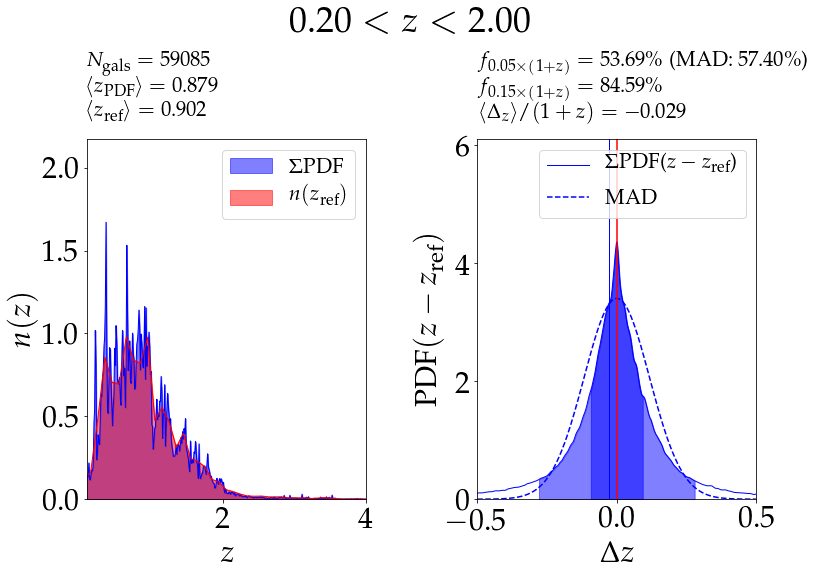

In [49]:
# reload(photoz_metrics)

# plot PDF stats
photoz_metrics.plot_PDF(
        data_fix['z_ref'], data_fix['z'], data_fix['PDF'],
        data_fix['PDF_bins'], z_bins=[0.2,2.0], 
        file_output='../plots/PDF_metric.pdf')

#fig.suptitle(r'$0.5<z<0.6$, fixed transmissions')

The left-hand plot shows the redshift distribution for the true redhsifts (histogram of the point estimates), in red, and the sum of the estimated PDFs in blue. 

The right-hand panel shows the stacked PDF shifted with respect to the true value. The various statistics correspond the metric define by OU-PHZ for measuring the photo-z performances on PDFs.

The mean redshift bias is shown as the $\Delta z$ value.

## Photo-$z$ performances for the variable transmissions 

In this section we compare the fixed-transmission quantities versus those computed with the variable transmissions.

###  Flux differences

We first show the difference in magnitudes caused by the variable transmissions as a function of redshift. For this we compare the $r$-band fluxes computed in the variable transmissions in the three most extreme cases (shifted by -100 Angstroms, stretch by 3\%, a tilt of -15\% and a softening of 0.8$\sigma$), compared to the $r$-band fluxes computed in the fixed transmission.

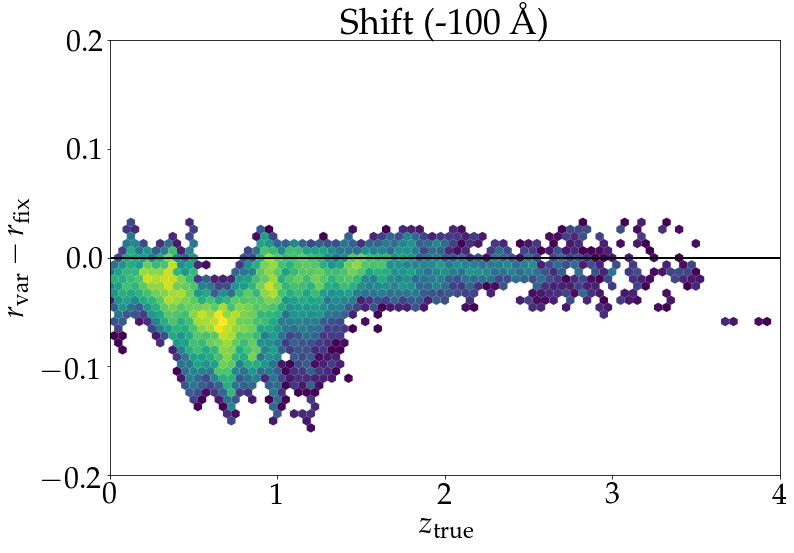

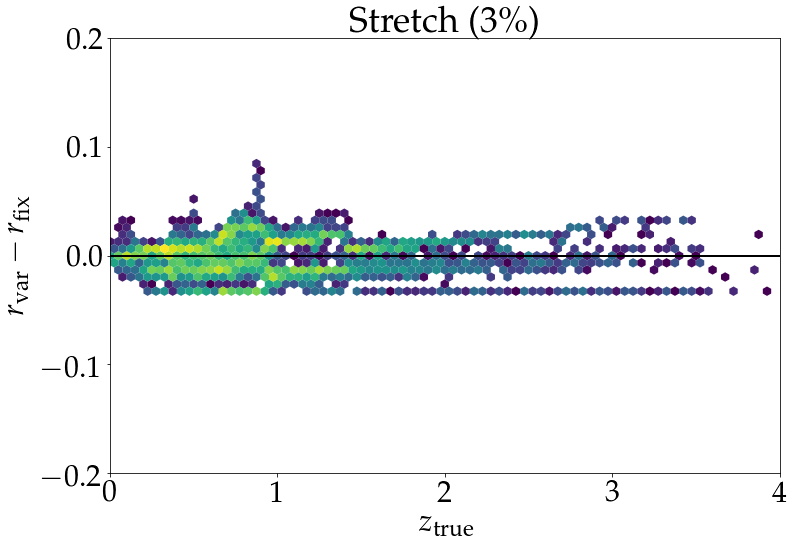

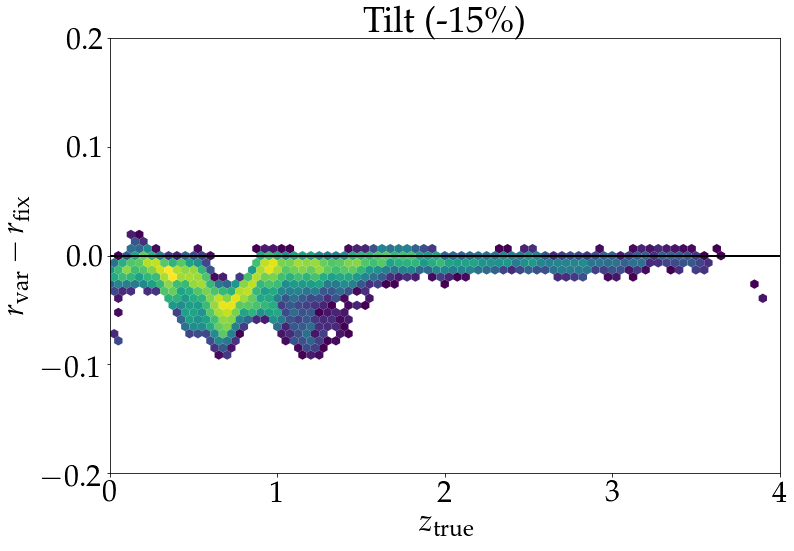

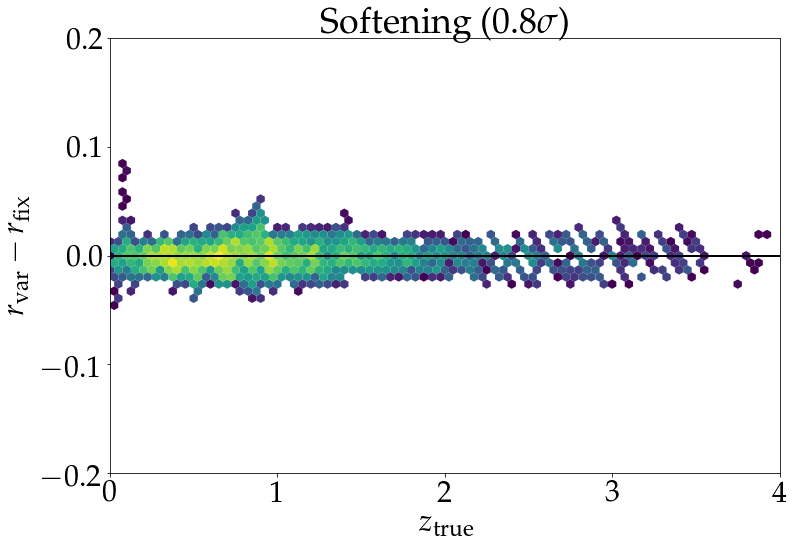

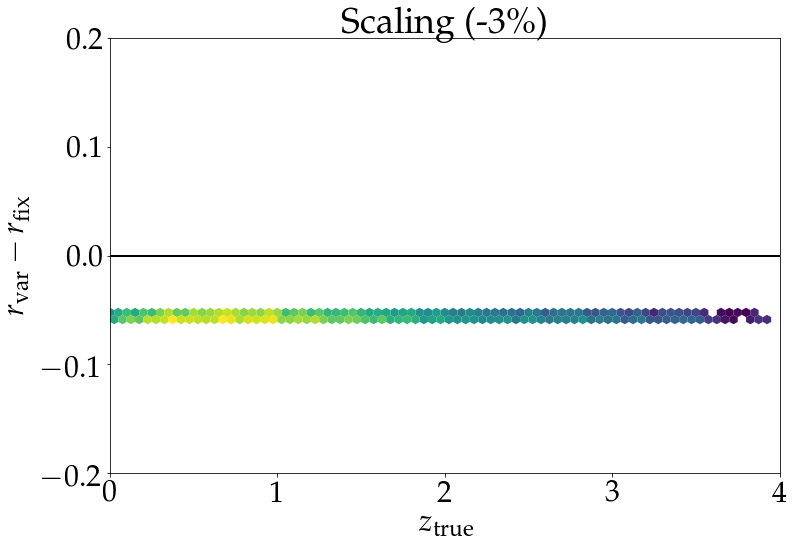

In [50]:
# plot mag differences

# import photometry catalogue and select shear sample
with fits.open(DATADIR+'/fluxes_COSMOS15_West_test_vis24.5.fits') as data:
     fluxes = data[1].data

zmin, zmax = 0.0, 4.0
maxDiff = 0.2

name = {'shift0': 'Shift (-100~\AA{})',
       'stretch9': 'Stretch (3\%)',
       'tilt0' : 'Tilt (-15\%)',
       'softening9' : 'Softening (0.8$\sigma$)',
       'scaling0' : 'Scaling (-3\%)'
       }

for var in ['shift0', 'stretch9', 'tilt0', 'softening9', 'scaling0'] :
    
    # diff = fluxes['r_obs_mag']-fluxes['r_'+var+'_obs_mag']
    diff = 2.5*np.log10(fluxes['r_'+var]/fluxes['r'])

    s = (fluxes['vis_obs_mag']<24.5) \
        & (fluxes['vis_obs_mag_err']<0.1) \
        & (abs(diff) < maxDiff) & (abs(diff) > 1.e-6) \
        & (zmin < fluxes['z_true']) & (fluxes['z_true'] < zmax)
    
    # bins='log',
    
    fig, ax = plt.subplots()
    hb = ax.hexbin(
        fluxes['z_true'][s], diff[s],
        gridsize=80, cmap='viridis', 
        mincnt=5, bins='log', 
        edgecolors=None, extent=(0.0, 4.0, -0.3,0.3))
    ax.axis([zmin, zmax, -maxDiff, +maxDiff])
    ax.plot([zmin, zmax], [0.0, 0.0], lw=2, c='black')

    ax.set_title(name[var])
    ax.set_xlabel(r'$z_\mathrm{true}$')
    ax.set_ylabel(r'$r_\mathrm{var}-r_\mathrm{fix}$')

    
    fig.savefig('../plots/mag_diff_{}.pdf'.format(var))

As expected, we see that the redshift range where the Balmer break goes through the $r$-band, i.e. $0.3<z<0.8$, is the most affected. The shift, due to our chosen range (-100 to +100 Angstroms) is the most problematic case, leading up to 0.1 magnitude difference at worst ($z\sim0.5$). The stretch has, on average, almost no impact, but this is also expected since in this experiment we neglect the calibration issues caused by the variable transmissions. The stretch will most ptrobably cause, however, addional scattering, but this is barely distinguishable from the statistical scatter in this figure.

Interestingly, the tilt seems to create a systematic shift similar to the shift in wavelength. This confirms what we saw previously when computing the moments of the transmission: the change in slope is causing a shift of the mean wavelength of the transmission.

### Scatter plot

We show the median redshift estimate versus the true redshift for the fixed-transmission case (left) and the variable-transmission case (right), here a shift of -100 Angstroms.

Reading /Users/coupon/data/euclid/varTrans/fluxes_COSMOS15_West_test_vis24.5_pz_r_shift0.fits...Done
Applying selection: (data['vis_obs_mag'] < 24.5) & (data['vis_obs_mag_err'] > 0.0)


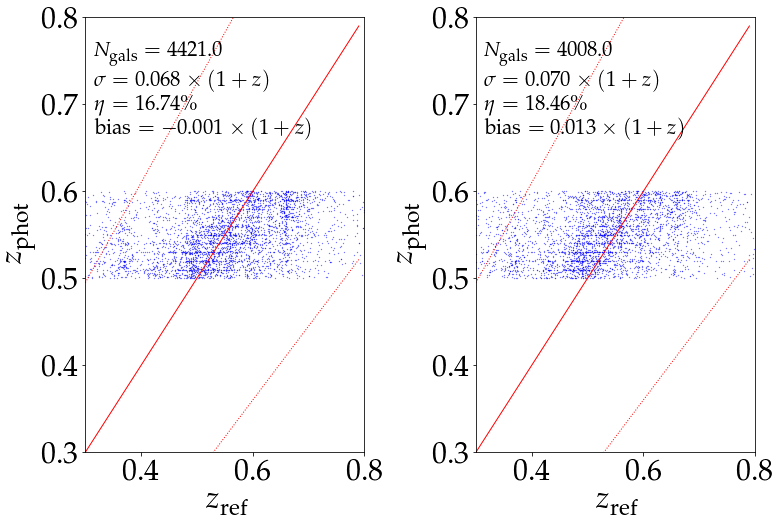

In [51]:
SELECT="(vis_obs_mag < 24.5) & (vis_obs_mag_err > 0.0)"

file_input = '{}/fluxes_COSMOS15_West_test_vis24.5_pz_r_shift0.fits'.format(DATADIR)
data_var = photoz_metrics.read_data(
    file_input, select=SELECT, 
    input_type = 'ECLD_PHZ', 
    check_norm=False)

fig, ax = plt.subplots(1,2)

s = (0.5 < data_fix['z']) & (data_fix['z'] < 0.6)
photoz_metrics.plot_scatter(
    data_fix['z_ref'][s], data_fix['z'][s], 
    0.3, 0.8, ax=ax[0], density=False)

s = (0.5 < data_var['z']) & (data_var['z'] < 0.6)
photoz_metrics.plot_scatter(
    data_var['z_ref'][s], data_var['z'][s], 
    0.3, 0.8, ax=ax[1], density=False)

fig.subplots_adjust(wspace=0.4)
fig.savefig('../plots/zp_zref_zoom.pdf')

The shift in the transmission causes a systematic shift in the redshift. The target fluxes are affected by a blue shift (-100 Angstroms), causing an artificial red shift of the SEDs, which explains why the true redshift is shifted towards lower values.

### Mean redshift

The figure below shows the stacked PDF in the variable transmission case.

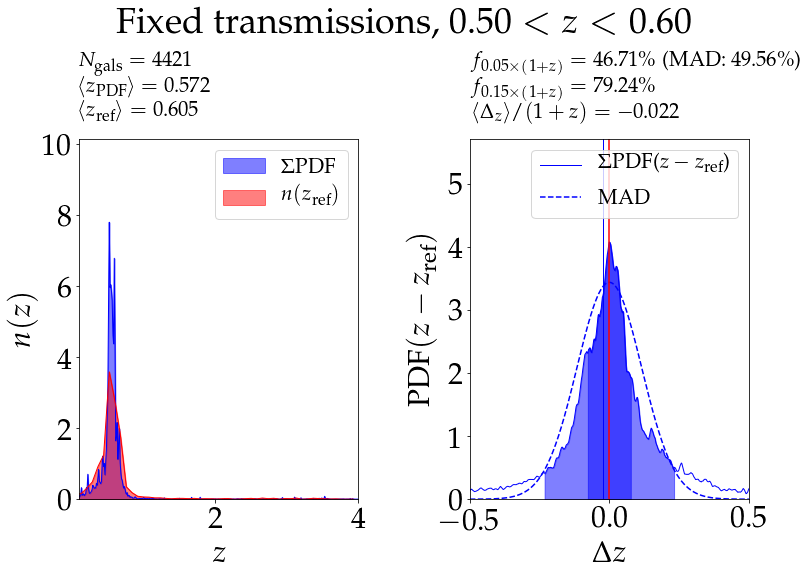

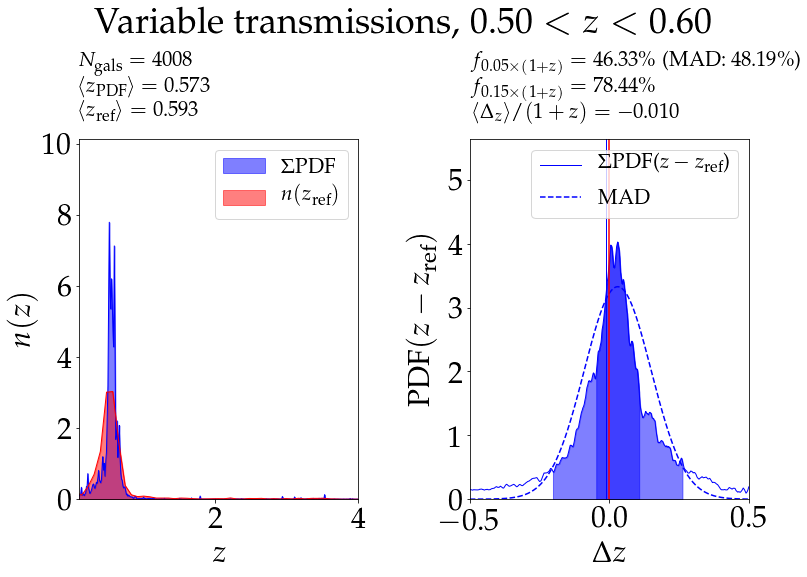

In [52]:
# reload(photoz_metrics)

# plot PDF stats - fixed transmissions
photoz_metrics.plot_PDF(
        data_fix['z_ref'], data_fix['z'], data_fix['PDF'], 
        data_fix['PDF_bins'], z_bins=[0.5,0.6], 
        title='Fixed transmissions, ', 
        file_output='../plots/PDF_metric_example_fixed.pdf',
    )

# plot PDF stats - variable transmissions
photoz_metrics.plot_PDF(
        data_var['z_ref'], data_var['z'], data_var['PDF'], 
        data_var['PDF_bins'], z_bins=[0.5,0.6], 
        title='Variable transmissions, ',
        file_output='../plots/PDF_metric_example_var.pdf',
)

Similarly to the scatter plot, a clear systematic mean redshift shift is seen, both for the redshift distribution and the stacked PDFs.

In the next figures we show $\Delta z_\mathrm{var}$ as a function of redshift, for the shift, the widening and the skewing of the transmission. In each case we only show the two extreme cases as well as the middle case which corresponds as the smallest variation.

In [53]:
def plot_delta_z_redshift(
        var_name, var_values, var_units,
        result_file='fluxes_COSMOS15_West_test_vis24.5'):
    """ Plot delta z = <z_var> - <z_fix> """
    
    dz_mean_fix = 0.0
    for i in range(N_SAMPLES):
        data_fix = pd.read_csv(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_PDF_tomo.csv')
        dz_mean_fix += (data_fix['zmean']-data_fix['zmean_ref'])
    dz_mean_fix /= N_SAMPLES

    bins_center = (data_fix['zmin']+data_fix['zmax'])/2.0

    N_var = len(var_values)
            
    # initialise figure
    fig, ax = plt.subplots()

    ax.set_title(var_name.title())

    ax.set_ylim((-0.03,0.03))
    ax.set_xlim((0.0,2.0))
    
    ax.plot([0.0,2.0],[0.0,0.0], c='blue', lw=2)
    
    ax.fill_between(
        [0.0,2.0], [-0.002*(1.0+0.0),-0.002*(1.0+2.0)], 
        [+0.002*(1.0+0.0),+0.002*(1.0+2.0)], 
        color='blue', alpha=0.3, label='Euclid requirement')
    
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\Delta z_\mathrm{var}$')
            
    fac = 1.0
    if var_name == 'stretch' or var_name == 'tilt' or var_name == 'scaling':
        fac = 100.0
    
    # plot two extremes and middle one
    for n in [0, 5, 9]:
        # dz_mean_var = 0.0
        result = np.zeros((N_SAMPLES, N_var))
        for i in range(N_SAMPLES):
            data_var = pd.read_csv(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_'+var_name+str(n)+'_PDF_tomo.csv')
            result[i, :] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix
        
        dz_mean_var = np.mean(result, axis=0)
        dz_mean_var_err = np.sqrt(2.)*np.std(result, axis=0)/np.sqrt(N_SAMPLES)

        ax.errorbar(
            bins_center, dz_mean_var, yerr=dz_mean_var_err, label=r'{0:+.1f}{1}'.format(
                var_values[n]*fac, var_units), marker='o') 
    ax.legend(fontsize='x-small')
    
    fig.savefig('../plots/delta_z_redshift_'+var_name+'.pdf')
     
    return

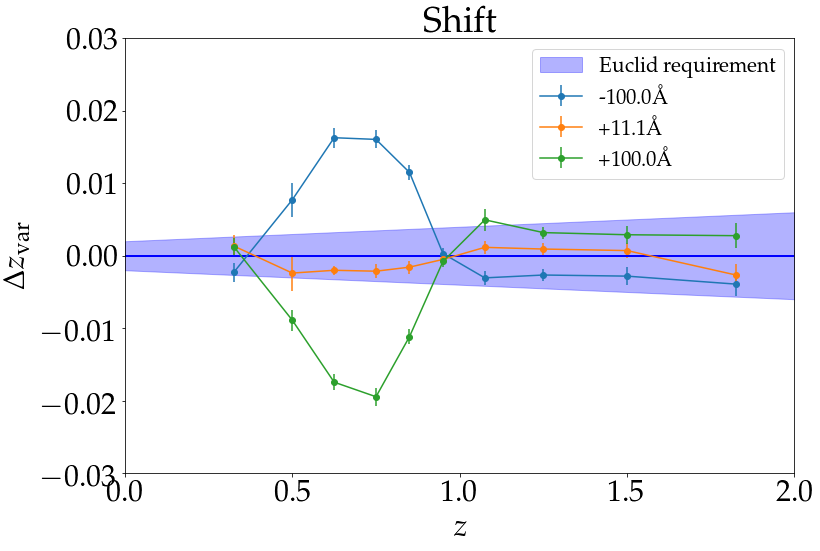

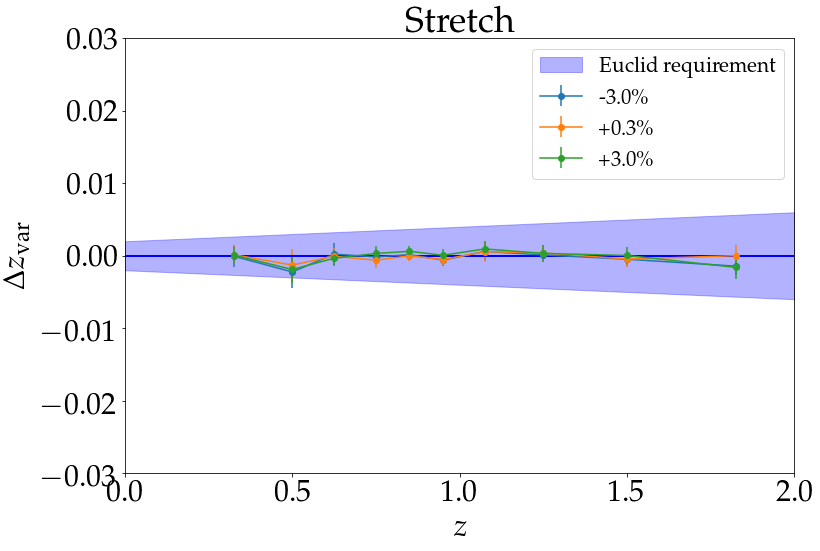

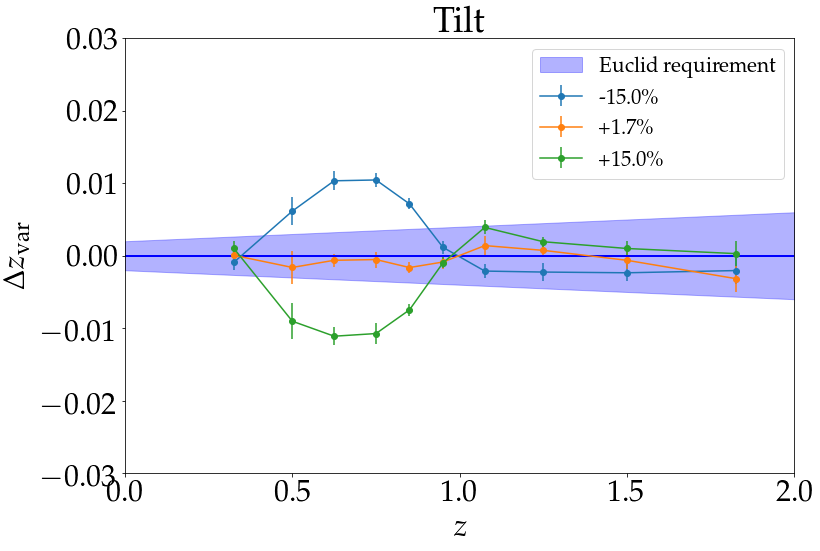

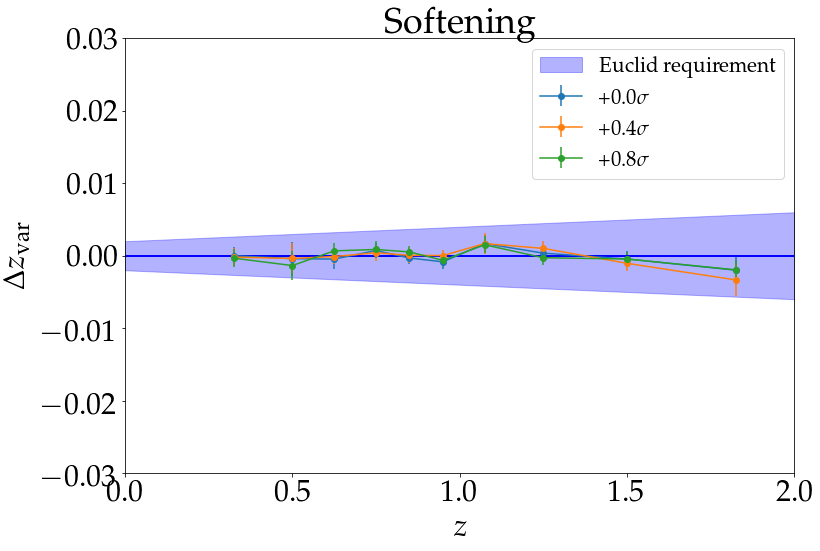

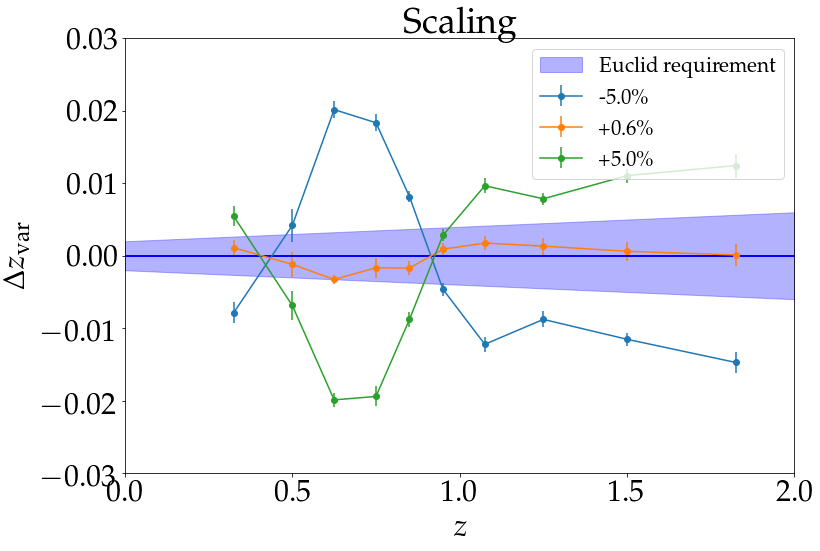

In [54]:
for var_name in ['shift', 'stretch', 'tilt', 'softening', 'scaling']:
    plot_delta_z_redshift(var_name, VAR_VALUES[var_name],VAR_UNITS[var_name])

The results above confirm the trends observed in provious sections, and we can already conclude that the shift is the most problematic issue, whereas the impact from widening and the skewing remains lower. As stated above the effect from the skewing shows a similar behaviour as the shift.

Finally we focus on the redshift range that is most impacted, $0.55 < z < 0.7$ and we show $\Delta z_\mathrm{var}$ as a function of the different simulated variations.

In [55]:
def plot_delta_z_var(
        var_name, var_values, var_units,
        result_file='fluxes_COSMOS15_West_test_vis24.5'):
    """ Plot delta z = <z_var> - <z_fix> """
    
    # fixed transmission (reference)
    dz_mean_fix = 0.0
    for i in range(N_SAMPLES):
        data_fix = pd.read_csv(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_PDF_z0.63.csv')
        dz_mean_fix += (data_fix['zmean']-data_fix['zmean_ref'])
    dz_mean_fix /= N_SAMPLES
    
    bins_center = (data_fix['zmin']+data_fix['zmax'])/2.0

    one_plus_z = 1.0+bins_center[0]
    
    fac = 1.0
    if var_name == 'stretch' or var_name == 'tilt' or var_name == 'scaling':
        fac = 100.0

    # initialise figure
    fig, ax = plt.subplots(1,1)
    
    ax.set_title(var_name.title()+' ($z\sim0.63$)')
    ax.set_ylim((-0.03,0.03))
    xlim = ax.set_xlim((var_values[0]*fac,var_values[-1]*fac))
    ax.set_xlabel('{0} [{1}]'.format(var_name,var_units))
    ax.set_ylabel(r'$\Delta z_\mathrm{var}$')
    ax.plot(xlim,[0.0,0.0], c='blue', lw=2)

    ax.fill_between(
        xlim, [-0.002*one_plus_z,-0.002*one_plus_z], 
        [+0.002*one_plus_z,+0.002*one_plus_z], 
        color='blue', alpha=0.3, label='Euclid requirement')
     
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))   
        
    Deltaz = []
    Deltaz_err = []

    for n in range(len(var_values)):

        result = np.zeros(N_SAMPLES)
        for i in range(N_SAMPLES):
            data_var = pd.read_csv(
                DATADIR+'/'+result_file+'/'+str(i)
                +'_pz_r_'+var_name+str(n)+'_PDF_z0.63.csv')
            result[i] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix

        # N = data_var['N']
        dz_mean_var = np.mean(result, axis=0)
        dz_mean_var_err = np.std(result, axis=0)

        Deltaz.append(dz_mean_var)
        Deltaz_err.append(dz_mean_var_err/np.sqrt(N_SAMPLES))
    
    ax.errorbar(var_values*fac, Deltaz, yerr=Deltaz_err, marker='o', label='Measured')

    if var_name == 'shift':
        ax.plot(var_values, -var_values/4000.0/(1.5), label='Naive model')
    
    ax.legend(fontsize='x-small', loc='upper right')

    fig.set_tight_layout(True)

    fig.savefig('../plots/delta_z_var_'+var_name+'.pdf')

    
    return Deltaz, Deltaz_err

/Users/coupon/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


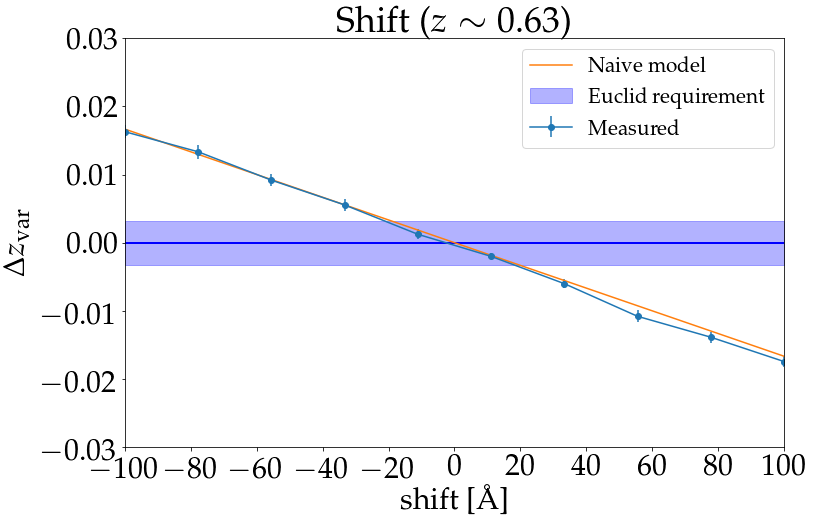

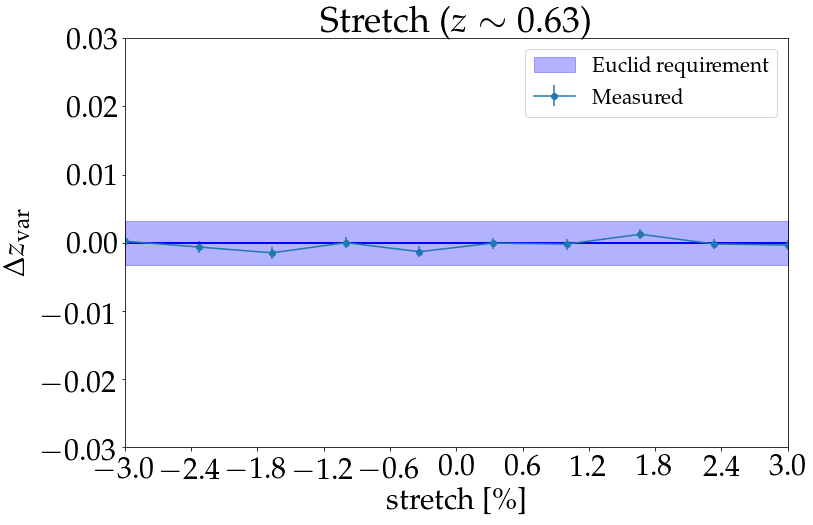

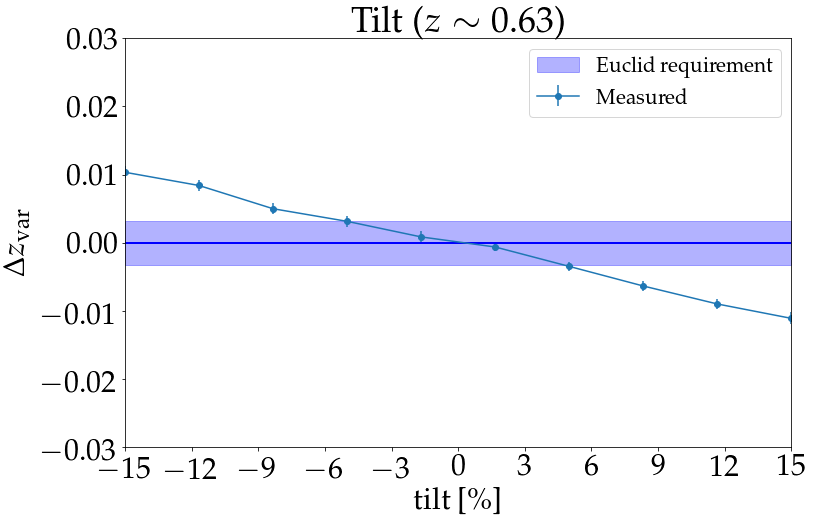

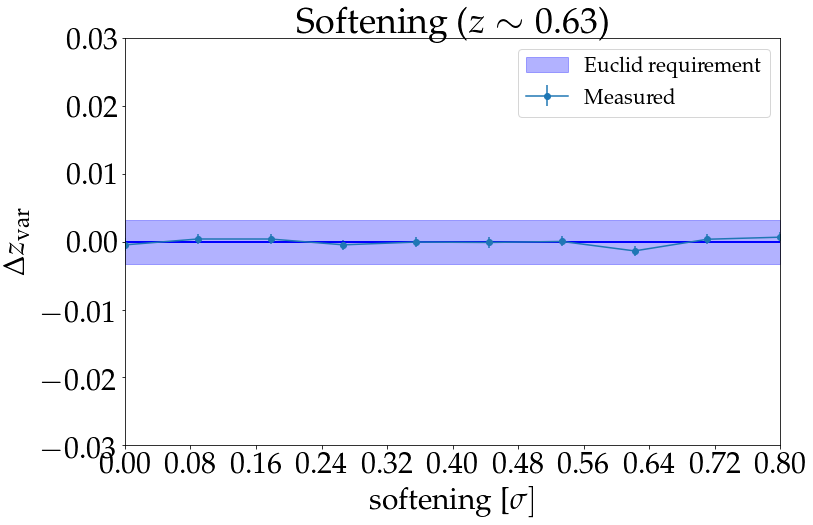

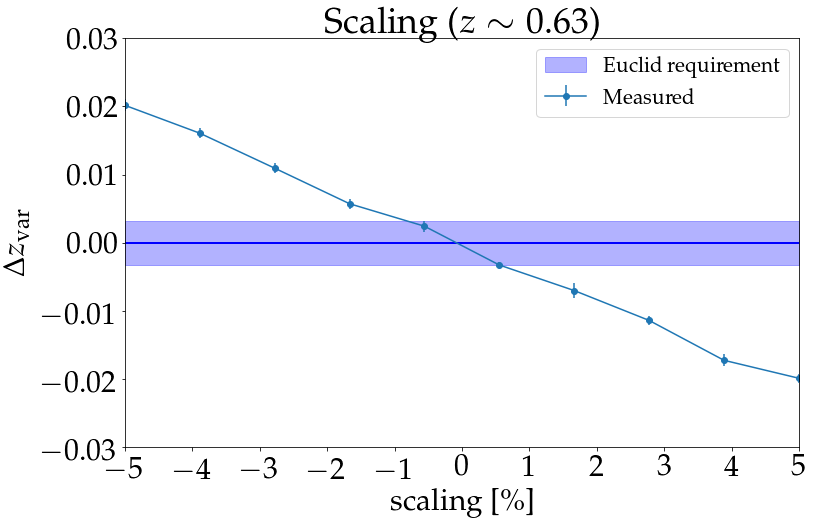

In [56]:
#for var_name in ['shift', 'widening', 'skewing', 'softening']:
#    plot_delta_z_var(var_name, var_values[var_name])

df_list = []
for var_name in ['shift', 'stretch', 'tilt', 'softening', 'scaling']:
    df = pd.read_csv('../results/trans_stats_{}.csv'.format(var_name))
    df['Deltaz'], df['Deltaz_err'] = plot_delta_z_var(
            var_name, VAR_VALUES[var_name], VAR_UNITS[var_name])
    df['var_name'] = [var_name]*10
    df_list.append(df)

# merge first moments and chi2
pd.concat(df_list).to_csv('../results/trans_stats_Deltaz.csv', index=False)

In [57]:
def plot_chi2_var(
        var_name, var_values, var_units,
        result_file='fluxes_COSMOS15_West_test_vis24.5'):
    """ Plot delta z = <z_var> - <z_fix> """
   
    # fixed transmission (reference)
    dz_mean_fix = 0.0
    for i in range(N_SAMPLES):
        data_fix = pd.read_csv(
            DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_PDF_tomo.csv')
        dz_mean_fix += (data_fix['zmean']-data_fix['zmean_ref'])
    dz_mean_fix /= N_SAMPLES
    
    bins_center = (data_fix['zmin']+data_fix['zmax'])/2.0

    one_plus_z = 1.0+bins_center
    
    fac = 1.0
    fac = 1.0
    if var_name == 'stretch' or var_name == 'tilt' or var_name == 'scaling':
        fac = 100.0

    # initialise figure
    fig, ax = plt.subplots(1,1)
    
    ax.set_title(var_name.title())
    ax.set_ylim((0.0,1100.0))
    # ax.set_ylim((1.,2000.0))
    # ax.set_yscale('log')
    
    xlim = ax.set_xlim((var_values[0]*fac,var_values[-1]*fac))
    ax.set_xlabel('{0} [{1}]'.format(var_name,var_units))
    ax.set_ylabel('\chi^2')
    # ax.plot(xlim,[0.0,0.0], c='blue', lw=2)

    ax.fill_between(
        xlim, [0.0, 0.0], [9.0, 9.0],
        color='blue', alpha=0.3, label='\chi^2=9.0')
    
    chi2 = []
    # Deltaz_err = []

    N_var = len(var_values)
    N_bins = len(bins_center)
    
    result = np.zeros(N_var)
    for n in range(N_var):
        result = np.zeros((N_SAMPLES, N_bins))
        for i in range(N_SAMPLES):
            data_var = pd.read_csv(
                DATADIR+'/'+result_file+'/'+str(i)
                +'_pz_r_'+var_name+str(n)+'_PDF_tomo.csv')
            result[i,:] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix
        # dz_mean = np.mean(dz, axis=0)
 
        dz_mean_var = np.mean(result, axis=0)
        dz_mean_var_err = np.std(result, axis=0)/np.sqrt(N_SAMPLES)

        chi2.append(np.sum(dz_mean_var**2/dz_mean_var_err**2))
        # Deltaz_err.append(dz_mean_var_err/np.sqrt(N_SAMPLES))
       
    ax.errorbar(var_values*fac, chi2, marker='o', label='Measured')
    ax.legend(fontsize='x-small', loc='upper right')
    
    return chi2


In [58]:
if False:
    df_list = []
    for var_name in ['shift', 'stretch', 'tilt', 'softening', 'scaling']:
        df = pd.read_csv('../results/trans_stats_{}.csv'.format(var_name))
        df['chi2'] = plot_chi2_var(var_name, VAR_VALUES[var_name], VAR_UNITS[var_name])
        df_list.append(df)

    # merge first moments and chi2
    pd.concat(df_list).to_csv('../results/trans_stats_chi2.csv', index=False)

The first figure above shows the linear dependence of the redshift bias as a function of the transmission shift. We overplotted the theoretical prediction assuming that the shift can be directly interpreted as an additional redshift on average. The two curves show very similar behaviour which confirms that a shift in wavelength can be directly translated into a redshift bias.

# Correction of the effect

In [59]:
def diff_mean(
        shift, lbd, trans, mean):
    """ Compute the difference in mean 
    after shifting the filter """
    
    shifted = shift_trans(lbd, trans, shift)
    return mean_trans(lbd, shifted) - mean

def diff_sigma(
        stretch, lbd, trans, sigma):
    """ Compute the difference in skewness 
    after tilting the filter """
    
    stretched = stretch_trans(lbd, trans, stretch)
    return std_trans(lbd, stretched) - sigma

def diff_skewness(
        tilt, lbd, trans, skewness):
    """ Compute the difference in skewness 
    after tilting the filter """
    
    tilted = tilt_trans(lbd, trans, tilt)
    return skewness_trans(lbd, tilted) - skewness

def diff_kurtosis(
        softening, lbd, trans, kurtosis):
    """ Compute the difference in mean 
    after shifting the filter """
    
    softened = softening_trans(lbd, trans, softening)
    return kurtosis_trans(lbd, softened) - kurtosis

def diff_kurtosis_abs(
        softening, lbd, trans, kurtosis):
    """ Compute the absolute difference in mean 
    after shifting the filter """
    
    return np.abs(diff_kurtosis(softening, lbd, trans, kurtosis))

def diff_moments(
        values, lbd, trans, moments):
    """ Compute the difference in moments 
    after altering the filter """
    
    result = np.abs(diff_mean(
        values[0], lbd, trans, moments['mean']))
    result += np.abs(diff_sigma(
        values[1], lbd, trans, moments['sigma']))
    result += np.abs(100.0*diff_skewness(
        values[2], lbd, trans, moments['skewness']))
    result += np.abs(100.0*diff_kurtosis(
        values[3], lbd, trans, moments['kurtosis']))

    print(result)
    
    return result

u -99.99999999999909
g -99.95725536936789
r -100.00000000000091
i -99.99663571267229
z -99.99507008248656
vis -99.99590385547162
Y -99.97582739335485
J -99.96903689447754
H -99.9964115349685
u -40.05115215892991
g -83.59069833323684
r -80.82271030315087
i -90.54672316075545
z -77.81351596503407
vis -208.51241312007664
Y -150.2229899332874
J -233.88086484374207
H -290.1571049557283
u -0.034513127366381346
g -2.498328912109918
r -0.11979239725221201
i 0.4616257802982326
z 1.317827502935351
vis -0.1077350960884842
Y -0.5411743566304895
J -0.14114135485500906
H -0.11431435031467434
u -0.009882033486087405
g 0.2778241818266025
r -0.015815023887908675
i 0.04858818720772273
z 0.16870712502648466
vis -0.013883306408112528
Y 0.057436797986781585
J -0.01192100082503833
H -0.01537996541597808


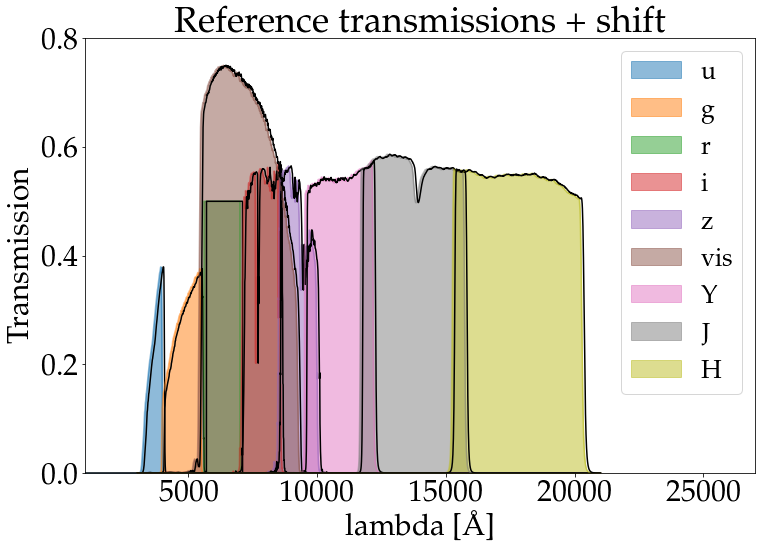

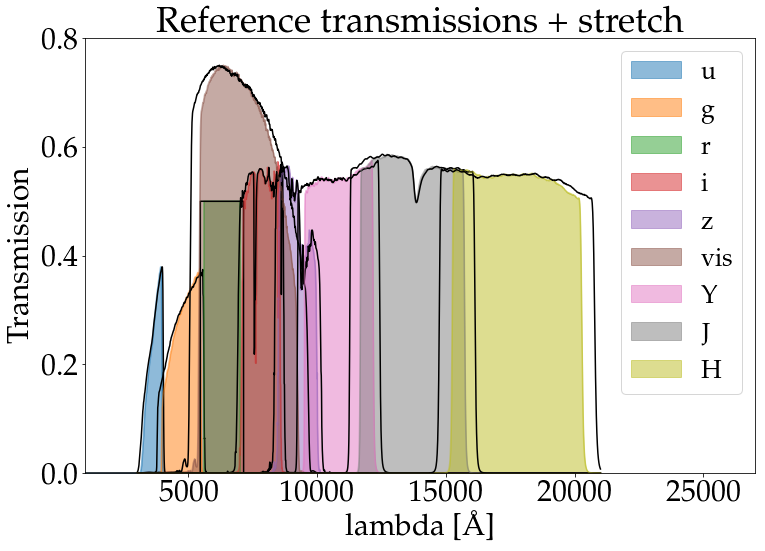

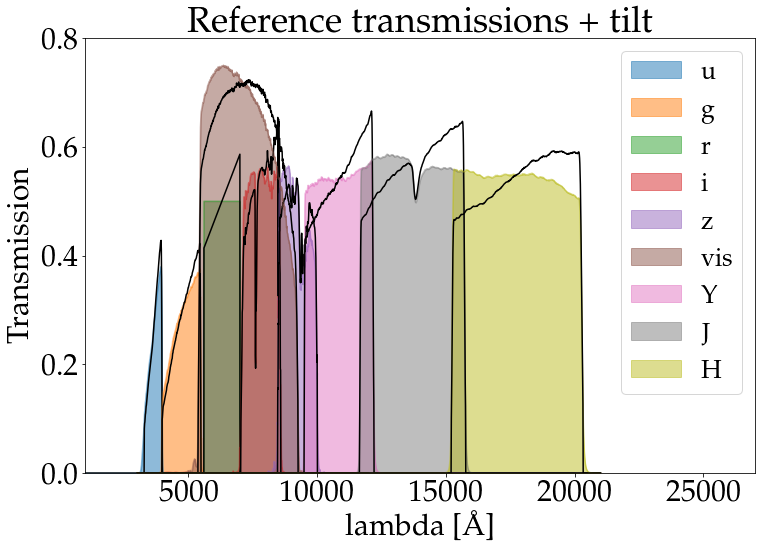

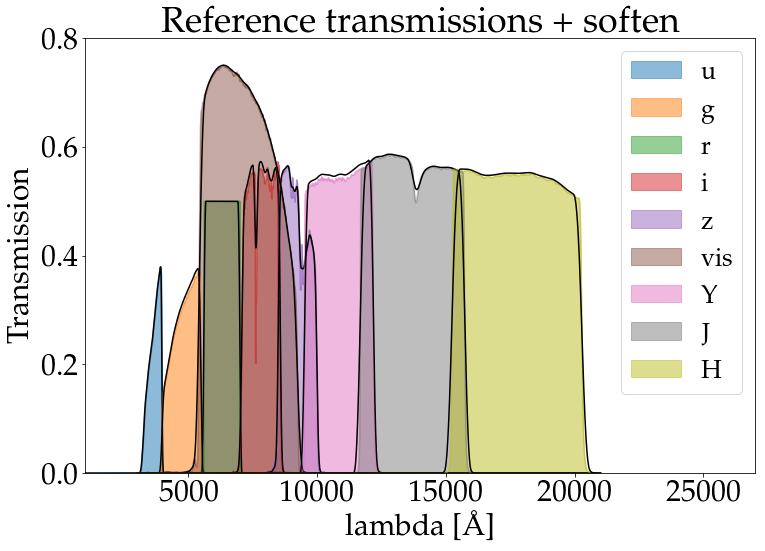

In [60]:
if True:

    functions_vary = {
        'shift': shift_trans,
        'stretch': stretch_trans, 
        'tilt': tilt_trans,
        'soften': softening_trans}
    functions_meas = {
        'shift': mean_trans,
        'stretch': std_trans, 
        'tilt': skewness_trans,
        'soften': kurtosis_trans}
    values = {
        'shift': 100.0,
        'stretch': 0.2, 
        'tilt': 0.1,
        'soften': 0.2}

    for variation in ['shift', 'stretch', 'tilt', 'soften']:
        fig, ax = plt.subplots()
        for f in filter_ref_names:
            filter_dfs[f].plot.area(
                x='lambda', stacked=False,
                title='Reference transmissions + '+variation, 
                    ax=ax)

            new_filter = functions_vary[variation](
                filter_dfs[f]['lambda'], 
                filter_dfs[f][f], values[variation])

            diff =  functions_meas[variation](
                    filter_dfs[f]['lambda'], filter_dfs[f][f]) \
                - functions_meas[variation](
                    filter_dfs[f]['lambda'], new_filter)

            print(f, diff)

            ax.plot(filter_dfs[f]['lambda'], new_filter, color='black')

        ax.set_xlabel(r'lambda [\AA{}]')
        ax.set_ylabel('Transmission')

        # adjust plot
        ax.set_ylim((0.0,0.8))
        ax.set_xlim([1000,27000])
        plt.legend(loc='upper right', fontsize='small') #, bbox_to_anchor=(1.0, 1.0))


## Corrected transmission

We describe here how we correct the variable transmissions.

In [61]:
def correct_trans(
        lbd_ref, trans_ref,
        lbd_target, trans_target):
    """ Correct the reference filter so that
    the first moments will match that of the 
    target filter """
    
    moments_target = moments_trans(
        lbd_target, trans_target)
    moments_ref = moments_trans(
        lbd_ref, trans_ref)   
    
    if False:
        for k in moments_ref:
            print(k, moments_target[k]-moments_ref[k])
        
    result = trans_ref
    
    # compute the shift needed
    # to match the target
    # transmission mean
    shift = diff_mean(
        0.0, lbd_ref, result, moments_target['mean']) 

    # apply shift
    result = shift_trans(lbd_ref, result, -shift)
    
    moments_result = moments_trans(
        lbd_ref, result)

    if False:
        for k in moments_ref:
            print(k, moments_result[k]-moments_target[k])
    
    return result

In [62]:
p = re.compile('shift|tilt')
for filter_name in filter_var_names:
    if p.search(filter_name):
        print(filter_name)
filter_var_df.keys()

r_shift0
r_shift1
r_shift2
r_shift3
r_shift4
r_shift5
r_shift6
r_shift7
r_shift8
r_shift9
r_tilt0
r_tilt1
r_tilt2
r_tilt3
r_tilt4
r_tilt5
r_tilt6
r_tilt7
r_tilt8
r_tilt9


Index([u'lambda', u'trans', u'shift0', u'stretch0', u'tilt0', u'softening0',
       u'shift1', u'stretch1', u'tilt1', u'softening1', u'shift2', u'stretch2',
       u'tilt2', u'softening2', u'shift3', u'stretch3', u'tilt3',
       u'softening3', u'shift4', u'stretch4', u'tilt4', u'softening4',
       u'shift5', u'stretch5', u'tilt5', u'softening5', u'shift6', u'stretch6',
       u'tilt6', u'softening6', u'shift7', u'stretch7', u'tilt7',
       u'softening7', u'shift8', u'stretch8', u'tilt8', u'softening8',
       u'shift9', u'stretch9', u'tilt9', u'softening9'],
      dtype='object')

In [64]:
# filter_to_correct_names = ['shift{}'.format(i) for i in range(VAR_N)]
# filter_to_correct_names += ['tilt{}'.format(i) for i in range(VAR_N)]

# create corrected transmissions directory
OUPUTDIR=CURRENTDIR+'/filters/corrected'
if not os.path.exists(OUPUTDIR):
    os.makedirs(OUPUTDIR)

# create new filters to correct for
# the variable transmissions
# only do it for tilt and shift
# variations

# start with r-band variations
# ref_name = 'r'
p = re.compile('shift|tilt')

filter_corr_dfs = {}
for filter_name in filter_var_names:
    if p.search(filter_name):
        #print(filter_name)
        
        ref_name = filter_name.split('_')[0]
        var_name = filter_name.split('_')[1]
        
        lbd_ref = filter_dfs[ref_name]['lambda'].values
        trans_ref = filter_dfs[ref_name][ref_name].values
        trans_var = filter_var_df[var_name].values

        trans_corr = correct_trans(
            lbd_ref, trans_ref,
            lbd_ref, trans_var)

        name = '{}_corr'.format(filter_name)

        filter_corr_dfs[name] = pd.DataFrame(
            {'lambda': lbd_ref, filter_name: trans_corr})

        filter_corr_dfs[name].to_csv(
            OUPUTDIR+'/'+filter_name+'_corr.ascii', 
            columns=['lambda', filter_name], 
            sep=' ', index=False, header=False)

# then ran variation in all filters
# create directory to put randomly 
# varied transmissions
OUPUTDIR = CURRENTDIR+'/filters/ran'
if not os.path.exists(OUPUTDIR):
    os.makedirs(OUPUTDIR)

ran_id = 0    

filter_ran_dfs = {}

np.random.seed(seed=20091982)
for f in filter_ref_names:
    lbd_ref = filter_dfs[f]['lambda'].values
    trans_ref = filter_dfs[f][f].values
   
    diff = 101.0
    while abs(diff) > 100.0:
        tilt_ran = np.random.uniform(-0.15, +0.15)
        shift_ran = np.random.uniform(-100.0, +100.0)

        trans_ran = tilt_trans(lbd_ref, trans_ref, tilt_ran)
        trans_ran = shift_trans(lbd_ref, trans_ran, shift_ran)

        diff = mean_trans(lbd_ref, trans_ref) \
            - mean_trans(lbd_ref, trans_ran)
    
    trans_corr = correct_trans(
        lbd_ref, trans_ref,
        lbd_ref, trans_ran)
   
    diff_corr = mean_trans(lbd_ref, trans_ran) \
        - mean_trans(lbd_ref, trans_corr)
    
    print(
        '{0}: mean diff = {1:.2f} (corrected = {2:.2f})'.format(
            f, diff, diff_corr))
    
    filter_ran_dfs['{}_ran{}'.format(f, ran_id)] = pd.DataFrame(
        {'lambda': lbd_ref, f: trans_ran})
    filter_corr_dfs['{}_ran{}_corr'.format(f, ran_id)] = pd.DataFrame(
        {'lambda': lbd_ref, f: trans_corr})

    filter_ran_dfs['{}_ran{}'.format(f, ran_id)].to_csv(
        '{}/filters/ran/{}_ran{}.ascii'.format(CURRENTDIR, f, ran_id), 
        columns=['lambda', f], 
        sep=' ', index=False, header=False)

    filter_corr_dfs['{}_ran{}_corr'.format(f, ran_id)].to_csv(
        '{}/filters/corrected/{}_ran{}_corr.ascii'.format(CURRENTDIR, f, ran_id), 
        columns=['lambda', f], 
        sep=' ', index=False, header=False)

with open(CURRENTDIR+'/filters/filterListRan.ascii', 'w') as file_out: 
    for f in filter_ref_names:
        file_out.write(
            '{}/filters/ran/{}_ran{}.ascii'.format(
                CURRENTDIR, f, ran_id)+'\n')
    
with open(CURRENTDIR+'/filters/filterListCorrected.ascii', 'w') as file_out: 
    for filter_name in filter_var_names:
        if p.search(filter_name):

            file_out.write(
                '{}/filters/corrected/{}_{}_corr.ascii'.format(
                    CURRENTDIR, ref_name, f, ran_id)+'\n')
    for f in filter_ref_names:
        file_out.write(
            '{}/filters/corrected/{}_ran{}_corr.ascii'.format(
                CURRENTDIR, f, ran_id)+'\n')

u: mean diff = -8.59 (corrected = 0.00)
g: mean diff = -11.54 (corrected = 0.00)
r: mean diff = -41.48 (corrected = 0.00)
i: mean diff = 10.51 (corrected = -0.00)
z: mean diff = 73.45 (corrected = -0.00)
vis: mean diff = -0.59 (corrected = 0.00)
Y: mean diff = -65.46 (corrected = 0.02)
J: mean diff = 82.76 (corrected = 0.00)
H: mean diff = 1.78 (corrected = -0.00)


In [65]:
filter_corr_dfs.keys()

['i_ran0_corr',
 'J_ran0_corr',
 'r_shift1_corr',
 'r_tilt4_corr',
 'r_tilt5_corr',
 'r_shift0_corr',
 'H_ran0_corr',
 'r_tilt8_corr',
 'r_ran0_corr',
 'r_shift7_corr',
 'r_tilt2_corr',
 'r_tilt3_corr',
 'r_shift6_corr',
 'Y_ran0_corr',
 'r_shift3_corr',
 'r_tilt6_corr',
 'r_tilt7_corr',
 'r_shift2_corr',
 'z_ran0_corr',
 'vis_ran0_corr',
 'g_ran0_corr',
 'u_ran0_corr',
 'r_tilt9_corr',
 'r_tilt1_corr',
 'r_shift4_corr',
 'r_shift8_corr',
 'r_shift5_corr',
 'r_tilt0_corr',
 'r_shift9_corr']

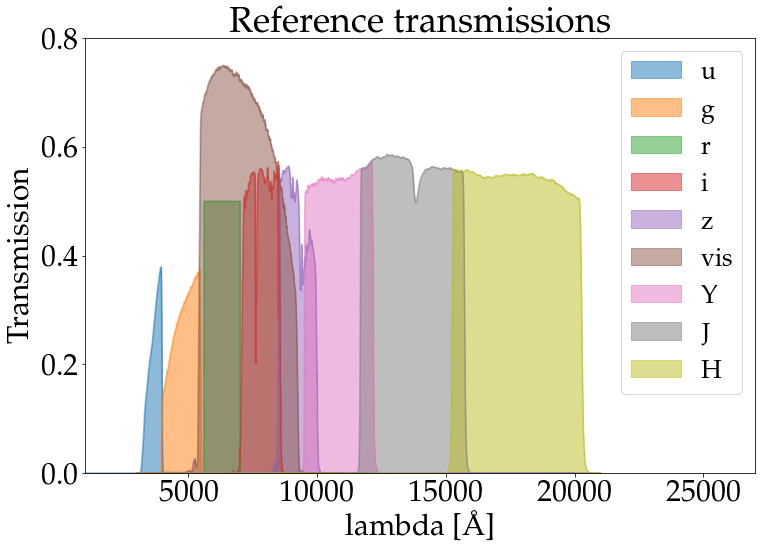

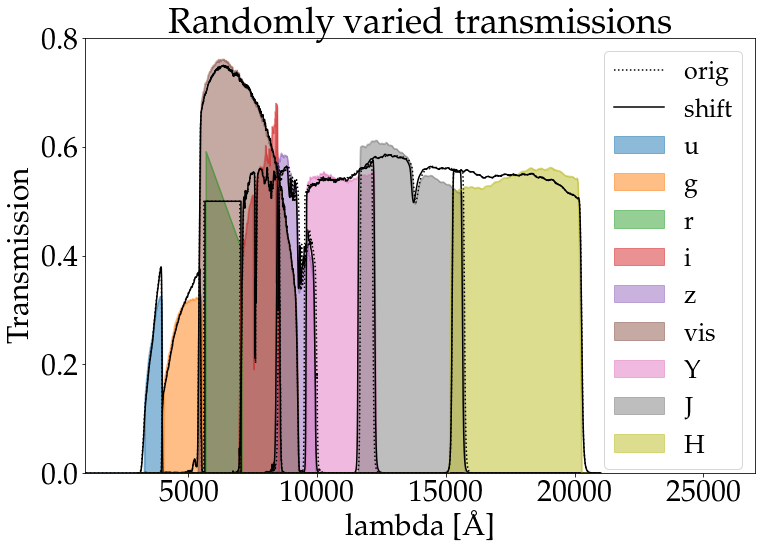

In [66]:
fig, ax = plt.subplots()
for f in filter_ref_names:
    filter_dfs[f].plot.area(
        x='lambda', stacked=False, 
        title='Reference transmissions', ax=ax)

ax.set_xlabel(r'lambda [\AA{}]')
ax.set_ylabel('Transmission')

# adjust plot
ax.set_ylim((0.0,0.8))
ax.set_xlim([1000,27000])
plt.legend(loc='upper right', fontsize='small') #, bbox_to_anchor=(1.0, 1.0))

ran_id = 0    

fig, ax = plt.subplots()
for f in filter_ref_names:
    name = '{}_ran{}'.format(f, ran_id)
    filter_ran_dfs[name].plot.area(
        x='lambda', stacked=False, 
        title='Randomly varied transmissions', ax=ax)

    name = '{}_ran{}_corr'.format(f, ran_id)
    ax.plot(filter_corr_dfs[name]['lambda'], filter_corr_dfs[name], color='black')

    name = '{}'.format(f, ran_id)
    ax.plot(filter_dfs[name]['lambda'], filter_dfs[name], color='black', ls=':')


ax.plot([], [], color='black', label='orig', ls=':')
ax.plot([], [], color='black', label='shift')
    
ax.set_xlabel(r'lambda [\AA{}]')
ax.set_ylabel('Transmission')

# adjust plot
ax.set_ylim((0.0,0.8))
ax.set_xlim([1000,27000])
plt.legend(loc='upper right', fontsize='small') #, bbox_to_anchor=(1.0, 1.0))
None

In [67]:
# directory with the reference galaxies' SEDs
refdir = os.environ['HOME']+'/data/NNPZ/COSMOS/v2.0/referenceSample'
filters = CURRENTDIR+'/filters/filterListCorrected.ascii'

# output files with all fluxes
output = DATADIR+'/fluxes_corrected.fits'

# run shell command to compute photometry
! NnpzBuildPhotometry --sample-dir {refdir} --filter {filters} \
    --out-file {output} --out-type F_nu_uJy
    
filters = CURRENTDIR+'/filters/filterListRan.ascii'

# output files with all fluxes
output=DATADIR+'/fluxes_ran.fits'

# run shell command to compute photometry
! NnpzBuildPhotometry --sample-dir {refdir} --filter {filters} \
    --out-file {output} --out-type F_nu_uJy

ERROR: File /Users/coupon/data/euclid/varTrans/fluxes_corrected.fits already exists
ERROR: File /Users/coupon/data/euclid/varTrans/fluxes_ran.fits already exists


In [68]:
def add_corr_to_file_input(file_corr):
    """ Add the corrected fluxes to 
    file_input catalogue
    """

    # read input file
    file_input = DATADIR+'/fluxes_COSMOS15.fits'
    table_input = Table.read(
        file_input,
        hdu=1)
    
    # read file with corrected fluxes
    table_corr = Table.read(file_corr, hdu=1)

    # run matching, keeping all 
    # galaxies in training file
    table_out = join(
        table_input, table_corr,  
        join_type='left', keys='ID')
    
    print(table_out)
    
    # write result
    table_out.write(
        file_input.replace('.fits', '_corrected.fits'), 
        overwrite=True)
    
    return

# add_corr_to_file_input(DATADIR+'/fluxes_corrected.fits')

## Photo-$z$ with corrected filter variations in the $r$-band

In [69]:
# input files
file_input_corr = '{}/fluxes_COSMOS15_corrected.fits'.format(DATADIR)
file_training_corr = '{}/fluxes_COSMOS15_East_training_vis24.5_corrected.fits'.format(DATADIR)
file_test_corr = '{}/fluxes_COSMOS15_West_test_vis24.5.fits'.format(DATADIR)

In [70]:
# make training catalogue
filter_corr_names = filter_corr_dfs.keys()+filter_dfs.keys()

if False:
    filter_options_training = get_filter_options(
        depths_AB_euclid_calibration, skies_AB_euclid,
        filter_corr_names)
    ! {cmd_simulate( \
        file_input_corr, file_training_corr, \
        filter_options_training, \
        sample='training', seed=20091983)}

# run photo-z and stats locally for checks
if False:
    ! { cmd_compute_pz(\
    file_test_corr, file_training_corr, \
    test_filters=TEST_FILTERS.replace('r_', 'r_shift0_'), \
    training_filters=TRAINING_FILTERS.replace('r_', 'r_shift0_corr_'), \
    file_out=file_test.replace('.fits', '_pz_r_shift0_corr.fits'))}
    !{ cmd_compute_stats(file_test.replace('.fits', '_pz_r_shift0_corr.fits'))}

In [71]:
# run photo-z's with variation corrections
configure_cluster(EXECDIR, EXECMACHINE)

N_SAMPLES = 20
job_options='-t 1-{}'.format(N_SAMPLES)
seed = 20091982

# transfer files to cluster
if False:
    ! scp {file_input_corr} {file_training_corr} {file_test_corr} isdc:data/euclid/varTrans/
        
# print(filter_to_correct_names)
# compute photo-z's with corrections
if False:
    file_test_corr_batch = file_test_corr.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits')
    # ref_name = 'r'
    p = re.compile('shift|tilt')
    for filter_name in filter_var_names:
        if p.search(filter_name):
            cmd = ''
            cmd += cmd_compute_pz(
                    file_test_corr_batch, file_training_corr,
                    test_filters=TEST_FILTERS.replace('r_', filter_name+'_'),
                    training_filters=TRAINING_FILTERS.replace('r_', filter_name+'_corr_'), \
                    file_out=file_test_corr_batch.replace('.fits', '_pz_'+filter_name+'_corr.fits'))
            cmd += cmd_compute_stats(file_test_corr_batch.replace('.fits', '_pz_'+filter_name+'_corr.fits'))
            submit_job(cmd, job_options=job_options)

# compute photo-z's without corrections
# Not needed as done above
# if False:    
#    file_test_batch = file_test.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits')
#    for filter_name in filter_var_names+['r']:
#        cmd = ''
#        cmd += cmd_compute_pz(
#                file_test_batch, file_training,
#                test_filters=TEST_FILTERS.replace('r_', filter_name+'_'),
#                file_out=file_test_batch.replace('.fits', '_pz_'+filter_name+'.fits'))
#        cmd += cmd_compute_stats(file_test_batch.replace('.fits', '_pz_'+filter_name+'.fits'))
#        submit_job(cmd, job_options=job_options)


# get result back
if True:
    resultdir = file_test.replace('.fits', '')
    ! mkdir -p {resultdir}
    ! scp isdc:{resultdir.replace('/Users', '/home/isdc')}/\*.csv {resultdir}/

nnpz_base.conf                                100% 7169     7.0KB/s   00:00    
0_pz_r_PDF_tomo.csv                           100% 1125     1.1KB/s   00:00    
0_pz_r_PDF_z0.63.csv                          100%  168     0.2KB/s   00:00    
0_pz_r_scaling0_PDF_tomo.csv                  100% 1128     1.1KB/s   00:00    
0_pz_r_scaling0_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
0_pz_r_scaling1_PDF_tomo.csv                  100% 1127     1.1KB/s   00:00    
0_pz_r_scaling1_PDF_z0.63.csv                 100%  169     0.2KB/s   00:00    
0_pz_r_scaling2_PDF_tomo.csv                  100% 1127     1.1KB/s   00:00    
0_pz_r_scaling2_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
0_pz_r_scaling3_PDF_tomo.csv                  100% 1129     1.1KB/s   00:00    
0_pz_r_scaling3_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
0_pz_r_scaling4_PDF_tomo.csv                  100% 1127     1.1KB/s   00:00    
0_pz_r_scaling4_PDF_z0.63.csv           

0_pz_r_tilt0_corr_PDF_tomo.csv                100% 1126     1.1KB/s   00:00    
0_pz_r_tilt0_corr_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
0_pz_r_tilt0_PDF_tomo.csv                     100% 1130     1.1KB/s   00:00    
0_pz_r_tilt0_PDF_z0.63.csv                    100%  168     0.2KB/s   00:00    
0_pz_r_tilt1_corr_PDF_tomo.csv                100% 1129     1.1KB/s   00:00    
0_pz_r_tilt1_corr_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
0_pz_r_tilt1_PDF_tomo.csv                     100% 1130     1.1KB/s   00:00    
0_pz_r_tilt1_PDF_z0.63.csv                    100%  167     0.2KB/s   00:00    
0_pz_r_tilt2_corr_PDF_tomo.csv                100% 1125     1.1KB/s   00:00    
0_pz_r_tilt2_corr_PDF_z0.63.csv               100%  166     0.2KB/s   00:00    
0_pz_r_tilt2_PDF_tomo.csv                     100% 1130     1.1KB/s   00:00    
0_pz_r_tilt2_PDF_z0.63.csv                    100%  168     0.2KB/s   00:00    
0_pz_r_tilt3_corr_PDF_tomo.csv          

10_pz_r_softening1_PDF_tomo.csv               100% 1124     1.1KB/s   00:00    
10_pz_r_softening1_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
10_pz_r_softening2_PDF_tomo.csv               100% 1126     1.1KB/s   00:00    
10_pz_r_softening2_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
10_pz_r_softening3_PDF_tomo.csv               100% 1132     1.1KB/s   00:00    
10_pz_r_softening3_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
10_pz_r_softening4_PDF_tomo.csv               100% 1128     1.1KB/s   00:00    
10_pz_r_softening4_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
10_pz_r_softening5_PDF_tomo.csv               100% 1125     1.1KB/s   00:00    
10_pz_r_softening5_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
10_pz_r_softening6_PDF_tomo.csv               100% 1128     1.1KB/s   00:00    
10_pz_r_softening6_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
10_pz_r_softening7_PDF_tomo.csv         

11_pz_r_shift1_corr_PDF_tomo.csv              100% 1127     1.1KB/s   00:00    
11_pz_r_shift1_corr_PDF_z0.63.csv             100%  168     0.2KB/s   00:00    
11_pz_r_shift1_PDF_tomo.csv                   100% 1131     1.1KB/s   00:00    
11_pz_r_shift1_PDF_z0.63.csv                  100%  167     0.2KB/s   00:00    
11_pz_r_shift2_corr_PDF_tomo.csv              100% 1130     1.1KB/s   00:00    
11_pz_r_shift2_corr_PDF_z0.63.csv             100%  168     0.2KB/s   00:00    
11_pz_r_shift2_PDF_tomo.csv                   100% 1127     1.1KB/s   00:00    
11_pz_r_shift2_PDF_z0.63.csv                  100%  167     0.2KB/s   00:00    
11_pz_r_shift3_corr_PDF_tomo.csv              100% 1128     1.1KB/s   00:00    
11_pz_r_shift3_corr_PDF_z0.63.csv             100%  167     0.2KB/s   00:00    
11_pz_r_shift3_PDF_tomo.csv                   100% 1128     1.1KB/s   00:00    
11_pz_r_shift3_PDF_z0.63.csv                  100%  168     0.2KB/s   00:00    
11_pz_r_shift4_corr_PDF_tomo.csv        

11_pz_r_tilt6_PDF_z0.63.csv                   100%  167     0.2KB/s   00:00    
11_pz_r_tilt7_corr_PDF_tomo.csv               100% 1126     1.1KB/s   00:00    
11_pz_r_tilt7_corr_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
11_pz_r_tilt7_PDF_tomo.csv                    100% 1127     1.1KB/s   00:00    
11_pz_r_tilt7_PDF_z0.63.csv                   100%  166     0.2KB/s   00:00    
11_pz_r_tilt8_corr_PDF_tomo.csv               100% 1130     1.1KB/s   00:00    
11_pz_r_tilt8_corr_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
11_pz_r_tilt8_PDF_tomo.csv                    100% 1118     1.1KB/s   00:00    
11_pz_r_tilt8_PDF_z0.63.csv                   100%  167     0.2KB/s   00:00    
11_pz_r_tilt9_corr_PDF_tomo.csv               100% 1126     1.1KB/s   00:00    
11_pz_r_tilt9_corr_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
11_pz_r_tilt9_PDF_tomo.csv                    100% 1123     1.1KB/s   00:00    
11_pz_r_tilt9_PDF_z0.63.csv             

13_pz_r_shift7_PDF_tomo.csv                   100% 1123     1.1KB/s   00:00    
13_pz_r_shift7_PDF_z0.63.csv                  100%  167     0.2KB/s   00:00    
13_pz_r_shift8_corr_PDF_tomo.csv              100% 1126     1.1KB/s   00:00    
13_pz_r_shift8_corr_PDF_z0.63.csv             100%  166     0.2KB/s   00:00    
13_pz_r_shift8_PDF_tomo.csv                   100% 1129     1.1KB/s   00:00    
13_pz_r_shift8_PDF_z0.63.csv                  100%  168     0.2KB/s   00:00    
13_pz_r_shift9_corr_PDF_tomo.csv              100% 1127     1.1KB/s   00:00    
13_pz_r_shift9_corr_PDF_z0.63.csv             100%  167     0.2KB/s   00:00    
13_pz_r_shift9_PDF_tomo.csv                   100% 1128     1.1KB/s   00:00    
13_pz_r_shift9_PDF_z0.63.csv                  100%  168     0.2KB/s   00:00    
13_pz_r_softening0_PDF_tomo.csv               100% 1125     1.1KB/s   00:00    
13_pz_r_softening0_PDF_z0.63.csv              100%  166     0.2KB/s   00:00    
13_pz_r_softening1_PDF_tomo.csv         

14_pz_r_scaling5_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
14_pz_r_scaling6_PDF_tomo.csv                 100% 1129     1.1KB/s   00:00    
14_pz_r_scaling6_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
14_pz_r_scaling7_PDF_tomo.csv                 100% 1127     1.1KB/s   00:00    
14_pz_r_scaling7_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
14_pz_r_scaling8_PDF_tomo.csv                 100% 1125     1.1KB/s   00:00    
14_pz_r_scaling8_PDF_z0.63.csv                100%  167     0.2KB/s   00:00    
14_pz_r_scaling9_PDF_tomo.csv                 100% 1128     1.1KB/s   00:00    
14_pz_r_scaling9_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
14_pz_r_shift0_corr_PDF_tomo.csv              100% 1125     1.1KB/s   00:00    
14_pz_r_shift0_corr_PDF_z0.63.csv             100%  166     0.2KB/s   00:00    
14_pz_r_shift0_PDF_tomo.csv                   100% 1128     1.1KB/s   00:00    
14_pz_r_shift0_PDF_z0.63.csv            

14_pz_r_tilt4_corr_PDF_tomo.csv               100% 1120     1.1KB/s   00:00    
14_pz_r_tilt4_corr_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
14_pz_r_tilt4_PDF_tomo.csv                    100% 1126     1.1KB/s   00:00    
14_pz_r_tilt4_PDF_z0.63.csv                   100%  167     0.2KB/s   00:00    
14_pz_r_tilt5_corr_PDF_tomo.csv               100% 1125     1.1KB/s   00:00    
14_pz_r_tilt5_corr_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
14_pz_r_tilt5_PDF_tomo.csv                    100% 1131     1.1KB/s   00:00    
14_pz_r_tilt5_PDF_z0.63.csv                   100%  168     0.2KB/s   00:00    
14_pz_r_tilt6_corr_PDF_tomo.csv               100% 1128     1.1KB/s   00:00    
14_pz_r_tilt6_corr_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
14_pz_r_tilt6_PDF_tomo.csv                    100% 1126     1.1KB/s   00:00    
14_pz_r_tilt6_PDF_z0.63.csv                   100%  168     0.2KB/s   00:00    
14_pz_r_tilt7_corr_PDF_tomo.csv         

15_pz_r_softening8_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
15_pz_r_softening9_PDF_tomo.csv               100% 1126     1.1KB/s   00:00    
15_pz_r_softening9_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
15_pz_r_stretch0_PDF_tomo.csv                 100% 1125     1.1KB/s   00:00    
15_pz_r_stretch0_PDF_z0.63.csv                100%  166     0.2KB/s   00:00    
15_pz_r_stretch1_PDF_tomo.csv                 100% 1129     1.1KB/s   00:00    
15_pz_r_stretch1_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
15_pz_r_stretch2_PDF_tomo.csv                 100% 1126     1.1KB/s   00:00    
15_pz_r_stretch2_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
15_pz_r_stretch3_PDF_tomo.csv                 100% 1126     1.1KB/s   00:00    
15_pz_r_stretch3_PDF_z0.63.csv                100%  167     0.2KB/s   00:00    
15_pz_r_stretch4_PDF_tomo.csv                 100% 1129     1.1KB/s   00:00    
15_pz_r_stretch4_PDF_z0.63.csv          

17_pz_r_scaling0_PDF_tomo.csv                 100% 1128     1.1KB/s   00:00    
17_pz_r_scaling0_PDF_z0.63.csv                100%  169     0.2KB/s   00:00    
17_pz_r_scaling1_PDF_tomo.csv                 100% 1125     1.1KB/s   00:00    
17_pz_r_scaling1_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
17_pz_r_scaling2_PDF_tomo.csv                 100% 1127     1.1KB/s   00:00    
17_pz_r_scaling2_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
17_pz_r_scaling3_PDF_tomo.csv                 100% 1121     1.1KB/s   00:00    
17_pz_r_scaling3_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
17_pz_r_scaling4_PDF_tomo.csv                 100% 1125     1.1KB/s   00:00    
17_pz_r_scaling4_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
17_pz_r_scaling5_PDF_tomo.csv                 100% 1128     1.1KB/s   00:00    
17_pz_r_scaling5_PDF_z0.63.csv                100%  168     0.2KB/s   00:00    
17_pz_r_scaling6_PDF_tomo.csv           

17_pz_r_tilt0_PDF_z0.63.csv                   100%  167     0.2KB/s   00:00    
17_pz_r_tilt1_corr_PDF_tomo.csv               100% 1124     1.1KB/s   00:00    
17_pz_r_tilt1_corr_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
17_pz_r_tilt1_PDF_tomo.csv                    100% 1128     1.1KB/s   00:00    
17_pz_r_tilt1_PDF_z0.63.csv                   100%  167     0.2KB/s   00:00    
17_pz_r_tilt2_corr_PDF_tomo.csv               100% 1130     1.1KB/s   00:00    
17_pz_r_tilt2_corr_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
17_pz_r_tilt2_PDF_tomo.csv                    100% 1122     1.1KB/s   00:00    
17_pz_r_tilt2_PDF_z0.63.csv                   100%  167     0.2KB/s   00:00    
17_pz_r_tilt3_corr_PDF_tomo.csv               100% 1126     1.1KB/s   00:00    
17_pz_r_tilt3_corr_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
17_pz_r_tilt3_PDF_tomo.csv                    100% 1129     1.1KB/s   00:00    
17_pz_r_tilt3_PDF_z0.63.csv             

18_pz_r_softening2_PDF_tomo.csv               100% 1124     1.1KB/s   00:00    
18_pz_r_softening2_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
18_pz_r_softening3_PDF_tomo.csv               100% 1124     1.1KB/s   00:00    
18_pz_r_softening3_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
18_pz_r_softening4_PDF_tomo.csv               100% 1130     1.1KB/s   00:00    
18_pz_r_softening4_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
18_pz_r_softening5_PDF_tomo.csv               100% 1118     1.1KB/s   00:00    
18_pz_r_softening5_PDF_z0.63.csv              100%  164     0.2KB/s   00:00    
18_pz_r_softening6_PDF_tomo.csv               100% 1125     1.1KB/s   00:00    
18_pz_r_softening6_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
18_pz_r_softening7_PDF_tomo.csv               100% 1124     1.1KB/s   00:00    
18_pz_r_softening7_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
18_pz_r_softening8_PDF_tomo.csv         

19_pz_r_shift1_PDF_tomo.csv                   100% 1127     1.1KB/s   00:00    
19_pz_r_shift1_PDF_z0.63.csv                  100%  164     0.2KB/s   00:00    
19_pz_r_shift2_corr_PDF_tomo.csv              100% 1124     1.1KB/s   00:00    
19_pz_r_shift2_corr_PDF_z0.63.csv             100%  167     0.2KB/s   00:00    
19_pz_r_shift2_PDF_tomo.csv                   100% 1126     1.1KB/s   00:00    
19_pz_r_shift2_PDF_z0.63.csv                  100%  168     0.2KB/s   00:00    
19_pz_r_shift3_corr_PDF_tomo.csv              100% 1121     1.1KB/s   00:00    
19_pz_r_shift3_corr_PDF_z0.63.csv             100%  168     0.2KB/s   00:00    
19_pz_r_shift3_PDF_tomo.csv                   100% 1123     1.1KB/s   00:00    
19_pz_r_shift3_PDF_z0.63.csv                  100%  167     0.2KB/s   00:00    
19_pz_r_shift4_corr_PDF_tomo.csv              100% 1124     1.1KB/s   00:00    
19_pz_r_shift4_corr_PDF_z0.63.csv             100%  166     0.2KB/s   00:00    
19_pz_r_shift4_PDF_tomo.csv             

1_pz_r_stretch4_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
1_pz_r_stretch5_PDF_tomo.csv                  100% 1123     1.1KB/s   00:00    
1_pz_r_stretch5_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
1_pz_r_stretch6_PDF_tomo.csv                  100% 1126     1.1KB/s   00:00    
1_pz_r_stretch6_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
1_pz_r_stretch7_PDF_tomo.csv                  100% 1130     1.1KB/s   00:00    
1_pz_r_stretch7_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
1_pz_r_stretch8_PDF_tomo.csv                  100% 1129     1.1KB/s   00:00    
1_pz_r_stretch8_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
1_pz_r_stretch9_PDF_tomo.csv                  100% 1130     1.1KB/s   00:00    
1_pz_r_stretch9_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
1_pz_r_tilt0_corr_PDF_tomo.csv                100% 1129     1.1KB/s   00:00    
1_pz_r_tilt0_corr_PDF_z0.63.csv         

2_pz_r_shift7_PDF_tomo.csv                    100% 1130     1.1KB/s   00:00    
2_pz_r_shift7_PDF_z0.63.csv                   100%  167     0.2KB/s   00:00    
2_pz_r_shift8_corr_PDF_tomo.csv               100% 1126     1.1KB/s   00:00    
2_pz_r_shift8_corr_PDF_z0.63.csv              100%  166     0.2KB/s   00:01    
2_pz_r_shift8_PDF_tomo.csv                    100% 1124     1.1KB/s   00:00    
2_pz_r_shift8_PDF_z0.63.csv                   100%  166     0.2KB/s   00:00    
2_pz_r_shift9_corr_PDF_tomo.csv               100% 1125     1.1KB/s   00:00    
2_pz_r_shift9_corr_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
2_pz_r_shift9_PDF_tomo.csv                    100% 1128     1.1KB/s   00:00    
2_pz_r_shift9_PDF_z0.63.csv                   100%  168     0.2KB/s   00:00    
2_pz_r_softening0_PDF_tomo.csv                100% 1122     1.1KB/s   00:00    
2_pz_r_softening0_PDF_z0.63.csv               100%  166     0.2KB/s   00:00    
2_pz_r_softening1_PDF_tomo.csv          

3_pz_r_scaling5_PDF_z0.63.csv                 100%  167     0.2KB/s   00:00    
3_pz_r_scaling6_PDF_tomo.csv                  100% 1126     1.1KB/s   00:00    
3_pz_r_scaling6_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
3_pz_r_scaling7_PDF_tomo.csv                  100% 1127     1.1KB/s   00:00    
3_pz_r_scaling7_PDF_z0.63.csv                 100%  166     0.2KB/s   00:00    
3_pz_r_scaling8_PDF_tomo.csv                  100% 1127     1.1KB/s   00:00    
3_pz_r_scaling8_PDF_z0.63.csv                 100%  165     0.2KB/s   00:00    
3_pz_r_scaling9_PDF_tomo.csv                  100% 1127     1.1KB/s   00:00    
3_pz_r_scaling9_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
3_pz_r_shift0_corr_PDF_tomo.csv               100% 1127     1.1KB/s   00:00    
3_pz_r_shift0_corr_PDF_z0.63.csv              100%  165     0.2KB/s   00:00    
3_pz_r_shift0_PDF_tomo.csv                    100% 1130     1.1KB/s   00:00    
3_pz_r_shift0_PDF_z0.63.csv             

3_pz_r_tilt4_corr_PDF_tomo.csv                100% 1126     1.1KB/s   00:00    
3_pz_r_tilt4_corr_PDF_z0.63.csv               100%  167     0.2KB/s   00:00    
3_pz_r_tilt4_PDF_tomo.csv                     100% 1133     1.1KB/s   00:00    
3_pz_r_tilt4_PDF_z0.63.csv                    100%  167     0.2KB/s   00:00    
3_pz_r_tilt5_corr_PDF_tomo.csv                100% 1126     1.1KB/s   00:00    
3_pz_r_tilt5_corr_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
3_pz_r_tilt5_PDF_tomo.csv                     100% 1128     1.1KB/s   00:00    
3_pz_r_tilt5_PDF_z0.63.csv                    100%  168     0.2KB/s   00:00    
3_pz_r_tilt6_corr_PDF_tomo.csv                100% 1121     1.1KB/s   00:00    
3_pz_r_tilt6_corr_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
3_pz_r_tilt6_PDF_tomo.csv                     100% 1128     1.1KB/s   00:00    
3_pz_r_tilt6_PDF_z0.63.csv                    100%  167     0.2KB/s   00:00    
3_pz_r_tilt7_corr_PDF_tomo.csv          

4_pz_r_softening8_PDF_z0.63.csv               100%  167     0.2KB/s   00:00    
4_pz_r_softening9_PDF_tomo.csv                100% 1123     1.1KB/s   00:00    
4_pz_r_softening9_PDF_z0.63.csv               100%  167     0.2KB/s   00:00    
4_pz_r_stretch0_PDF_tomo.csv                  100% 1123     1.1KB/s   00:00    
4_pz_r_stretch0_PDF_z0.63.csv                 100%  167     0.2KB/s   00:00    
4_pz_r_stretch1_PDF_tomo.csv                  100% 1122     1.1KB/s   00:00    
4_pz_r_stretch1_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
4_pz_r_stretch2_PDF_tomo.csv                  100% 1128     1.1KB/s   00:00    
4_pz_r_stretch2_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
4_pz_r_stretch3_PDF_tomo.csv                  100% 1128     1.1KB/s   00:00    
4_pz_r_stretch3_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
4_pz_r_stretch4_PDF_tomo.csv                  100% 1131     1.1KB/s   00:00    
4_pz_r_stretch4_PDF_z0.63.csv           

5_pz_r_shift4_PDF_tomo.csv                    100% 1128     1.1KB/s   00:00    
5_pz_r_shift4_PDF_z0.63.csv                   100%  168     0.2KB/s   00:00    
5_pz_r_shift5_corr_PDF_tomo.csv               100% 1126     1.1KB/s   00:00    
5_pz_r_shift5_corr_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
5_pz_r_shift5_PDF_tomo.csv                    100% 1130     1.1KB/s   00:00    
5_pz_r_shift5_PDF_z0.63.csv                   100%  167     0.2KB/s   00:00    
5_pz_r_shift6_corr_PDF_tomo.csv               100% 1123     1.1KB/s   00:00    
5_pz_r_shift6_corr_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
5_pz_r_shift6_PDF_tomo.csv                    100% 1124     1.1KB/s   00:00    
5_pz_r_shift6_PDF_z0.63.csv                   100%  167     0.2KB/s   00:00    
5_pz_r_shift7_corr_PDF_tomo.csv               100% 1127     1.1KB/s   00:00    
5_pz_r_shift7_corr_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
5_pz_r_shift7_PDF_tomo.csv              

6_pz_r_PDF_z0.63.csv                          100%  168     0.2KB/s   00:00    
6_pz_r_scaling0_PDF_tomo.csv                  100% 1132     1.1KB/s   00:00    
6_pz_r_scaling0_PDF_z0.63.csv                 100%  169     0.2KB/s   00:00    
6_pz_r_scaling1_PDF_tomo.csv                  100% 1132     1.1KB/s   00:00    
6_pz_r_scaling1_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
6_pz_r_scaling2_PDF_tomo.csv                  100% 1124     1.1KB/s   00:00    
6_pz_r_scaling2_PDF_z0.63.csv                 100%  166     0.2KB/s   00:00    
6_pz_r_scaling3_PDF_tomo.csv                  100% 1123     1.1KB/s   00:00    
6_pz_r_scaling3_PDF_z0.63.csv                 100%  164     0.2KB/s   00:00    
6_pz_r_scaling4_PDF_tomo.csv                  100% 1125     1.1KB/s   00:00    
6_pz_r_scaling4_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
6_pz_r_scaling5_PDF_tomo.csv                  100% 1126     1.1KB/s   00:00    
6_pz_r_scaling5_PDF_z0.63.csv           

6_pz_r_tilt0_PDF_tomo.csv                     100% 1127     1.1KB/s   00:00    
6_pz_r_tilt0_PDF_z0.63.csv                    100%  168     0.2KB/s   00:00    
6_pz_r_tilt1_corr_PDF_tomo.csv                100% 1130     1.1KB/s   00:00    
6_pz_r_tilt1_corr_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
6_pz_r_tilt1_PDF_tomo.csv                     100% 1123     1.1KB/s   00:00    
6_pz_r_tilt1_PDF_z0.63.csv                    100%  168     0.2KB/s   00:00    
6_pz_r_tilt2_corr_PDF_tomo.csv                100% 1127     1.1KB/s   00:00    
6_pz_r_tilt2_corr_PDF_z0.63.csv               100%  165     0.2KB/s   00:00    
6_pz_r_tilt2_PDF_tomo.csv                     100% 1119     1.1KB/s   00:00    
6_pz_r_tilt2_PDF_z0.63.csv                    100%  168     0.2KB/s   00:00    
6_pz_r_tilt3_corr_PDF_tomo.csv                100% 1130     1.1KB/s   00:00    
6_pz_r_tilt3_corr_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
6_pz_r_tilt3_PDF_tomo.csv               

7_pz_r_softening2_PDF_tomo.csv                100% 1123     1.1KB/s   00:00    
7_pz_r_softening2_PDF_z0.63.csv               100%  167     0.2KB/s   00:00    
7_pz_r_softening3_PDF_tomo.csv                100% 1128     1.1KB/s   00:00    
7_pz_r_softening3_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
7_pz_r_softening4_PDF_tomo.csv                100% 1127     1.1KB/s   00:00    
7_pz_r_softening4_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
7_pz_r_softening5_PDF_tomo.csv                100% 1126     1.1KB/s   00:00    
7_pz_r_softening5_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
7_pz_r_softening6_PDF_tomo.csv                100% 1125     1.1KB/s   00:00    
7_pz_r_softening6_PDF_z0.63.csv               100%  167     0.2KB/s   00:00    
7_pz_r_softening7_PDF_tomo.csv                100% 1129     1.1KB/s   00:00    
7_pz_r_softening7_PDF_z0.63.csv               100%  167     0.2KB/s   00:00    
7_pz_r_softening8_PDF_tomo.csv          

8_pz_r_shift1_PDF_tomo.csv                    100% 1128     1.1KB/s   00:00    
8_pz_r_shift1_PDF_z0.63.csv                   100%  168     0.2KB/s   00:00    
8_pz_r_shift2_corr_PDF_tomo.csv               100% 1128     1.1KB/s   00:00    
8_pz_r_shift2_corr_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
8_pz_r_shift2_PDF_tomo.csv                    100% 1131     1.1KB/s   00:00    
8_pz_r_shift2_PDF_z0.63.csv                   100%  167     0.2KB/s   00:00    
8_pz_r_shift3_corr_PDF_tomo.csv               100% 1121     1.1KB/s   00:00    
8_pz_r_shift3_corr_PDF_z0.63.csv              100%  168     0.2KB/s   00:00    
8_pz_r_shift3_PDF_tomo.csv                    100% 1127     1.1KB/s   00:00    
8_pz_r_shift3_PDF_z0.63.csv                   100%  165     0.2KB/s   00:00    
8_pz_r_shift4_corr_PDF_tomo.csv               100% 1126     1.1KB/s   00:00    
8_pz_r_shift4_corr_PDF_z0.63.csv              100%  167     0.2KB/s   00:00    
8_pz_r_shift4_PDF_tomo.csv              

8_pz_r_tilt7_PDF_tomo.csv                     100% 1125     1.1KB/s   00:00    
8_pz_r_tilt7_PDF_z0.63.csv                    100%  165     0.2KB/s   00:00    
8_pz_r_tilt8_corr_PDF_tomo.csv                100% 1127     1.1KB/s   00:00    
8_pz_r_tilt8_corr_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
8_pz_r_tilt8_PDF_tomo.csv                     100% 1124     1.1KB/s   00:00    
8_pz_r_tilt8_PDF_z0.63.csv                    100%  168     0.2KB/s   00:00    
8_pz_r_tilt9_corr_PDF_tomo.csv                100% 1127     1.1KB/s   00:00    
8_pz_r_tilt9_corr_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
8_pz_r_tilt9_PDF_tomo.csv                     100% 1126     1.1KB/s   00:00    
8_pz_r_tilt9_PDF_z0.63.csv                    100%  167     0.2KB/s   00:00    
9_pz_r_PDF_tomo.csv                           100% 1130     1.1KB/s   00:00    
9_pz_r_PDF_z0.63.csv                          100%  168     0.2KB/s   00:00    
9_pz_r_scaling0_PDF_tomo.csv            

9_pz_r_stretch5_PDF_z0.63.csv                 100%  165     0.2KB/s   00:00    
9_pz_r_stretch6_PDF_tomo.csv                  100% 1124     1.1KB/s   00:00    
9_pz_r_stretch6_PDF_z0.63.csv                 100%  166     0.2KB/s   00:00    
9_pz_r_stretch7_PDF_tomo.csv                  100% 1128     1.1KB/s   00:00    
9_pz_r_stretch7_PDF_z0.63.csv                 100%  166     0.2KB/s   00:00    
9_pz_r_stretch8_PDF_tomo.csv                  100% 1126     1.1KB/s   00:00    
9_pz_r_stretch8_PDF_z0.63.csv                 100%  167     0.2KB/s   00:00    
9_pz_r_stretch9_PDF_tomo.csv                  100% 1123     1.1KB/s   00:00    
9_pz_r_stretch9_PDF_z0.63.csv                 100%  168     0.2KB/s   00:00    
9_pz_r_tilt0_corr_PDF_tomo.csv                100% 1121     1.1KB/s   00:00    
9_pz_r_tilt0_corr_PDF_z0.63.csv               100%  168     0.2KB/s   00:00    
9_pz_r_tilt0_PDF_tomo.csv                     100% 1128     1.1KB/s   00:00    
9_pz_r_tilt0_PDF_z0.63.csv              

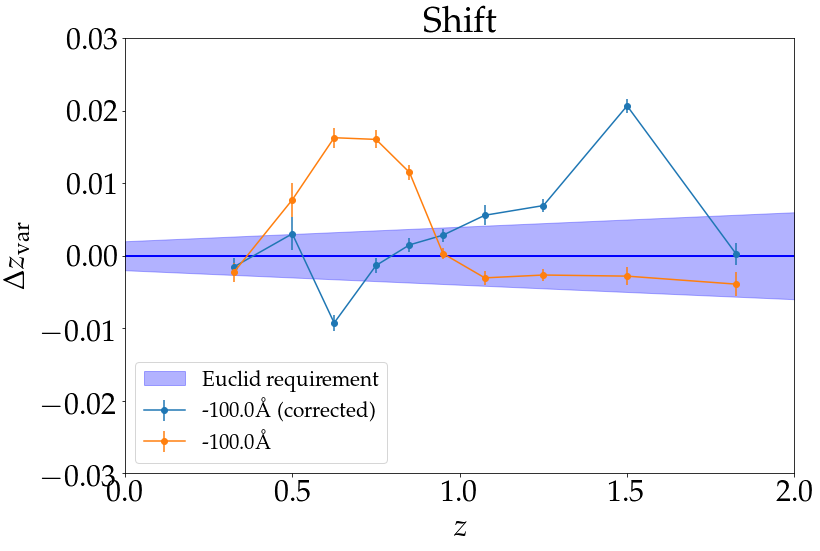

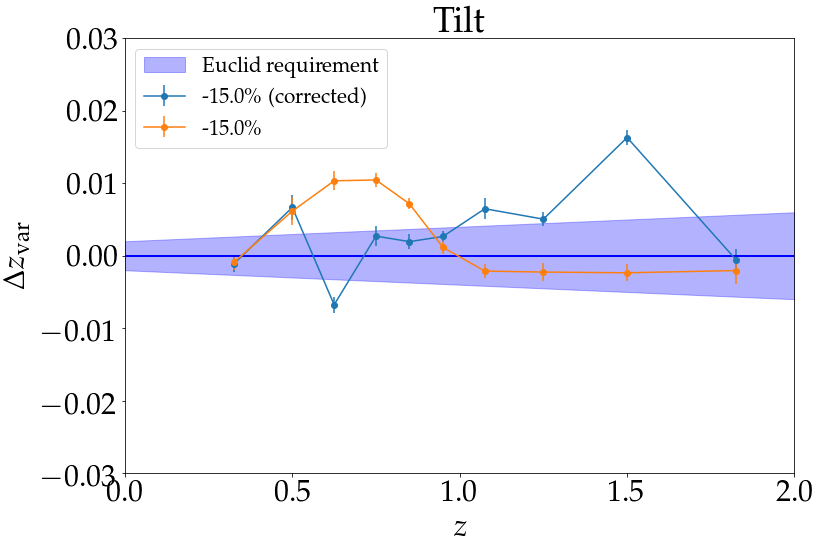

In [79]:
def plot_delta_z_redshift_correct(var_name, var_values, var_units,
        result_file='fluxes_COSMOS15_West_test_vis24.5'):
    """ Plot delta z = <z_var> - <z_fix> """
    
    N_SAMPLES = 20
    # N_SAMPLES = 18

    dz_mean_fix = 0.0
    for i in range(N_SAMPLES):
        data_fix = pd.read_csv(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_PDF_tomo.csv')
        dz_mean_fix += (data_fix['zmean']-data_fix['zmean_ref'])
    dz_mean_fix /= N_SAMPLES

    bins_center = (data_fix['zmin']+data_fix['zmax'])/2.0

    # N_var = len(var_values)
            
    # initialise figure
    fig, ax = plt.subplots()

    ax.set_title(var_name.title())

    ax.set_ylim((-0.03,0.03))
    ax.set_xlim((0.0,2.0))
    
    ax.plot([0.0,2.0],[0.0,0.0], c='blue', lw=2)
    
    ax.fill_between(
        [0.0,2.0], [-0.002*(1.0+0.0),-0.002*(1.0+2.0)], 
        [+0.002*(1.0+0.0),+0.002*(1.0+2.0)], 
        color='blue', alpha=0.3, label='Euclid requirement')
    
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\Delta z_\mathrm{var}$')

    N_var = 10
    
    fac = 1.0
    if var_name == 'stretch' or var_name == 'tilt' or var_name == 'scaling':
        fac = 100.0
    
    # plot two extremes and middle one
    # for n in [0, 4, 9]:
    for n in [0]:


        result = np.zeros((N_SAMPLES, N_var))

        for i in range(N_SAMPLES):
            data_var = pd.read_csv(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_'+var_name+str(n)+'_corr_PDF_tomo.csv')
            result[i, :] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix
        
        dz_mean_var = np.mean(result, axis=0)
        dz_mean_var_err = np.sqrt(2.)*np.std(result, axis=0)/np.sqrt(N_SAMPLES)

        ax.errorbar(            
            bins_center, dz_mean_var, yerr=dz_mean_var_err, label=r'{0:+.1f}{1} (corrected)'.format(
                var_values[n]*fac, var_units), marker='o') 
        
        # dz_mean_var = 0.0
        for i in range(N_SAMPLES):
            # print(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_'+var_name+str(n)+'_PDF_tomo.csv')
            data_var = pd.read_csv(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_'+var_name+str(n)+'_PDF_tomo.csv')
            result[i, :] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix
        
        dz_mean_var = np.mean(result, axis=0)
        dz_mean_var_err = np.sqrt(2.)*np.std(result, axis=0)/np.sqrt(N_SAMPLES)

        ax.errorbar(            
            bins_center, dz_mean_var, yerr=dz_mean_var_err, label=r'{0:+.1f}{1}'.format(
                var_values[n]*fac, var_units), marker='o') 
    ax.legend(fontsize='x-small')
    
    fig.savefig('../plots/delta_z_redshift_'+var_name+'_corr.pdf')
    
    return

# plot_delta_z_redshift_correct('shift', VAR_VALUES['shift'], VAR_UNITS['shift'])
plot_delta_z_redshift_correct('shift', VAR_VALUES['shift'], VAR_UNITS['shift'])
plot_delta_z_redshift_correct('tilt', VAR_VALUES['tilt'], VAR_UNITS['tilt'])

In [77]:
def plot_delta_z_var_correct(
        var_name, var_values, var_units,
        result_file='fluxes_COSMOS15_West_test_vis24.5'):
    """ Plot delta z = <z_var> - <z_fix> """
    
    # fixed transmission (reference)
    dz_mean_fix = 0.0
    for i in range(N_SAMPLES):
        data_fix = pd.read_csv(DATADIR+'/'+result_file+'/'+str(i)+'_pz_r_PDF_z0.63.csv')
        dz_mean_fix += (data_fix['zmean']-data_fix['zmean_ref'])
    dz_mean_fix /= N_SAMPLES
    
    bins_center = (data_fix['zmin']+data_fix['zmax'])/2.0

    one_plus_z = 1.0+bins_center[0]
    
    fac = 1.0
    if var_name == 'stretch' or var_name == 'tilt' or var_name == 'scaling':
        fac = 100.0

    # initialise figure
    fig, ax = plt.subplots(1,1)
    
    ax.set_title(var_name.title()+' ($z\sim0.63$)')
    ax.set_ylim((-0.03,0.03))
    xlim = ax.set_xlim((var_values[0]*fac,var_values[-1]*fac))
    ax.set_xlabel('{0} [{1}]'.format(var_name,var_units))
    ax.set_ylabel(r'$\Delta z_\mathrm{var}$')
    ax.plot(xlim,[0.0,0.0], c='blue', lw=2)

    ax.fill_between(
        xlim, [-0.002*one_plus_z,-0.002*one_plus_z], 
        [+0.002*one_plus_z,+0.002*one_plus_z], 
        color='blue', alpha=0.3, label='Euclid requirement')
     
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))   
        
    Deltaz = []
    Deltaz_err = []

    for n in range(len(var_values)):

        result = np.zeros(N_SAMPLES)
        for i in range(N_SAMPLES):
            data_var = pd.read_csv(
                DATADIR+'/'+result_file+'/'+str(i)
                +'_pz_r_'+var_name+str(n)+'_PDF_z0.63.csv')
            result[i] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix

        # N = data_var['N']
        dz_mean_var = np.mean(result, axis=0)
        dz_mean_var_err = np.std(result, axis=0)

        Deltaz.append(dz_mean_var)
        Deltaz_err.append(dz_mean_var_err/np.sqrt(N_SAMPLES))
    
    ax.errorbar(var_values*fac, Deltaz, yerr=Deltaz_err, marker='o', label='Measured')

    Deltaz = []
    Deltaz_err = []

    for n in range(len(var_values)):

        result = np.zeros(N_SAMPLES)
        for i in range(N_SAMPLES):
            data_var = pd.read_csv(
                DATADIR+'/'+result_file+'/'+str(i)
                +'_pz_r_'+var_name+str(n)+'corr_PDF_z0.63.csv')
            result[i] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix

        # N = data_var['N']
        dz_mean_var = np.mean(result, axis=0)
        dz_mean_var_err = np.std(result, axis=0)

        Deltaz.append(dz_mean_var)
        Deltaz_err.append(dz_mean_var_err/np.sqrt(N_SAMPLES))
    
    ax.errorbar(var_values*fac, Deltaz, yerr=Deltaz_err, marker='o', label='Measured (corrected)')
   
    
    if var_name == 'shift':
        ax.plot(var_values, -var_values/4000.0/(1.5), label='Approximation')
    
    ax.legend(fontsize='x-small', loc='upper right')

    fig.set_tight_layout(True)

    fig.savefig('../plots/delta_z_var_'+var_name+'.pdf')
    
    return Deltaz, Deltaz_err

IOError: File /Users/coupon/data/euclid/varTrans/fluxes_COSMOS15_West_test_vis24.5/0_pz_r_shift0corr_PDF_z0.63.csv does not exist

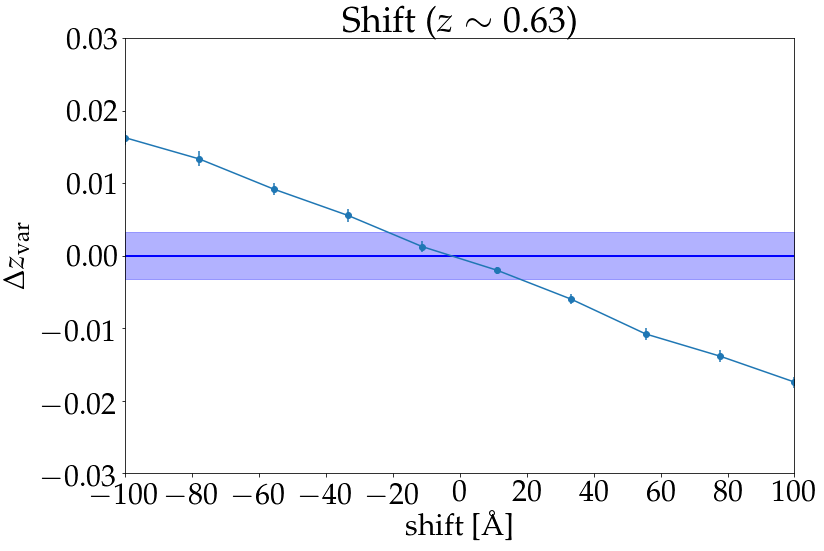

In [78]:
for var_name in ['shift', 'tilt']:
    plot_delta_z_var_correct(var_name, VAR_VALUES[var_name], VAR_UNITS[var_name])

#df_list = []
#for var_name in ['shift', 'tilt']:
#    df = pd.read_csv('../results/trans_stats_{}.csv'.format(var_name))
#    df['Deltaz'], df['Deltaz_err'] = plot_delta_z_var(
#            var_name, VAR_VALUES[var_name], VAR_UNITS[var_name])
#    df['var_name'] = [var_name]*10
#    df_list.append(df)

# merge first moments and chi2
# pd.concat(df_list).to_csv('../results/trans_stats_Deltaz.csv', index=False)

## Photo-$z$ with random filter variations (all bands)

In [ ]:
def cmd_compute_pz_ran(ran, file_test, file_training, corr=False):
    """compute the photo-z PDF given a 
    reference (TRAINING) and a 
    target sample (TEST)
    """

    if corr:
        file_out = file_test.replace(
            '.fits', '_pz_{}_corr.fits'.format(ran))
        reference_catalog_filters = "[\
(\'u_{0}_corr\', None),\
(\'g_{0}_corr\', None),\
(\'r_{0}_corr\', None),\
(\'i_{0}_corr\', None),\
(\'z_{0}_corr\', None),\
(\'vis_{0}_corr\', None),\
(\'Y_{0}_corr\', None),\
(\'J_{0}_corr\', None),\
(\'H_{0}_corr\', None)\
]".format(ran)

    else:
        file_out = file_test.replace(
            '.fits', '_pz_{}.fits'.format(ran))

        reference_catalog_filters = "[\
(\'u\', None),\
(\'g\', None),\
(\'r\', None),\
(\'i\', None),\
(\'z\', None),\
(\'vis\', None),\
(\'Y\', None),\
(\'J\', None),\
(\'H\', None)\
]"   
    
    target_catalog_filters = "[\
(\'u_{0}_obs\', \'u_{0}_obs_err\'),\
(\'g_{0}_obs\', \'g_{0}_obs_err\'),\
(\'r_{0}_obs\', \'r_{0}_obs_err\'),\
(\'i_{0}_obs\', \'i_{0}_obs_err\'),\
(\'z_{0}_obs\', \'z_{0}_obs_err\'),\
(\'vis_{0}_obs\', \'vis_{0}_obs_err\'),\
(\'Y_{0}_obs\', \'Y_{0}_obs_err\'),\
(\'J_{0}_obs\', \'J_{0}_obs_err\'),\
(\'H_{0}_obs\', \'H_{0}_obs_err\')\
]".format(ran)
    
    cmd = 'nnpz nnpz_base.conf \
        --reference_catalog {} \
        --reference_catalog_filters \"{}\" \
        --target_catalog {} \
        --target_catalog_filters \"{}\" \
        --output_file {}\n'.format(
            file_training, 
            reference_catalog_filters,
            file_test,
            target_catalog_filters,
            file_out)
    
    return cmd

In [ ]:
def cmd_compute_stats_new_fmt(r, file_test, corr=False):
    """compute the photo-z PDF given a
    reference (TRAINING) and a 
    target sample (TEST) for a given
    "r" filter
    """

    file_in = file_test.replace('.fits', '_pz_'+r+'.fits')
    file_scatter = file_test.replace('.fits', '_pz_'+r+'_scatter.pdf')
    file_density = file_test.replace('.fits', '_pz_'+r+'_density.pdf')
    file_tomo = file_test.replace('.fits', '_pz_'+r+'_PDF_tomo.pdf')
    file_z_0_63 = file_test.replace('.fits', '_pz_'+r+'_PDF_z0.63.pdf')

    if corr:
        file_in = file_in.replace('.fits', '_corr.fits')
        file_scatter = file_scatter.replace('.pdf', '_corr.pdf')
        file_density = file_density.replace('.pdf', '_corr.pdf')
        file_tomo = file_tomo.replace('.pdf', '_corr.pdf')
        file_z_0_63 = file_z_0_63.replace('.pdf', '_corr.pdf')
    
    #cmd = 'photoz_metrics.py scatter -i {} -o {} \
    #    \n'.format(
    #file_in, file_scatter)

    cmd = 'photoz_metrics.py scatter -i {} -o {} \
        -density \n'.format(
    file_in, file_density)

    cmd += 'photoz_metrics.py PDF -i {} -o {} \
        -stats_output {}\n'.format(
    file_in, file_tomo, file_tomo.replace('.pdf', '.csv'))

    cmd += 'photoz_metrics.py PDF -i {} -o {} \
        -z_bins 0.55,0.70 -stats_output {} \
        \n'.format(
    file_in, file_z_0_63, file_z_0_63.replace('.pdf', '.csv'))

    cmd += 'ls {}; ls {}\n'.format(
        file_z_0_63.replace('.pdf', '.csv'),
        file_tomo.replace('.pdf', '.csv'))
    
    return cmd

In [ ]:
# input files
file_input = '{}/fluxes_ran_COSMOS15.fits'.format(DATADIR)
file_training = '{}/fluxes_COSMOS15_East_training_vis24.5.fits'.format(DATADIR)
file_test = '{}/fluxes_ran_COSMOS15_West_test_vis24.5.fits'.format(DATADIR)

In [ ]:
# run photo-z and stats locally for checks
if False:
    ! {cmd_compute_pz(
        'r_shift0', file_test, 
        file_training.replace('.fits', '_corrected.fits'), 
        r_corr='r_shift0_corr')}
    ! {cmd_compute_stats('r_shift0', file_test, corr=True)}

In [ ]:
# compute photo-z's and stats locally for checks

# make test catalogues
if False:
    filter_options = get_filter_options(
    depths_AB_euclid_wide, skies_AB_euclid,
    filter_ran_dfs.keys() )

    ! {cmd_simulate_test(file_input, \
        file_test, filter_options, \
        seed=seed, vis_name='vis_ran0')}

# no correction
if False:
    ! {cmd_compute_pz_ran('ran0', file_test, file_training)}
    ! {cmd_compute_stats_new_fmt('ran0', file_test)}
    
# correction
if False:
    #! {cmd_compute_pz_ran('ran0', file_test, \
    #    file_training.replace('.fits', '_corrected.fits'), corr=True)}
    ! {cmd_compute_stats_new_fmt('ran0', file_test, corr=True)}

In [ ]:
# run photo-z's with variation corrections
configure_cluster(EXECDIR, EXECMACHINE)

# N_SAMPLES = 20
options='-t 1-{}'.format(N_SAMPLES)

seed = 20091982

# transfer files to cluster
if False:
    ! scp {file_input} {file_training} {file_test} isdc:data/euclid/varTrans/

# make test catalogues
if False:
    filter_options = get_filter_options(
    depths_AB_euclid_wide, skies_AB_euclid,
    filter_ran_dfs.keys() )

    cmd = cmd_simulate_test(
        file_input, 
        file_test.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits'), 
        filter_options, 
        seed=seed, vis_name='vis_ran0')
    submit_job(cmd, options=options)

# compute photo-z's (no correction) and stats
if False:
    cmd = ''
    cmd += cmd_compute_pz_ran(
        'ran0',
        file_test.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits'), 
        file_training)
    cmd += cmd_compute_stats_new_fmt(
        'ran0', file_test.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits'))        
    submit_job(cmd, options=options)

# compute photo-z's (with correction) and stats
if False:
    cmd = ''
    cmd += cmd_compute_pz_ran(
        'ran0', 
        file_test.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits'), 
        file_training.replace('.fits', '_corrected.fits'), 
        corr=True)
    cmd += cmd_compute_stats_new_fmt(
        'ran0', file_test.replace('.fits','/$( expr $SGE_TASK_ID - 1).fits'), 
        corr=True)        
    submit_job(cmd, options=options)


# get result back
if False:
    resultdir = file_test.replace('.fits','').replace('/Users/coupon/', '')
    ! mkdir -p ~/{resultdir}
    # ! scp isdc:$DIR/\*.fits ~/$DIR/
    ! scp isdc:{resultdir}/\*.csv ~/{resultdir}/

In [ ]:
def plot_delta_z_redshift_correct_ran(var_name, var_values, var_units,
        result_file='fluxes_ran_COSMOS15_West_test_vis24.5'):
    """ Plot delta z = <z_var> - <z_fix> """
    
    N_SAMPLES = 20
    
    dz_mean_fix = 0.0
    for i in range(N_SAMPLES):
        data_fix = pd.read_csv(
            DATADIR+'/'+result_file.replace('ran_', '')
            +'/'+str(i)+'_pz_r_PDF_tomo.csv')
        dz_mean_fix += (data_fix['zmean']-data_fix['zmean_ref'])
    dz_mean_fix /= N_SAMPLES

    bins_center = (data_fix['zmin']+data_fix['zmax'])/2.0
    
    # N_var = len(var_values)
            
    # initialise figure
    fig, ax = plt.subplots()

    ax.set_title('Random variations')

    ax.set_ylim((-0.03,0.03))
    ax.set_xlim((0.0,2.0))
    
    ax.plot([0.0,2.0],[0.0,0.0], c='blue', lw=2)
    
    ax.fill_between(
        [0.0,2.0], [-0.002*(1.0+0.0),-0.002*(1.0+2.0)], 
        [+0.002*(1.0+0.0),+0.002*(1.0+2.0)], 
        color='blue', alpha=0.3, label='Euclid requirement')
    
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$\Delta z_\mathrm{var}$')

    N_var = 10
    
    fac = 1.0
    if var_name == 'stretch' or var_name == 'tilt' or var_name == 'scaling':
        fac = 100.0
    
    result = np.zeros((N_SAMPLES, N_var))

    for i in range(N_SAMPLES):
        data_var = pd.read_csv(
            DATADIR+'/'+result_file+'/'+str(i)
            +'_pz_'+var_name+'_corr_PDF_tomo.csv')
        result[i, :] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix

    dz_mean_var = np.mean(result, axis=0)
    dz_mean_var_err = np.sqrt(2.)*np.std(result, axis=0)/np.sqrt(N_SAMPLES)

    ax.errorbar(            
        bins_center, dz_mean_var, yerr=dz_mean_var_err, label=r'(corrected)', marker='o')

    # dz_mean_var = 0.0
    for i in range(N_SAMPLES):
        data_var = pd.read_csv(
            DATADIR+'/'+result_file+'/'+str(i)
            +'_pz_'+var_name+'_PDF_tomo.csv')
        result[i, :] = (data_var['zmean']-data_var['zmean_ref']) - dz_mean_fix

    dz_mean_var = np.mean(result, axis=0)
    dz_mean_var_err = np.sqrt(2.)*np.std(result, axis=0)/np.sqrt(N_SAMPLES)

    ax.errorbar(            
        bins_center, dz_mean_var, yerr=dz_mean_var_err, label=r'non corrected', marker='o') 
    ax.legend(fontsize='x-small')
    
    fig.savefig('../plots/delta_z_redshift_'+var_name+'_corr.pdf')
    
    return

plot_delta_z_redshift_correct_ran('ran0', None, None)

# Conclusions

We have tested the impact of variable transmissions on photo-$z$'s using simulated fluxes based on the best-fit templates of real galaxies observed with 30 photometric bands in the COSMOS field, and whose emulated fluxes were perturbed according to the minimum-flux SNRs required to meet the precision requirements on photo-$z$ in Euclid.

We only modelled the variations on the $r$-band and we measured the impact in the redshift range which is the most affected, $0.3<z<0.8$, due to the predominance of the Balmer break (4000 Angstroms) to constraint the photometric redshift in this interval.

We modeled three main typical variations: a shift in wavelength, a centered widening (or shortening) of the bandpass and a skewing of the transmission, calibrated using real variations measured on various bandpasses and communicated by OU-EXT, the COG, or found in the literature. 

The main impact is found to be on the mean redshift of an ensemble of galaxies (the so-called mean redshift bias), and our main findings can be summarized as follow:

- The most problematic effect is a systematic shift in mean redshift and is due to the shift in wavelength of the transmission. The impact on the mean redshift scales linearly with the inverse of the shift in wavelength for the galaxies whose Balmer break is passing through the transmission. For example a typical shift of +40 Angstroms in the $r$-band will cause a mean redshift bias equal to -40/4000.0 = -0.01, i.e. about three times the requirement.

- consequently, a shift as small as 12 Angstrom (1.2 nm) is on the same order as the requirement on the bias

- after calibration, the widening of the transmission has little impact on the mean redshift

- the main effect of the skewing of the transmission is to increase the transmission mean wavelength, hence it has the same affect as a shift of the transmission

- overall the simulations show that the mean wavelength of the filter is the main quantity that impacts the mean redshift for an ensemble of galaxies

- it also means that simply recording the mean wavelength (reported by the EXT/NIR/MER OUs) of the transmission and shifting it accordingly seems to be sufficient to correct for the bias


So, it is clear that filter variations impact the mean redshift of large samples of galaxies, even when the variation is small. However, it seems not necessary to propagate the full transmission for each object, but only the mean wavelength of the transmission to correct for the effect.


In [ ]:
# tests for Alejandro
if False:
    file_in_1 = '{}/fluxes_COSMOS15_East_training_vis24.5.fits'.format(DATADIR)
    file_in_2 = '{}/fluxes_corrected.fits'.format(DATADIR)
    file_out = '{}/bad.fits'.format(DATADIR)

    thdu_in_1 = fits.open(file_in_1, hdu=1)
    thdu_in_2 = fits.open(file_in_2, hdu=1)

    thdu_list_out = []
    thdu_list_out.append(thdu_in_1[0])
    thdu_list_out.append(
    fits.BinTableHDU.from_columns(
                thdu_in_1[1].columns+thdu_in_2[1].columns[1:]))
    for h in thdu_in_1[2:]:
        thdu_list_out.append(h)

    thdu_out = fits.HDUList(thdu_list_out)
    
    thdu_out = fits.HDUList(thdu_list_out)
    thdu_out.writeto(file_out, overwrite=True)

    thdu_out.close()
    thdu_in_1.close()
    thdu_in_2.close()